# Group 3: Final Project

Sunday afternoon, August 25: Trying to bring this code as close to showtime quality as the presentation looms and as we head into Module 10.

In [1]:
# Basic imports
import random
import numpy as np
import pandas as pd

# LP Shortest Path
import networkx as nx
from pulp import *
from gurobipy import *

# Visualization tools
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression  # Strictly as a plotting aid

# Time and memory tracking tools
import time
import numexpr
from functools import wraps
from scipy.special import comb
from memory_profiler import memory_usage, LogFile
%load_ext memory_profiler

In [2]:
# Previous code defining the number of edges has been superseded
# Do be careful with those definitions, which appear later
# Meanwhile, here are random seeds to enable us to repeat this experiment

RANDOM_SEED1 = 5
RANDOM_SEED2 = 6

## Time Tracker Decorator

In [3]:
# Some initial housekeeping: Set up a nested decorator function to keep track of time

# Time decorator code adapted from:
#   https://stackoverflow.com/questions/3620943/measuring-elapsed-time-with-the-time-module
# Key changes:
#   time.monotonic() instead of time.time()
#   print_prof_data() function revamped to show function / calls / total / average / max in tabular format
#   ** A new functionality: being able to track the _category_ to which a called function belongs

PROF_DATA = {}
DATA_CATEGORIES = {}

def profile(tag = "default"):

    def profile_wrapper(fn):

        @wraps(fn)
        def with_profiling(*args, **kwargs):
            start_time = time.monotonic()
        
            ret = fn(*args, **kwargs)
        
            elapsed_time = time.monotonic() - start_time

            if fn.__name__ not in PROF_DATA:
                PROF_DATA[fn.__name__] = [0, []]
            PROF_DATA[fn.__name__][0] += 1
            PROF_DATA[fn.__name__][1].append(elapsed_time)
            if fn.__name__ not in DATA_CATEGORIES:
                DATA_CATEGORIES[fn.__name__] = tag

            return ret

        return with_profiling

    return profile_wrapper

def print_prof_data():
    print("\n{:>20}\t{:>10}\t{:>8}\t{:>10}\t{:>10}\t{:>10}\t{:>10}".format("Function", "Category", "Calls", "Total", "Average", "Std dev", "Maximum"))
    print(114 * "_" + "\n")
    total_calls = 0
    grand_time = 0
    for fname, data in PROF_DATA.items():
        total_calls += data[0]
        total_time = sum(data[1])
        grand_time += total_time
        avg_time = np.mean(data[1])
        std_time = np.std(data[1])
        max_time = max(data[1])
        print("{:>21s}\t{:>10s}\t{:8d}\t{:10.4f}\t{:10.4f}\t{:10.4f}\t{:10.4f}".format(fname, DATA_CATEGORIES[fname], data[0], total_time, avg_time, std_time, max_time))
    print(114 * "_")
    print("\n{:>21}\t{:>10s}\t{:8d}\t{:10.4f}\t{:10.4f}".format("ALL FUNCTIONS", "***", total_calls, grand_time, grand_time / total_calls))

def clear_prof_data():
    global PROF_DATA
    PROF_DATA = {}

def clear_data_categories():
    global DATA_CATEGORIES
    DATA_CATEGORIES = {}

def organize_result(PROF_DATA, DATA_CATEGORIES):
    # We can also export PROF_DATA to a DataFrame for nicer display and possibly also for future use
    # Display the refined dataframe so that …
    #   1. It suppresses the individual times, without deleting that information
    #      1a. Do not EVER delete individual times. Those data are absolutely vital to this experiment.
    #   2. It is sorted in descending order of total time taken

    profile_frame = pd.DataFrame(PROF_DATA)
    profile_frame = profile_frame.transpose()
    profile_frame.columns = ["calls", "times"]
    profile_frame["total"] = profile_frame.times.map(sum)
    profile_frame["average"] = profile_frame.times.map(np.mean)
    profile_frame["std_dev"] = profile_frame.times.map(np.std)
    profile_frame["maximum"] = profile_frame.times.map(max)
    profile_frame["minimum"] = profile_frame.times.map(min)
    for function in profile_frame.index:
        profile_frame.loc[function, "category"] = DATA_CATEGORIES[function]

    print("\t*** Timekeeping summary of profiled functions ***\n")
    print("{:d} profiled functions took {:d} calls for {:.6f} total seconds, an average of {:.6f}.".format(len(profile_frame), profile_frame.calls.sum(), profile_frame.total.sum(), profile_frame.total.mean()))

    results = profile_frame.loc[:, ["category", "calls", "total", "average", "std_dev", "maximum", "minimum"]].sort_values(by = "total", ascending = False)
    
    return profile_frame, results

### Test and POC of the Time Tracker Decorator

In [4]:
# Test the time decorator function — Set up

@profile("numpy")
def factorial(n):
    """Assumes n is an integer > 0
        Returns n!"""
    if n == 0:
        return 1
    elif n == 1:
        return n
    else:
        return n * factorial(n - 1)

@profile("numpy")
def permutations(n, r):
    """ Assumes n, k are integers > 0
        Returns nPr """
    nPr = factorial(n)/factorial(n - r)
    nPr = int(round(nPr))
    return nPr

@profile("numpy")
def combinations(n, r):
    """ Assumes n, k are integers > 0
        Returns nCr """
    nCr = permutations(n, r)/factorial(r)
    nCr = int(round(nCr))
    return nCr

# Test the time decorator function — Write a tiny Fibonnaci triangle

for i in range(0, 13):
    for j in range(i + 1):
        print(combinations(i, j), "\t", end = "")
        # print("C({:d}, {:d}) = {:d}\t".format(i, j, combinations(i, j)), end = "")
    print("\n")

print_prof_data()

1 	

1 	1 	

1 	2 	1 	

1 	3 	3 	1 	

1 	4 	6 	4 	1 	

1 	5 	10 	10 	5 	1 	

1 	6 	15 	20 	15 	6 	1 	

1 	7 	21 	35 	35 	21 	7 	1 	

1 	8 	28 	56 	70 	56 	28 	8 	1 	

1 	9 	36 	84 	126 	126 	84 	36 	9 	1 	

1 	10 	45 	120 	210 	252 	210 	120 	45 	10 	1 	

1 	11 	55 	165 	330 	462 	462 	330 	165 	55 	11 	1 	

1 	12 	66 	220 	495 	792 	924 	792 	495 	220 	66 	12 	1 	


            Function	  Category	   Calls	     Total	   Average	   Std dev	   Maximum
__________________________________________________________________________________________________________________

            factorial	     numpy	    1483	    0.0060	    0.0000	    0.0000	    0.0000
         permutations	     numpy	      91	    0.0014	    0.0000	    0.0000	    0.0000
         combinations	     numpy	      91	    0.0020	    0.0000	    0.0000	    0.0001
__________________________________________________________________________________________________________________

        ALL FUNCTIONS	       ***	    1665	    0.0093	  

In [5]:
# Test the time decorator function — Set up

@profile("scipy")
def scipy_comb(n, r):
    """ Assumes n, k are integers > 0
        Returns nCr """
    nCr = comb(n, r, exact = True)
    # nCr = int(round(nCr))
    return nCr

# Test the time decorator function — Write a tiny Fibonnaci triangle

for i in range(0, 13):
    for j in range(i + 1):
        print(scipy_comb(i, j), "\t", end = "")
        # print("C({:d}, {:d}) = {:d}\t".format(i, j, combinations(i, j)), end = "")
    print("\n")

print_prof_data()

1 	

1 	1 	

1 	2 	1 	

1 	3 	3 	1 	

1 	4 	6 	4 	1 	

1 	5 	10 	10 	5 	1 	

1 	6 	15 	20 	15 	6 	1 	

1 	7 	21 	35 	35 	21 	7 	1 	

1 	8 	28 	56 	70 	56 	28 	8 	1 	

1 	9 	36 	84 	126 	126 	84 	36 	9 	1 	

1 	10 	45 	120 	210 	252 	210 	120 	45 	10 	1 	

1 	11 	55 	165 	330 	462 	462 	330 	165 	55 	11 	1 	

1 	12 	66 	220 	495 	792 	924 	792 	495 	220 	66 	12 	1 	


            Function	  Category	   Calls	     Total	   Average	   Std dev	   Maximum
__________________________________________________________________________________________________________________

            factorial	     numpy	    1483	    0.0060	    0.0000	    0.0000	    0.0000
         permutations	     numpy	      91	    0.0014	    0.0000	    0.0000	    0.0000
         combinations	     numpy	      91	    0.0020	    0.0000	    0.0000	    0.0001
           scipy_comb	     scipy	      91	    0.0001	    0.0000	    0.0000	    0.0000
_____________________________________________________________________________________

In [6]:
profile_frame, result = organize_result(PROF_DATA, DATA_CATEGORIES)
result

	*** Timekeeping summary of profiled functions ***

4 profiled functions took 1756 calls for 0.009448 total seconds, an average of 0.002362.


category calls     total   average       std_dev   maximum  \
factorial       numpy  1483  0.005976  0.000004  3.061138e-06  0.000013   
combinations    numpy    91  0.001969  0.000022  5.610054e-06  0.000053   
permutations    numpy    91  0.001371  0.000015  4.342455e-06  0.000026   
scipy_comb      scipy    91  0.000132  0.000001  9.153591e-07  0.000009   

                   minimum  
factorial     2.330000e-07  
combinations  9.859000e-06  
permutations  5.658000e-06  
scipy_comb    8.830000e-07

             calls     total   average   std_dev   maximum       minimum
factorial     1483  0.005976  0.000004  0.000003  0.000013  2.330000e-07
combinations    91  0.001969  0.000022  0.000006  0.000053  9.859000e-06
permutations    91  0.001371  0.000015  0.000004  0.000026  5.658000e-06

            calls     total   average       std_dev   maximum       minimum
scipy_comb    91  0.000132  0.000001  9.153591e-07  0.000009  8.830000e-07

 category
numpy    0.009316
scipy    0.000132
Name: total, dtype: float64

 factorial       0.005976
permutations    0.001371
combinations    0.001969
scipy_comb      0.000132
Name: total, dtype: float64


([<matplotlib.patches.Wedge at 0x1a1ee57748>,
 [Text(-0.347217540984494, 1.096330232745901, 'factorial'),
  Text(-0.5779906917231122, -0.994196540067123, 'permutations'),
  Text(0.5740291023099422, -0.9964891317526962, 'combinations'),
  Text(1.2031911430636595, -0.49227134108453297, 'scipy_comb')])

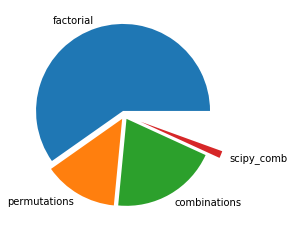

In [7]:
print(profile_frame[profile_frame.category == "numpy"].loc[:, ["calls", "total", "average", "std_dev", "maximum", "minimum"]].sort_values(by = "total", ascending = False))
print("\n", profile_frame[profile_frame.category == "scipy"].loc[:, ["calls", "total", "average", "std_dev", "maximum", "minimum"]].sort_values(by = "total", ascending = False))
print("\n", profile_frame.total.groupby(profile_frame.category).sum())
print("\n", profile_frame["total"])
plt.pie(profile_frame.total * 100, explode = (0.05, 0.05, 0.05, 0.2), labels = profile_frame.index)

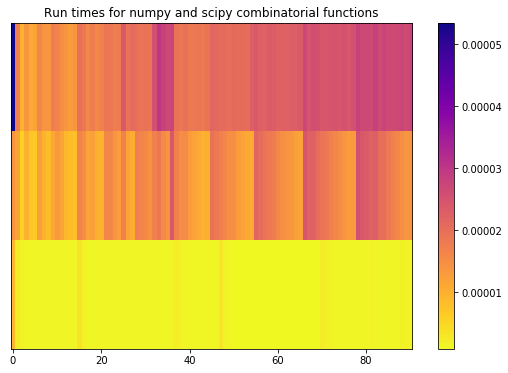

In [8]:
plt.figure(figsize = (9, 6))
plt.title("Run times for numpy and scipy combinatorial functions")
plt.imshow([profile_frame.loc["combinations", "times"][: len(profile_frame.loc["scipy_comb", "times"])], profile_frame.loc["permutations", "times"][: len(profile_frame.loc["scipy_comb", "times"])],
            profile_frame.loc["scipy_comb", "times"]],
           aspect = "auto", interpolation = "none", cmap = "plasma_r")
plt.yticks([])
plt.colorbar()
plt.savefig("combinatorial_demonstration_time_matrix.png")

In [9]:
# # Initiating a new time tracker so that we start fresh

clear_prof_data()
clear_data_categories()

# A little math

## Create Variables

Data Dictionary:
- $(i,j)$ is an edge, with i as a node and j as a node
    - $k$ is another node (referenced in the constraints)
- $E$ is the full set of Edges
- $V$ is the full set of Nodes
- $s$ is the start node or supply node
- $t$ is the target note or the demand node

Decision variable for each arc in the network

$x_{ij} \forall (i,j)$ where $(i,j) \subseteq E$

Bounds / Non Negativity

$x_{ij} \ge 0$  $ \forall (i,j)$, where $(i,j) \subseteq E$

## Create Objective Function

#### General case:

Minimize the total cost of each edge. "Chosen" edges will = 1, non-chosen edges will = 0

Minimize $z = \Sigma_i \Sigma_j  c_{ij}x_{ij} \forall (i,j) \subseteq E$ where $i \subseteq V$ and $j \subseteq V$

#### Our Case:


The edge lengths are arbitrary (they all equal 1) so we can minimize the sum of the edges. Again, chosen = 1, non chosen = 0


Minimize $z = \Sigma$ $ x_{ij}  $ $\forall$ $  (i,j) $ $ \subseteq E$ where $i \subseteq V$ and $j \subseteq V$

## Constraints

There will be a constraint for each node. They are called the balance of flow constraints.

1. [sum of inflows into node] - [sum of outflows from node] = 0, if node is not the supply or the demand node

2. [sum of inflows into node] - [sum of outflows from node] = -1, if node is the start/supply node
3. [sum of inflows into node] - [sum of outflows from node] = 1, if node is the target/demand node

-----

1. $\Sigma$ $ x_{ij} - x_{jk} = 0$ $ \forall j$ $ \subseteq V$ where $j \ne s$ , $j \ne t$, $\forall i \to j$ and $\forall j \to k$
    - where $i,j,k \subseteq V$

2. $\Sigma$ $ x_{ij} - x_{jk} = -1$,  where $j = s$ , $j \ne t$, $\forall i \to j$ and $\forall j \to k$
    - where $i,j,k \subseteq V$

3. $\Sigma$ $ x_{ij} - x_{jk} = 1$,  where $j = t$ , $j \ne t$, $\forall i \to j$ and $\forall j \to k$
    - where $i,j,k \subseteq V$

## A demonstration 

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


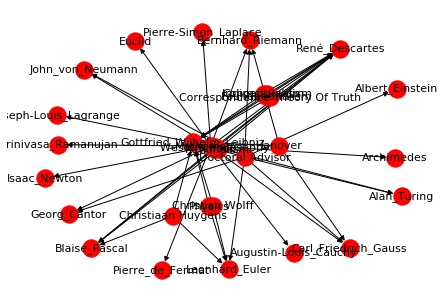

In [10]:
z0 = [('Hanover', 'Gottfried_Wilhelm_Leibniz'),
 ('Hanover', 'Carl_Friedrich_Gauss'),
 ('Hanover', 'Bernhard_Riemann'),
 ('Western Philosophy', 'Gottfried_Wilhelm_Leibniz'),
 ('Western Philosophy', 'Blaise_Pascal'),
 ('Western Philosophy', 'René_Descartes'),
 ('School', 'Gottfried_Wilhelm_Leibniz'),
 ('School', 'Blaise_Pascal'),
 ('School', 'René_Descartes'),
 #('Rationalism', 'Gottfried_Wilhelm_Leibniz'), #To illustrate a longer than 2 click path
 ('Rationalism', 'Blaise_Pascal'),
 ('Rationalism', 'René_Descartes'),
 ('Foundationalism', 'Gottfried_Wilhelm_Leibniz'),
 ('Foundationalism', 'René_Descartes'),
 ('Conceptualism', 'Gottfried_Wilhelm_Leibniz'),
 ('Conceptualism', 'René_Descartes'),
 ('Indirect Realism', 'Gottfried_Wilhelm_Leibniz'),
 ('Indirect Realism', 'René_Descartes'),
 ('Correspondence Theory Of Truth', 'Gottfried_Wilhelm_Leibniz'),
 ('Correspondence Theory Of Truth', 'René_Descartes'),
 ('Doctoral Advisor', 'Gottfried_Wilhelm_Leibniz'),
 ('Doctoral Advisor', 'Leonhard_Euler'),
 ('Doctoral Advisor', 'Carl_Friedrich_Gauss'),
 ('Doctoral Advisor', 'Bernhard_Riemann'),
 ('Doctoral Advisor', 'John_von_Neumann'),
 ('Doctoral Advisor', 'Alan_Turing'),
 ('Doctoral Advisor', 'Georg_Cantor'),
 ('Doctoral Advisor', 'Albert_Einstein'),
 ('Christiaan Huygens', 'Gottfried_Wilhelm_Leibniz'),
 ('Christiaan Huygens', 'Leonhard_Euler'),
 ('Christiaan Huygens', 'Blaise_Pascal'),
 ('Christian Wolff', 'Gottfried_Wilhelm_Leibniz'),
 ('Christian Wolff', 'Leonhard_Euler'),
 ('Mathematics', 'Gottfried_Wilhelm_Leibniz'),
 ('Mathematics', 'Euclid'),
 ('Mathematics', 'Carl_Friedrich_Gauss'),
 ('Mathematics', 'Isaac_Newton'),
 ('Mathematics', 'Bernhard_Riemann'),
 ('Mathematics', 'Augustin-Louis_Cauchy'),
 ('Mathematics', 'John_von_Neumann'),
 ('Mathematics', 'Joseph-Louis_Lagrange'),
 ('Mathematics', 'Alan_Turing'),
 ('Mathematics', 'Georg_Cantor'),
 ('Mathematics', 'Pierre_de_Fermat'),
 ('Mathematics', 'Pierre-Simon_Laplace'),
 ('Mathematics', 'Srinivasa_Ramanujan'),
 ('Mathematics', 'Archimedes'),
 ('Mathematics', 'René_Descartes'),
 ('Physics', 'Gottfried_Wilhelm_Leibniz'),
 ('Physics', 'Leonhard_Euler'),
 ('Gottfried_Wilhelm_Leibniz','Mathematics')]


#Nodes
z1 = ['Hanover', 'Western Philosophy', 'School', 'Rationalism',
       'Foundationalism', 'Conceptualism', 'Indirect Realism',
       'Correspondence Theory Of Truth', 'Doctoral Advisor',
       'Christiaan Huygens', 'Christian Wolff', 'Mathematics', 'Physics',
       'Gottfried_Wilhelm_Leibniz', 'Carl_Friedrich_Gauss',
       'Bernhard_Riemann', 'Blaise_Pascal', 'René_Descartes',
       'Leonhard_Euler', 'John_von_Neumann', 'Alan_Turing',
       'Georg_Cantor', 'Albert_Einstein', 'Euclid', 'Isaac_Newton',
       'Augustin-Louis_Cauchy', 'Joseph-Louis_Lagrange',
       'Pierre_de_Fermat', 'Pierre-Simon_Laplace', 'Srinivasa_Ramanujan',
       'Archimedes']

#init graph object
G = nx.Graph()
G_2 = nx.DiGraph()

#Substantiate graph object with nodes and edges
#G.add_edges_from(list(G_prime.edges)[:10])
G.add_edges_from(z0)
G.add_nodes_from(z1)
G_2.add_edges_from(z0)
G_2.add_nodes_from(z1)
nx.draw(G_2, with_labels = True, font_size = 11)

In [11]:
#Creates a dictionary of the node IDs to the values for later lookup and reverse lookup
nodes_ = list(G_2.nodes)
nodes_dict = dict(zip(range(0,len(nodes_)),nodes_)) #    {0: 'Hanover', 1: 'Gottfried_Wilhelm_Leibniz',..}
nodes_dict_rev = dict(zip(nodes_,range(0,len(nodes_))))# {'Hanover': 0,'Gottfried_Wilhelm_Leibniz': 1,..}
nodes_ = list(nodes_dict.keys())


#Define start and end node. Node A to B
start_node = nodes_dict_rev['Gottfried_Wilhelm_Leibniz']
end_node = nodes_dict_rev['Alan_Turing']


#Create a dictionary of nodes and their net demands
#Iterates through each node and adds it to the node demand
# dictionary with a net demand of 0, then sets the supply
# and demand node of the network problem to -1 and 1 
# respectively
net_ds_nodes_ = {} #{0: [-1, 0], 1: [0, 0], 2: [0, 0],... 8: [0,1], ... }
for node in nodes_:
    net_ds_nodes_[node] = [0,0]
net_ds_nodes_[start_node] = [-1,0]
net_ds_nodes_[end_node] = [0,1]


#Creates a dictionary of arcs3
arcs_ = list(G_2.edges)

#Creates a dictionary for each arc and swapping the node values for node IDs
arcs_dict = {}

for a,b in arcs_:
    x = nodes_dict_rev[a]
    y = nodes_dict_rev[b]
    arcs_dict[(x,y)] = (a,b)


arcs_ = list(arcs_dict.keys())

#Costs, lower bound, upper bound
arcData_ = dict(zip(arcs_, [[1,0,1]]*len(arcs_)))

#Makes it easy to reference a dictionary with subdicts
supply_,demand_ = splitDict(net_ds_nodes_)
(costs_,mins_,maxs_) = splitDict(arcData_)


arcData_ = dict(zip(arcs_, [[1,0,1]] * len(arcs_)))


supply_, demand_ = splitDict(net_ds_nodes_)
(costs_, mins_, maxs_) = splitDict(arcData_)

In [12]:
# Here we created a dictionary of the arcs as the keys, and the values as the cost. Looks like this:
# {(1,4): 1,
#  (3,7): 1,
#   etc...} 

# The multidict is a gurobi function that allows you to reference the dict.keys() and dict.values()
# easily. We called them arcs, cost
arcs, cost = multidict(dict(zip(arcs_,[1]*len(arcs_))))

#Init model
m = Model("Gurobi_base_LP")

# Here we add the arcs as variables to "flow". We use obj = cost to say that the objective
# is to minimize the cost (which is 1 for every edge). Gurobi's default is to MINIMIZE,
# and has a feature where you can declare the objective right in the definition of the variables.
flow = m.addVars(arcs, obj=cost, name="flow")


# Here we add the constraints for the "intermediate nodes" where their inflows - outflows = 0.
# The arcs.select() is a gurobi function that allows us a wildcard selection. This is the key
# as it allows us to avoid the list comprehension that was screwing us over. 
m.addConstrs(
  (quicksum(flow[i,j] for i,j in arcs.select('*',j)) ==
    quicksum(flow[j,k] for j,k in arcs.select(j,'*'))
    for j in nodes_ if not((j == start_node) or (j==end_node))), "node")

m.addConstrs(
  (quicksum(flow[i,j] for i,j in arcs.select('*',j)) -
    quicksum(flow[j,k] for j,k in arcs.select(j,'*')) == -1
    for j in nodes_ if (j == start_node)), "start_node")
    
m.addConstrs(
  (quicksum(flow[i,j] for i,j in arcs.select('*',j)) -
    quicksum(flow[j,k] for j,k in arcs.select(j,'*')) == 1
    for j in nodes_ if (j == end_node)), "end_node")

# Compute optimal solution
m.optimize()

# Print solution
if m.status == GRB.Status.OPTIMAL:
    solution = m.getAttr('x', flow)

    for i,j in arcs:
        if solution[i,j] > 0:
            print('%s -> %s: %g' % (i, j, solution[i,j]))

Academic license - for non-commercial use only
Optimize a model with 31 rows, 50 columns and 100 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 31 rows and 50 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.000000000e+00
1 -> 21: 1
21 -> 16: 1


In [13]:
# Here we created a dictionary of the nodes as the keys, and the values as the cost. Looks like this:
# {(1: 1,
#   2: 1,
#   3: 1,
#   etc...} 
  
# The multidict is a gurobi function that allows you to reference the dict.keys() and dict.values()
# easily. We called them nodes, cost
nodes, cost = multidict(dict(zip(nodes_,[1]*len(arcs_))))

#init model
m = Model("Gurobi_base_LP")


# Here we add the model decision variables into "flow". We do not write the objective function into
# this declaration, because it is a little bit different.
flow = m.addVars(nodes, name="flow")


#Here we set the objective. I don't know a good intution for this. We choose maximize.
m.setObjective(-flow[start_node] + flow[end_node], GRB.MAXIMIZE)


# Theres only one constraint for the dual. It basically says that for every arc we want the difference
# in value at the inflow node and outflow node to be less than or equal one.  To me,
# the intuition here is that the its constraining the edges to be connected. 
m.addConstrs((flow[e[1]] - flow[e[0]] <= 1 for e in arcs_), "constr")

# Compute optimal solution
m.optimize()

# Print solution
if m.status == GRB.Status.OPTIMAL:
    solution = m.getAttr('x', flow)
    print(solution)

Optimize a model with 50 rows, 31 columns and 100 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 50 rows and 31 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.000000000e+00
{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 1.0, 14: 0.0, 15: 0.0, 16: 2.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 1.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0}


# The Algorithms

### Define common data and functions

In [14]:
def initiate_graph(num_edges):
    #G = nx.read_gexf('./data/math_wikipedia_pages_links_dict.gexf')
    G = nx.read_gexf('./data/math_wikipedia_pages_links_dict.gexf')
    G_2 = G.to_directed()
    

    # Choose subset of wikipedia dataset to test algorithms
    def random_subset_of_arcs(arcs, subset_size):
        """Used to take a random subset of arcs and return a sample
        Can be used in conjunction with the below sampled_edges in a loop"""
        num_arcs = len(arcs)
        selections = random.sample(range(1,num_arcs), subset_size)
        return selections

    def choose_random_nodes(list_of_nodes):
        """Chooses 2 random nodes for testing"""
        num_nodes = len(list_of_nodes)
        node_a, node_b = random.sample(range(0,num_nodes),2)
        return (node_a, node_b)

    # Returns edge samples # Can be used to create a subgraph
    sampled_edges = list(map(list(G_2.edges).__getitem__, random_subset_of_arcs(list(G_2.edges),num_edges)))

    # Looks up the nodes in the sampled edges and returns that
    sampled_nodes = list(pd.Series([node for edge in sampled_edges for node in edge]).unique())

    return sampled_nodes, sampled_edges

In [15]:
### This is an absolutely vital code cell
# It defines the number of runs for each instance = NUM_RUNS
#   The number 1024 is a little unusual, but choosing 2^10 (or 32^2) offers visual advantages over 10^3
# And it defines the exponentially scaled instances, starting with NUM_EDGES as the base case

NUM_RUNS = 1024 # Number of sets of OD pairs to run algorithm with

# 148 is the integer equivalent of np.exp(5) ≈ 148.413

NUM_EDGES = 148 # Number of edges to sample from wiki dataset. A successful run was had with 32 * 4 ** 0, 1, 2, 3
MULTIPLIER = np.e

# Test with logarithmically scaled number of edges
NUM_EDGES_2 = int(round(np.exp(5) * MULTIPLIER ** 1))  # 32 * 4   = 128  # 56 * e ≈ 148
NUM_EDGES_3 = int(round(np.exp(5) * MULTIPLIER ** 2))  # 32 * 16  = 512
NUM_EDGES_4 = int(round(np.exp(5) * MULTIPLIER ** 3))  # 32 * 64  = 2048

In [16]:
NUM_EDGES, NUM_EDGES_2, NUM_EDGES_3, NUM_EDGES_4  # Should be integer equivalents of exp(5, 6, 7, 8)

(148, 403, 1097, 2981)

In [17]:
# We need to define this. Better to do it up front, in a prominent cell.
# Stick with the default value of 0.1, with the option of switching to 0.01

MEMORY_INTERVAL = 0.1

In [18]:
# Define all different sets of sampled nodes and edges
sampled_nodes_1, sampled_edges_1 = initiate_graph(NUM_EDGES)
sampled_nodes_2, sampled_edges_2 = initiate_graph(NUM_EDGES_2)
sampled_nodes_3, sampled_edges_3 = initiate_graph(NUM_EDGES_3)
sampled_nodes_4, sampled_edges_4 = initiate_graph(NUM_EDGES_4)


#Creates a bunch of sampled graphs
H_1 = nx.DiGraph()
H_1.add_edges_from(sampled_edges_1)
H_2 = nx.DiGraph()
H_2.add_edges_from(sampled_edges_2)
H_3 = nx.DiGraph()
H_3.add_edges_from(sampled_edges_3)
H_4 = nx.DiGraph()
H_4.add_edges_from(sampled_edges_4)



#Basically looks at all the nodes and finds the ones that have paths to other nodes longer than the requirement
path_length_req = 2

connections_1 = {}
sps_1 = {}
for node in list(H_1.nodes):
    sps_1[node] = nx.single_source_shortest_path(H_1, source = node)
    for paths in sps_1[node].values():
        if len(paths) >= path_length_req:
            connections_1[node] = paths
            
connections_2 = {}
sps_2 = {}
for node in list(H_2.nodes):
    sps_2[node] = nx.single_source_shortest_path(H_2, source = node)
    for paths in sps_2[node].values():
        if len(paths) >= path_length_req:
            connections_2[node] = paths
            
connections_3 = {}
sps_3 = {}
for node in list(H_3.nodes):
    sps_3[node] = nx.single_source_shortest_path(H_3, source = node)
    for paths in sps_3[node].values():
        if len(paths) >= path_length_req:
            connections_3[node] = paths

connections_4 = {}
sps_4 = {}
for node in list(H_4.nodes):
    sps_4[node] = nx.single_source_shortest_path(H_4, source = node)
    for paths in sps_4[node].values():
        if len(paths) >= path_length_req:
            connections_4[node] = paths
            
# This final section is repeated right at the beginning of "Big Runs"
# I will leave this here in case anyone ever wishes to stage the small trial experiments again …
#   … either as a warmup, or in their own right

#Create the start and end nodes lists
random_sample_path_list_1 = np.random.choice(list(connections_1.keys()),NUM_RUNS)
start_nodes_keys_list_1 = [connections_1[node][0] for node in random_sample_path_list_1]
end_nodes_keys_list_1 = [connections_1[node][-1] for node in random_sample_path_list_1]
            
#Create the start and end nodes lists
random_sample_path_list_2 = np.random.choice(list(connections_2.keys()),NUM_RUNS)
start_nodes_keys_list_2 = [connections_2[node][0] for node in random_sample_path_list_2]
end_nodes_keys_list_2 = [connections_2[node][-1] for node in random_sample_path_list_2]

random_sample_path_list_3 = np.random.choice(list(connections_3.keys()),NUM_RUNS)
start_nodes_keys_list_3 = [connections_3[node][0] for node in random_sample_path_list_3]
end_nodes_keys_list_3 = [connections_3[node][-1] for node in random_sample_path_list_3]

random_sample_path_list_4 = np.random.choice(list(connections_4.keys()),NUM_RUNS)
start_nodes_keys_list_4 = [connections_4[node][0] for node in random_sample_path_list_4]
end_nodes_keys_list_4 = [connections_4[node][-1] for node in random_sample_path_list_4]

In [19]:
print(start_nodes_keys_list_1[:10], "\n")
print(end_nodes_keys_list_1[:10])

['T-symmetry', 'Higher Arithmetic', 'Algebraic Computation', 'Navigation', 'Academic Disciplines', 'Polish Space', 'Graph Theory', 'Homogeneous polynomial', 'Smooth Manifold', '838 (number)'] 

['Experimental Mathematics', 'Philosophy of mathematics', 'Finite geometry', 'Triangle', 'Automata theory', 'Borel isomorphism', 'Calculus', 'Curve', 'Implicit function', '342 (number)']


In [20]:
nx.dijkstra_path(H_3, source = start_nodes_keys_list_3[0], target = end_nodes_keys_list_3[0])

['Lefschetz fixed-point theorem', 'Nonlinear Analysis']

### Define general functions for LPs

In [21]:
def create_arcs(sampled_nodes, sampled_edges, start_node_key, end_node_key): 

    # Creates a dictionary of the node IDs to the values for later lookup and reverse lookup
    nodes_ = sampled_nodes
    nodes_dict = dict(zip(range(0,len(nodes_)),nodes_)) #    {0: 'Hanover', 1: 'Gottfried_Wilhelm_Leibniz',..}
    nodes_dict_rev = dict(zip(nodes_,range(0,len(nodes_))))# {'Hanover': 0,'Gottfried_Wilhelm_Leibniz': 1,..}
    nodes_ = list(nodes_dict.keys())

    # Define start and end node. Node A to B
    start_node = nodes_dict_rev[start_node_key]
    end_node = nodes_dict_rev[end_node_key]

    # Create a dictionary of nodes and their net demands
    # Iterates through each node and adds it to the node demand
    # dictionary with a net demand of 0, then sets the supply
    # and demand node of the network problem to -1 and 1respectively
    net_ds_nodes_ = {} #{0: [-1, 0], 1: [0, 0], 2: [0, 0],... 8: [0,1], ... }
    for node in nodes_:
        net_ds_nodes_[node] = [0,0]
    net_ds_nodes_[start_node] = [-1,0]
    net_ds_nodes_[end_node] = [0,1]

    #Creates a dictionary of arcs3
    arcs_ = sampled_edges

    #Creates a dictionary for each arc and swapping the node values for node IDs
    arcs_dict = {}
    
    # example output for arcs_dict:
    # {(0, 1): ('Hanover', 'Gottfried_Wilhelm_Leibniz'),
    #  (0, 2): ('Hanover', 'Carl_Friedrich_Gauss'),
    
    for a,b in arcs_:
        x = nodes_dict_rev[a]
        y = nodes_dict_rev[b]
        arcs_dict[(x,y)] = (a,b)

    arcs_ = list(arcs_dict.keys())
    return nodes_, arcs_, net_ds_nodes_, start_node, end_node

def run_LP(prob_):
    prob_.solve() 
    return value(prob_.objective)

## Base Linear Program

### Define base LP

In [22]:
def define_base_lp(nodes_, arcs_, net_ds_nodes_, start_node, end_node):
    # Costs, lower bound, upper bound
    arcData_ = dict(zip(arcs_, [[1,0,1]]*len(arcs_)))

    # Makes it easy to reference a dictionary with subdicts
    supply_,demand_ = splitDict(net_ds_nodes_)
    (costs_,mins_,maxs_) = splitDict(arcData_)

    # Create LP Problem    
    prob_ = LpProblem("Shortest Path, Minimum Cost Problem",LpMinimize)

    # Create variables
    LpVars_ = LpVariable.dicts("Route", arcs_, 0, None, LpInteger)

    # Set bounds on variables
    for a in arcs_:
        LpVars_[a].bounds(mins_[a], maxs_[a])

    #Objective Function
    prob_ += lpSum([LpVars_[a]  for a in arcs_]), "Shortest Path" 
  
    # Constraints:
    #For each node that is not a start node or end note, set the inflow = outflow so that the
    #"path" of clicks must go THROUGH the node
    for n in nodes_:
        if ((n == start_node) or (n == end_node)):
            continue
        #Balance-of-flow constraints [ inflow - outflow  = net demand]
        # since net demand is 0 for most of the nodes, inflow = outflow is the constraint
        prob_ += (lpSum([LpVars_[(i,j)] for (i,j) in arcs_ if j == n]) - lpSum([LpVars_[(i,j)] for (i,j) in arcs_ if i == n])) == 0,\
                 "Flow Conservation in Node {}".format(n)

    #Start and end node constraints, indicating supply node (-1) and demand node (1).
    #AKA the sender node (-1) and the receiver node (1)
    # prob_ += -lpSum([LpVars_[(i,j)] for (i,j) in arcs_ if i == start_node]) == -1
    # prob_ += lpSum([LpVars_[(i,j)] for (i,j) in arcs_ if j == end_node]) == 1

    prob_ += (lpSum([LpVars_[(i,j)] for (i,j) in arcs_ if j == start_node]) -\
             lpSum([LpVars_[(i,j)] for (i,j) in arcs_ if i == start_node])) == -1

    prob_ += (lpSum([LpVars_[(i,j)] for (i,j) in arcs_ if j == end_node]) -\
             lpSum([LpVars_[(i,j)] for (i,j) in arcs_ if i == end_node])) == 1

    #prob_.constraints
    # prob_.writeLP(r"network_flow_wikipedia.lp")
    
    return prob_

###  Running the base LP

In [23]:
## Note: Many and perhaps all of these functions have been superseded
# However, since recreating them in case we need them would be onerous …
# … and since it does very little damage to memory or processing time to leave them here for now,
# I will just comment and leave these functions intact — for the moment
# Regardless: I will disable all time-profiling decorator functions

# Functions for time tracking, separate function for each number of edges

# @profile("base_lp")
def run_base_lp_1(prob):
    return run_LP(prob)

# @profile("base_lp")
def run_base_lp_2(prob):
    return run_LP(prob)

# @profile("base_lp")
def run_base_lp_3(prob):
    return run_LP(prob)

# @profile("base_lp")
def run_base_lp_4(prob):
    return run_LP(prob)

# Functions for memory tracking, separate functions for each number of edges

def run_base_lp_once_1():
    start_node_key = start_nodes_keys_list_1[0]
    end_node_key = end_nodes_keys_list_1[0]

    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_1, sampled_edges_1, start_node_key, end_node_key)
    prob = define_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_LP(prob)

def run_base_lp_once_2():
    start_node_key = start_nodes_keys_list_2[0]
    end_node_key = end_nodes_keys_list_2[0]

    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_2, sampled_edges_2, start_node_key, end_node_key)
    prob = define_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_LP(prob)

def run_base_lp_once_3():
    start_node_key = start_nodes_keys_list_3[0]
    end_node_key = end_nodes_keys_list_3[0]

    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_3, sampled_edges_3, start_node_key, end_node_key)
    prob = define_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_LP(prob)
    
def run_base_lp_once_4():
    start_node_key = start_nodes_keys_list_4[0]
    end_node_key = end_nodes_keys_list_4[0]

    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_4, sampled_edges_4, start_node_key, end_node_key)
    prob = define_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_LP(prob)
    
### By contrast, I have deleted a considerable number of functions that …
# 1. Take considerable time
# 2. And have been superseded

# Should the need to debug ever arise, in case of typos, etc., look for the relevant code in our archives

## Dual Linear Program

### Define the dual LP

In [24]:
def define_dual_lp(nodes_, arcs_, net_ds_nodes_, start_node, end_node):    
    # Create LP Problem    
    prob_ = LpProblem("Shortest Path, Minimum Cost Problem",LpMaximize)
    
    # Create variables
    LpVars_ = LpVariable.dicts("Nodes", nodes_, 0, None, LpInteger)
    
    # Objective Function
    prob_ += lpSum(-LpVars_[start_node] + LpVars_[end_node]), "Shortest Path"
    
    for e in arcs_:
        u = LpVars_[e[0]]
        v = LpVars_[e[1]]
        prob_ += v - u  <= 1, "Constraint at each Edge {}".format(e)

    prob_ += LpVars_[start_node] == 0
    return prob_

### Running the dual LP

In [25]:
# Again, there's no harm in retaining functions to run one of the linear programming sequences…
# … even if we have essentially duplicated these functions later

# In the meanwhile, I will disable the profiling of these ostensibly unused functions

# Functions for time tracking, separate function for each number of edges
# @profile("dual_lp")
def run_dual_lp_1(prob):
    return run_LP(prob)

# @profile("dual_lp")
def run_dual_lp_2(prob):
    return run_LP(prob)

# @profile("dual_lp")
def run_dual_lp_3(prob):
    return run_LP(prob)

# @profile("dual_lp")
def run_dual_lp_4(prob):
    return run_LP(prob)

# Function for memory tracking, separate function for each number of edges
def run_dual_lp_once_1():
    start_node_key = start_nodes_keys_list_1[0]
    end_node_key = end_nodes_keys_list_1[0]

    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_1, sampled_edges_1, start_node_key, end_node_key)
    prob = define_dual_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_LP(prob)

def run_dual_lp_once_2():
    start_node_key = start_nodes_keys_list_2[0]
    end_node_key = end_nodes_keys_list_2[0]

    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_2, sampled_edges_2, start_node_key, end_node_key)
    prob = define_dual_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_LP(prob)

def run_dual_lp_once_3():
    start_node_key = start_nodes_keys_list_3[0]
    end_node_key = end_nodes_keys_list_3[0]

    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_3, sampled_edges_3, start_node_key, end_node_key)
    prob = define_dual_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_LP(prob)
    
def run_dual_lp_once_4():
    start_node_key = start_nodes_keys_list_4[0]
    end_node_key = end_nodes_keys_list_4[0]

    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_4, sampled_edges_4, start_node_key, end_node_key)
    prob = define_dual_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_LP(prob)
    
# As with the PuLP base algorithm, _operational_ commands and functions have been deleted
# Look for those in our deep archives, should the need to consult them ever arise

## GUROBI ## 

In [26]:
# The Gurobi implementation of the base LP

def define_gurobi_base_lp(nodes_, arcs_, net_ds_nodes_, start_node, end_node):

    # As feasible, use *exactly* the same definitions of costs, bounds, dictionaries, and subdicts as PuLP
    
    # Costs, lower bound, upper bound
    arcData_ = dict(zip(arcs_, [[1,0,1]] * len(arcs_)))
    

    # Makes it easy to reference a dictionary with subdicts
    supply_, demand_ = splitDict(net_ds_nodes_)
   
    (costs_, mins_, maxs_) = splitDict(arcData_)
   

    try:  # Typical Gurobi code is run within a try/except loop to catch potential errors
        

        # Here we created a dictionary of the arcs as the keys, and the values as the cost. Looks like this:
        # {(1,4): 1,
        #  (3,7): 1,
        #   etc...} 

        # The multidict is a gurobi function that allows you to reference the dict.keys() and dict.values()
        # easily. We called them arcs, cost
        arcs, cost = multidict(dict(zip(arcs_,[1]*len(arcs_))))

        #Init model
        m = Model("Gurobi_base_LP")

        # Here we add the arcs as variables to "flow". We use obj = cost to say that the objective
        # is to minimize the cost (which is 1 for every edge). Gurobi's default is to MINIMIZE,
        # and has a feature where you can declare the objective right in the definition of the variables.
        flow = m.addVars(arcs, obj=cost, name="flow")


        # Here we add the constraints for the "intermediate nodes" where their inflows - outflows = 0.
        # The arcs.select() is a gurobi function that allows us a wildcard selection. This is the key
        # as it allows us to avoid the list comprehension that was screwing us over. 
        m.addConstrs(
          (quicksum(flow[i,j] for i,j in arcs.select('*',j)) ==
            quicksum(flow[j,k] for j,k in arcs.select(j,'*'))
            for j in nodes_ if not((j == start_node) or (j==end_node))), "node")

        m.addConstrs(
          (quicksum(flow[i,j] for i,j in arcs.select('*',j)) -
            quicksum(flow[j,k] for j,k in arcs.select(j,'*')) == -1
            for j in nodes_ if (j == start_node)), "start_node")

        m.addConstrs(
          (quicksum(flow[i,j] for i,j in arcs.select('*',j)) -
            quicksum(flow[j,k] for j,k in arcs.select(j,'*')) == 1
            for j in nodes_ if (j == end_node)), "end_node")

        # Compute optimal solution
        m.setParam("OutputFlag", 0)  # Suppress Gurobi output
        m.optimize()

        # Print solution
        # if m.status == GRB.Status.OPTIMAL:
        #     solution = m.getAttr('x', flow)

        #     for i,j in arcs:
        #         if solution[i,j] > 0:
        #             print('%s -> %s: %g' % (i, j, solution[i,j]))
    
    except GurobiError as e:
        print('Error code ' + str(e.errno) + ": " + str(e))

    except AttributeError:
        print('Encountered an attribute error')

    # This is where the other base_lp routine expects a return. But what? — Let's try m, the whole model
        
    return m  # This passes the entire model "m" back as the value returned by this function

In [27]:
# Gurobi version!

def run_gurobi_lp(prob_):
    prob_.optimize()    
    return prob_.objVal

""" # This is a code snippet that (thankfully) never became necessary — There were no failures to solve!
def run_gurobi_lp(prob_):
    try:
        obj_val = prob_.objVal
    except:
        obj_val = 0
    return obj_val
"""

' # This is a code snippet that (thankfully) never became necessary — There were no failures to solve!\ndef run_gurobi_lp(prob_):\n    try:\n        obj_val = prob_.objVal\n    except:\n        obj_val = 0\n    return obj_val\n'

In [28]:
# Functions for time tracking, separate function for each number of edges
# These functions were tagged, @profile("gurobi_base_lp")
# These functions are still hanging around. Their execution counterparts have been deleted.
# Consult the deep archives if those functions need to be resurrected.

def run_gurobi_base_lp_1(prob):
    return run_gurobi_lp(prob)

def run_gurobi_base_lp_2(prob):
    return run_gurobi_lp(prob)

def run_gurobi_base_lp_3(prob):
    return run_gurobi_lp(prob)

def run_gurobi_base_lp_4(prob):
    return run_gurobi_lp(prob)

# Functions for memory tracking, separate functions for each number of edges
def run_gurobi_base_lp_once_1():
    start_node_key = start_nodes_keys_list_1[0]
    end_node_key = end_nodes_keys_list_1[0]

    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_1, sampled_edges_1, start_node_key, end_node_key)
    prob = define_gurobi_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_gurobi_lp(prob)

def run_gurobi_base_lp_once_2():
    start_node_key = start_nodes_keys_list_2[0]
    end_node_key = end_nodes_keys_list_2[0]

    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_2, sampled_edges_2, start_node_key, end_node_key)
    prob = define_gurobi_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_gurobi_lp(prob)

def run_gurobi_base_lp_once_3():
    start_node_key = start_nodes_keys_list_3[0]
    end_node_key = end_nodes_keys_list_3[0]

    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_3, sampled_edges_3, start_node_key, end_node_key)
    prob = define_gurobi_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_gurobi_lp(prob)
    
def run_gurobi_base_lp_once_4():
    start_node_key = start_nodes_keys_list_4[0]
    end_node_key = end_nodes_keys_list_4[0]

    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_4, sampled_edges_4, start_node_key, end_node_key)
    prob = define_gurobi_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_gurobi_lp(prob)

In [29]:
### GUROBI DUAL WRAPPER!!! ###

# The Gurobi implementation of the base LP

def define_gurobi_dual_lp(nodes_, arcs_, net_ds_nodes_, start_node, end_node):

    # As feasible, use *exactly* the same definitions of costs, bounds, dictionaries, and subdicts as PuLP
    
    # Costs, lower bound, upper bound
    arcData_ = dict(zip(arcs_, [[1,0,1]] * len(arcs_)))
    

    # Makes it easy to reference a dictionary with subdicts
    supply_, demand_ = splitDict(net_ds_nodes_)
   
    (costs_, mins_, maxs_) = splitDict(arcData_)
   

    try:  # Typical Gurobi code is run within a try/except loop to catch potential errors
        

        # Here we created a dictionary of the nodes as the keys, and the values as the cost. Looks like this:
        # {(1: 1,
        #   2: 1,
        #   3: 1,
        #   etc...} 

        # The multidict is a gurobi function that allows you to reference the dict.keys() and dict.values()
        # easily. We called them nodes, cost
  
        nodes, cost = multidict(dict(zip(nodes_,[1]*len(nodes_))))


        #init model
        m_dual = Model("Gurobi_dual_LP")


        # Here we add the model decision variables into "flow". We do not write the objective function into
        # this declaration, because it is a little bit different.
  
        flow_dual = m_dual.addVars(nodes, name="flow")
      

        #Here we set the objective. I don't know a good intution for this. We choose maximize.
        m_dual.setObjective(-flow_dual[start_node] + flow_dual[end_node], GRB.MAXIMIZE)


        # Theres only one constraint for the dual. It basically says that for every arc we want the difference
        # in value at the inflow node and outflow node to be less than or equal one.  To me,
        # the intuition here is that the its constraining the edges to be connected. 
   
        m_dual.addConstrs((flow_dual[e[1]] - flow_dual[e[0]] <= 1 for e in arcs_), "constr")

        # Compute optimal solution
        m_dual.setParam("OutputFlag", 0)  # Suppress Gurobi output
        m_dual.optimize()

        # Print solution
        # if m_dual.status == GRB.Status.OPTIMAL:
        #    solution = m_dual.getAttr('x', flow_dual)
        #    print(solution)
    
    except GurobiError as e:
        print('Error code ' + str(e.errno) + ": " + str(e))

    except AttributeError:
        print('Encountered an attribute error')

    # This is where the other base_lp routine expects a return. But what? — Let's try m, the whole model
        
    return m_dual  # This passes the entire model "m" back as the value returned by this function

In [30]:
# Gurobi version!

def run_gurobi_dual_lp(prob_):
    prob_.optimize()    
    return prob_.objVal

# Functions for time tracking, separate function for each number of edges
# Deleted all profile-tagging for these unused functions: @profile("gurobi_dual_lp")

def run_gurobi_dual_lp_1(prob):
    return run_gurobi_dual_lp(prob)

def run_gurobi_dual_lp_2(prob):
    return run_gurobi_dual_lp(prob)

def run_gurobi_dual_lp_3(prob):
    return run_gurobi_dual_lp(prob)

def run_gurobi_dual_lp_4(prob):
    return run_gurobi_dual_lp(prob)

# Functions for memory tracking, separate functions for each number of edges
def run_gurobi_dual_lp_once_1():
    start_node_key = start_nodes_keys_list_1[0]
    end_node_key = end_nodes_keys_list_1[0]

    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_1, sampled_edges_1, start_node_key, end_node_key)
    prob = define_gurobi_dual_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_gurobi_dual_lp(prob)

def run_gurobi_dual_lp_once_2():
    start_node_key = start_nodes_keys_list_2[0]
    end_node_key = end_nodes_keys_list_2[0]

    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_2, sampled_edges_2, start_node_key, end_node_key)
    prob = define_gurobi_dual_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_gurobi_dual_lp(prob)

def run_gurobi_dual_lp_once_3():
    start_node_key = start_nodes_keys_list_3[0]
    end_node_key = end_nodes_keys_list_3[0]

    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_3, sampled_edges_3, start_node_key, end_node_key)
    prob = define_gurobi_dual_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_gurobi_dual_lp(prob)
    
def run_gurobi_dual_lp_once_4():
    start_node_key = start_nodes_keys_list_4[0]
    end_node_key = end_nodes_keys_list_4[0]

    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_4, sampled_edges_4, start_node_key, end_node_key)
    prob = define_gurobi_dual_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_gurobi_dual_lp(prob)

## Dijkstra's Shortest Path

In [31]:
#G = nx.read_gexf('./data/math_wikipedia_pages_links_dict.gexf')
G = nx.read_gexf("./data/math_wikipedia_pages_links_dict.gexf")
G_2 = G.to_directed()

In [32]:
# Running Dijkstra on all of wikipedia

def run_dijkstra(i): 
    start_node_key = start_nodes_keys_list_4[i]  # was: "start_nodes_keys_list" — This generated an error
    end_node_key = end_nodes_keys_list_4[i]  # Same issue as the previous line
    shortest_path = nx.dijkstra_path(G_2,source = start_node_key, target = end_node_key)

def run_dijkstra_once():
    start_node_key = start_nodes_keys_list_4[0] # was: "start_nodes_keys_list" — This generated an error
    end_node_key = end_nodes_keys_list_4[0]  # Same issue
    shortest_path = nx.dijkstra_path(G_2,source = start_node_key, target = end_node_key)

# Not clear we need to run this memory or time trial. Indeed, chances are good that we DON'T
# But it's safer to comment out than to delete outright
    
# Time tracking    
# for n in range(0,NUM_RUNS): 
#     run_dijkstra(n)
    
# Memory tracking
# dijkstra_memory = memory_usage(run_dijkstra_once, interval = MEMORY_INTERVAL)

## A-star (A*) Shortest Path

In [33]:
# Running A* on all of wikipedia

def run_astar(i): 
    start_node_key = start_nodes_keys_list_4[i]
    end_node_key = end_nodes_keys_list_4[i]
    shortest_path = nx.astar_path(G_2,source = start_node_key, target = end_node_key)

def run_astar_once():
    start_node_key = start_nodes_keys_list_4[0]
    end_node_key = end_nodes_keys_list_4[0]
    shortest_path = nx.astar_path(G_2,source = start_node_key, target = end_node_key)

# Again, there's little harm in keeping functions in memory — even if we are crushing a lot of RAM
# But I will disable the following functions


# Time tracking    
# for n in range(0,NUM_RUNS): 
#     run_astar(n)
    
# Memory tracking
# astar_memory = memory_usage(run_astar_once)
# astar_memory = memory_usage(run_astar_once, interval = MEMORY_INTERVAL)

# Memory-tracking functions

## Followed by some code that enables colormaps

Those visualizations are mainly for time-tracking, but they also help us visualize the solutions found by each of the algorithms across all four instances of our main experiment.

In [34]:
def max_minus_min(function):
    gap = np.max(function) - np.min(function)
    return gap

# It turns out that max_minus_min is the most coherent version of these functions
# But keep max_minus_last and max_minus_first in case the need ever arises

def max_minus_last(function):
    gap = np.max(function) - function[len(function) - 1]
    return gap

def max_minus_first(function):
    gap = np.max(function) - function[0]
    return gap

def memory_report(func_1, func_2, label_1, label_2):

    print("Peak memory usage for {}:\t{:11.6f}".format(label_1, max_minus_min(func_1)))
    print("Peak memory usage for {}:\t{:11.6f}\n".format(label_2, max_minus_min(func_2)))
    
    plt.grid()
    plt.title("Comparing memory usage for " + label_1 + " and " + label_2)
    plt.plot(func_1 - np.min(func_1), color = "blue", label = label_1)
    plt.plot(func_2 - np.min(func_2), color = "red", label = label_2)
    plt.xlabel("Execution time (in tenths of a second)", fontsize = 12)
    plt.ylabel("Memory (in MiB)", fontsize = 12)
    plt.legend(loc = "best")
    file_name = "memory_usage_" + label_1 + "_" + label_2
    plt.savefig(file_name + ".png")
    plt.savefig(file_name + ".pdf")


def solo_memory_report(func_1, label_1):

    print("Peak memory usage for {}:\t{:11.6f}".format(label_1, max_minus_min(func_1)))
    
    plt.grid()
    plt.title("Memory usage for " + label_1)
    plt.plot(func_1 - np.min(func_1), color = "red", label = label_1)
    # plt.plot(func_2 - np.min(func_2), color = "red", label = label_2)
    plt.xlabel("Execution time (in tenths of a second)", fontsize = 12)
    plt.ylabel("Memory (in MiB)", fontsize = 12)
    plt.legend(loc = "best")
    file_name = "memory_usage_" + label_1
    plt.savefig(file_name + ".png")


def four_subplot_memory_report(func_1, func_2, func_3, func_4, label_1, label_2, label_3, label_4):

    print("Peak usage for {:<12s}\t{:11.6f}".format(label_1, max_minus_min(func_1)))
    print("Peak usage for {:<12s}\t{:11.6f}".format(label_2, max_minus_min(func_2)))
    print("Peak usage for {:<12s}\t{:11.6f}".format(label_3, max_minus_min(func_3)))
    print("Peak usage for {:<12s}\t{:11.6f}\n".format(label_4, max_minus_min(func_4)))
    
    fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 10)) # nrows=1, ncols=1,
    fig.suptitle("Memory usage: " + label_1 + ", " + label_2 + ", " + label_3 + ", and " + label_4, fontsize = 14)
    plot_funcs  = [[func_1, func_2], [func_3, func_4]]
    plot_labels = [[label_1, label_2], [label_3, label_4]]
    plot_colors = [["red", "blue"], ["green", "peru"]]
    for i in (0, 1):
        for j in (0, 1):
            axes[i, j].grid()
            axes[i, j].plot(plot_funcs[i][j] - np.min(plot_funcs[i][j]), color = plot_colors[i][j],
                            label = plot_labels[i][j])
            axes[i, j].set_xlabel("Execution time (increments of " + str(MEMORY_INTERVAL) + " seconds)")
            axes[i, j].set_ylabel("Memory (in MiB)", fontsize = 12)
            axes[i, j].legend(loc = "best")
    file_name = "memory_subplots_" + label_1 + "_" + label_2 + "_" + label_3 + "_" + label_4
    plt.savefig(file_name + ".png")
    plt.show()


def six_subplot_memory_report(func_1, func_2, func_3, func_4, func_5, func_6, label_1, label_2, label_3, label_4, label_5, label_6):

    print("Peak usage for {:<12s}\t{:11.6f}".format(label_1, max_minus_min(func_1)))
    print("Peak usage for {:<12s}\t{:11.6f}".format(label_2, max_minus_min(func_2)))
    print("Peak usage for {:<12s}\t{:11.6f}".format(label_3, max_minus_min(func_3)))
    print("Peak usage for {:<12s}\t{:11.6f}".format(label_4, max_minus_min(func_4)))
    print("Peak usage for {:<12s}\t{:11.6f}".format(label_5, max_minus_min(func_5)))
    print("Peak usage for {:<12s}\t{:11.6f}\n".format(label_6, max_minus_min(func_6)))

    # fig, ax = plt.subplots(figsize = (10, 8))
    # fig.set_facecolor("white")
    # ax.set_facecolor("lightgray")
    
    fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (14, 18)) # nrows=1, ncols=1,
    fig.suptitle("Memory usage: " + label_1 + ", " + label_2 + ", " + label_3 + ", " + label_4 + ", " + label_5 + ", " + label_6, fontsize = 14)
    plot_funcs  = [[func_1, func_2], [func_3, func_4], [func_5, func_6]]
    plot_labels = [[label_1, label_2], [label_3, label_4], [label_5, label_6]]
    plot_colors = [["red", "blue"], ["green", "peru"], ["violet", "indigo"]]
    for i in (0, 1, 2):
        for j in (0, 1):
            axes[i, j].set_facecolor("#eaeaea")
            axes[i, j].set_title("\nMemory report for " + plot_labels[i][j])
            axes[i, j].grid()
            axes[i, j].plot(plot_funcs[i][j] - np.min(plot_funcs[i][j]), color = plot_colors[i][j],
                            label = plot_labels[i][j])
            axes[i, j].set_xlabel("Execution time (increments of " + str(MEMORY_INTERVAL) + " seconds)")
            axes[i, j].set_ylabel("Memory (in MiB)", fontsize = 12)
            axes[i, j].legend(loc = "best", facecolor = "#bbeeee1a")
    file_name = "memory_subplots_" + label_1 + "_" + label_2 + "_" + label_3 + "_" + label_4 + "_" + label_5 + "_" + label_6
    plt.savefig(file_name + ".png")
    plt.show()

    
def four_way_memory_report(func_1, func_2, func_3, func_4, label_1, label_2, label_3, label_4):

    print("Peak usage for {:<12s}\t{:11.6f}".format(label_1, max_minus_min(func_1)))
    print("Peak usage for {:<12s}\t{:11.6f}".format(label_2, max_minus_min(func_2)))
    print("Peak usage for {:<12s}\t{:11.6f}".format(label_3, max_minus_min(func_3)))
    print("Peak usage for {:<12s}\t{:11.6f}\n".format(label_4, max_minus_min(func_4)))
    
    plt.figure(figsize = (9, 6))
    plt.grid()
    plt.title("Memory usage: " + label_1 + ", " + label_2 + ", " + label_3 + ", and " + label_4)
    plt.plot(func_1 - np.min(func_1), color = "blue", label = label_1)
    plt.plot(func_2 - np.min(func_2), color = "red", label = label_2)
    plt.plot(func_3 - np.min(func_3), color = "green", label = label_3)
    plt.plot(func_4 - np.min(func_4), color = "peru", label = label_4)
    
    plt.xlabel("Execution time (increments of " + str(MEMORY_INTERVAL) + " seconds)", fontsize = 12)
    plt.ylabel("Memory (in MiB)", fontsize = 12)
    plt.legend(loc = "best")
    file_name = "memory_" + label_1 + "_" + label_2 + "_" + label_3 + "_" + label_4
    plt.savefig(file_name + ".png")

def six_way_memory_report(func_1, func_2, func_3, func_4, func_5, func_6,
                           label_1, label_2, label_3, label_4, label_5, label_6):

    print("Peak usage for {:<12s}\t{:11.6f}".format(label_1, max_minus_min(func_1)))
    print("Peak usage for {:<12s}\t{:11.6f}".format(label_2, max_minus_min(func_2)))
    print("Peak usage for {:<12s}\t{:11.6f}".format(label_3, max_minus_min(func_3)))
    print("Peak usage for {:<12s}\t{:11.6f}".format(label_4, max_minus_min(func_4)))
    print("Peak usage for {:<12s}\t{:11.6f}".format(label_5, max_minus_min(func_5)))
    print("Peak usage for {:<12s}\t{:11.6f}\n".format(label_6, max_minus_min(func_6)))
    
    # plt.figure(figsize = (9, 6))
    fig, ax = plt.subplots(figsize = (9, 6))
    fig.set_facecolor("white")
    ax.set_facecolor("#eaeaea")
    plt.grid()
    plt.title("Memory usage: " + label_1 + ", " + label_2 + ", " + label_3 + ", " + label_4 + ", " + label_5 + ", and " + label_6)
    plt.plot(func_1 - np.min(func_1), color = "blue", label = label_1)
    plt.plot(func_2 - np.min(func_2), color = "red", label = label_2)
    plt.plot(func_3 - np.min(func_3), color = "green", label = label_3)
    plt.plot(func_4 - np.min(func_4), color = "peru", label = label_4)
    plt.plot(func_5 - np.min(func_5), color = "violet", label = label_5)
    plt.plot(func_6 - np.min(func_6), color = "indigo", label = label_6)
    
    plt.xlabel("Execution time (increments of " + str(MEMORY_INTERVAL) + " seconds)", fontsize = 12)
    plt.ylabel("Memory (in MiB)", fontsize = 12)
    plt.legend(loc = "best")
    file_name = "memory_" + label_1 + "_" + label_2 + "_" + label_3 + "_" + label_4 + "_" + label_5 + "_" + label_6
    plt.savefig(file_name + ".png")

In [222]:
# Colormaps!

def single_colormap(function, label, colormap = "plasma_r"):
    # fig, ax = plt.subplots(figsize = (8, 5))
    plt.figure(figsize = (8, 5))
    # plt.grid()
    plt.title("Colormap for " + label)
    plt.imshow(function, interpolation = "none", cmap = colormap)
    plt.yticks([])
    plt.colorbar()
    file_name = label + "_color_matrix.png"
    plt.savefig(file_name)

def colormap_subplots(func_1, func_2, label_1, label_2, maptype = "Time trial"):
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 7)) # nrows=1, ncols=1,
    fig.suptitle(maptype + " colormaps: " + label_1 + " and " + label_2, fontsize = 12)
    plot_funcs  = (func_1, func_2)
    plot_labels = (label_1, label_2)
    for i in (0, 1):
        im = axes[i].imshow(plot_funcs[i], interpolation = "none", cmap = "plasma_r")
        axes[i].set_title(plot_labels[i])
        axes[i].set_yticks([])
        # fig.colorbar(im, ax = axes[i])
    fig.colorbar(im, ax = axes, orientation = "horizontal", fraction = 0.05, pad = 0.1, shrink = 0.8)
    file_name = label_1 + "_" + label_2 + "color_matrix.png"
    plt.savefig(file_name)

def original_six_subplot_colormap(func_1, func_2, func_3, func_4, func_5, func_6,
                                  label_1, label_2, label_3, label_4, label_5, label_6, maptype = "Time trial"):
    fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (14, 14))
    fig.suptitle(maptype + " colormaps: " + label_1 + ", " + label_2 + ",\n" + label_3 + ", " + label_4 + ", " + label_5 + ", " + label_6, fontsize = 12)
    plot_funcs  = [[func_1, func_2], [func_3, func_4], [func_5, func_6]]
    plot_labels = [[label_1, label_2], [label_3, label_4], [label_5, label_6]]
    for i in (0, 1, 2):
        for j in (0, 1):
            axes[i, j].set_title("Colormap for " + plot_labels[i][j])
            im = axes[i, j].imshow(plot_funcs[i][j], interpolation = "none", cmap = "plasma_r")
            axes[i, j].set_yticks([])
            fig.colorbar(im, ax = axes[i, j])
    # fig.colorbar(im, ax = axes)
    file_name = label_1 + "_" + label_2 + "_" + label_3 + "_" + label_4 + "_" + label_5 + "_" + label_6 + "_color_matrix.png"
    plt.savefig(file_name)

def four_subplot_colormap(func_1, func_2, func_3, func_4, label_1, label_2, label_3, label_4,
                          maptype = "Time trial"):
    fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 12))
    fig.suptitle(maptype + " colormaps: " + label_1 + ", " + label_2 + ", " + label_3 + ", " + label_4, fontsize = 12)
    plot_funcs  = [[func_1, func_2], [func_3, func_4]]
    plot_labels = [[label_1, label_2], [label_3, label_4]]
    colorbar_max = np.maximum.reduce([func_1, func_2, func_3, func_4]).max()
    colorbar_min = np.minimum.reduce([func_1, func_2, func_3, func_4]).min()
    for i in (0, 1):
        for j in (0, 1):
            axes[i, j].set_title("Colormap for " + plot_labels[i][j])
            im = axes[i, j].imshow(plot_funcs[i][j], vmin = colorbar_min, vmax = colorbar_max,
                                   interpolation = "none", cmap = "plasma_r")
            axes[i, j].set_yticks([])
            # fig.colorbar(im, ax = axes[i, j])
    fig.colorbar(im, ax = axes, orientation = "horizontal", fraction = 0.04, pad = 0.05, shrink = 2/3)
    file_name = label_1 + "_" + label_2 + "_" + label_3 + "_" + label_4 + "_combined_color_matrix.png"
    plt.savefig(file_name)
    
def six_subplot_colormap(func_1, func_2, func_3, func_4, func_5, func_6,
                         label_1, label_2, label_3, label_4, label_5, label_6, maptype = "Time trial"):
    fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 15))
    fig.suptitle(maptype + " colormaps: " + label_1 + ", " + label_2 + ",\n" + label_3 + ", " + label_4 + ", " + label_5 + ", " + label_6, fontsize = 12)
    plot_funcs  = [[func_1, func_2], [func_3, func_4], [func_5, func_6]]
    plot_labels = [[label_1, label_2], [label_3, label_4], [label_5, label_6]]
    colorbar_max = np.maximum.reduce([func_1, func_2, func_3, func_4, func_5, func_6]).max()
    colorbar_min = np.minimum.reduce([func_1, func_2, func_3, func_4, func_5, func_6]).min()
    for i in (0, 1, 2):
        for j in (0, 1):
            axes[i, j].set_title("Colormap for " + plot_labels[i][j])
            im = axes[i, j].imshow(plot_funcs[i][j], vmin = colorbar_min, vmax = colorbar_max,
                                   interpolation = "none", cmap = "plasma_r")
            axes[i, j].set_yticks([])
            # fig.colorbar(im, ax = axes[i, j])
    fig.colorbar(im, ax = axes, orientation = "horizontal", fraction = 0.04, pad = 0.05, shrink = 2/3)
    file_name = label_1 + "_" + label_2 + "_" + label_3 + "_" + label_4 + "_" + label_5 + "_" + label_6 + "_combined_color_matrix.png"
    plt.savefig(file_name)

In [223]:
# We will need to reinvent the reporting of time and memory data
# We have made comprehensive use of time data stored in the decorator function profiler
# Memory data are less well behaved. It may be enough, as we have done, to concatenate and graph four trials.
# If indeed we need to create a separate memory_frame, this code can offer a jumpstart. Keep it for now.

"""
memory_df = pd.DataFrame()
memory_df["Algorithm"] = [
    "Base LP - 10 Edges", 
    "Dual LP - 10 Edges", 
    "Base LP - 100 Edges", 
    "Dual LP - 100 Edges", 
    "Base LP - 1,000 Edges", 
    "Dual LP - 1,000 Edges", 
    "Base LP - 10,000 Edges", 
    "Dual LP - 10,000 Edges", 
    "Dijkstra - All Wikipedia Sample", 
    "A* - All Wikipedia Sample"]

memory_df["Peak Memory Usage"] = [
    max(base_lp_memory_1), 
    max(dual_lp_memory_1), 
    max(base_lp_memory_2), 
    max(dual_lp_memory_2),
    max(base_lp_memory_3), 
    max(dual_lp_memory_3),
    max(base_lp_memory_4), 
    max(dual_lp_memory_4),
    max(dijkstra_memory), 
    max(astar_memory)
]

memory_df["Avg Memory Usage"] = [
    np.mean(base_lp_memory_1), 
    np.mean(dual_lp_memory_1), 
    np.mean(base_lp_memory_2), 
    np.mean(dual_lp_memory_2), 
    np.mean(base_lp_memory_3), 
    np.mean(dual_lp_memory_3), 
    np.mean(base_lp_memory_4), 
    np.mean(dual_lp_memory_4), 
    np.mean(dijkstra_memory), 
    np.mean(astar_memory)
]

memory_df
"""

'\nmemory_df = pd.DataFrame()\nmemory_df["Algorithm"] = [\n    "Base LP - 10 Edges", \n    "Dual LP - 10 Edges", \n    "Base LP - 100 Edges", \n    "Dual LP - 100 Edges", \n    "Base LP - 1,000 Edges", \n    "Dual LP - 1,000 Edges", \n    "Base LP - 10,000 Edges", \n    "Dual LP - 10,000 Edges", \n    "Dijkstra - All Wikipedia Sample", \n    "A* - All Wikipedia Sample"]\n\nmemory_df["Peak Memory Usage"] = [\n    max(base_lp_memory_1), \n    max(dual_lp_memory_1), \n    max(base_lp_memory_2), \n    max(dual_lp_memory_2),\n    max(base_lp_memory_3), \n    max(dual_lp_memory_3),\n    max(base_lp_memory_4), \n    max(dual_lp_memory_4),\n    max(dijkstra_memory), \n    max(astar_memory)\n]\n\nmemory_df["Avg Memory Usage"] = [\n    np.mean(base_lp_memory_1), \n    np.mean(dual_lp_memory_1), \n    np.mean(base_lp_memory_2), \n    np.mean(dual_lp_memory_2), \n    np.mean(base_lp_memory_3), \n    np.mean(dual_lp_memory_3), \n    np.mean(base_lp_memory_4), \n    np.mean(dual_lp_memory_4), \n    

# Gurobi Primal LP

In [37]:
# This is a harmless, perhaps even useful, demonstration
# Leave it here, and not just for debugging / code archiving purposes


# Here we created a dictionary of the arcs as the keys, and the values as the cost. Looks like this:
# {(1,4): 1,
#  (3,7): 1,
#   etc...} 
  
# The multidict is a gurobi function that allows you to reference the dict.keys() and dict.values()
# easily. We called them arcs, cost
arcs, cost = multidict(dict(zip(arcs_,[1]*len(arcs_))))

#Init model
m = Model("Gurobi_base_LP")

# Here we add the arcs as variables to "flow". We use obj = cost to say that the objective
# is to minimize the cost (which is 1 for every edge). Gurobi's default is to MINIMIZE,
# and has a feature where you can declare the objective right in the definition of the variables.
flow = m.addVars(arcs, obj=cost, name="flow")


# Here we add the constraints for the "intermediate nodes" where their inflows - outflows = 0.
# The arcs.select() is a gurobi function that allows us a wildcard selection. This is the key
# as it allows us to avoid the list comprehension that was screwing us over. 
m.addConstrs(
  (quicksum(flow[i,j] for i,j in arcs.select('*',j)) ==
    quicksum(flow[j,k] for j,k in arcs.select(j,'*'))
    for j in nodes_ if not((j == start_node) or (j==end_node))), "node")

m.addConstrs(
  (quicksum(flow[i,j] for i,j in arcs.select('*',j)) -
    quicksum(flow[j,k] for j,k in arcs.select(j,'*')) == -1
    for j in nodes_ if (j == start_node)), "start_node")
    
m.addConstrs(
  (quicksum(flow[i,j] for i,j in arcs.select('*',j)) -
    quicksum(flow[j,k] for j,k in arcs.select(j,'*')) == 1
    for j in nodes_ if (j == end_node)), "end_node")

# Compute optimal solution
m.optimize()

# Print solution
if m.status == GRB.Status.OPTIMAL:
    solution = m.getAttr('x', flow)

    for i,j in arcs:
        if solution[i,j] > 0:
            print('%s -> %s: %g' % (i, j, solution[i,j]))


Optimize a model with 31 rows, 50 columns and 100 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 31 rows and 50 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.000000000e+00
1 -> 21: 1
21 -> 16: 1


# Big runs

In [38]:
# We are set to begin the main experiment
# It consists of four major instances, with exponentially larger numbers of edges for each instance
# Each model will undergo NUM_EDGES = 1024 trials

random.seed(RANDOM_SEED1)

#Create the start and end nodes lists
random_sample_path_list_1 = np.random.choice(list(connections_1.keys()),NUM_RUNS)
start_nodes_keys_list_1 = [connections_1[node][0] for node in random_sample_path_list_1]
end_nodes_keys_list_1 = [connections_1[node][-1] for node in random_sample_path_list_1]
            
#Create the start and end nodes lists
random_sample_path_list_2 = np.random.choice(list(connections_2.keys()),NUM_RUNS)
start_nodes_keys_list_2 = [connections_2[node][0] for node in random_sample_path_list_2]
end_nodes_keys_list_2 = [connections_2[node][-1] for node in random_sample_path_list_2]

random_sample_path_list_3 = np.random.choice(list(connections_3.keys()),NUM_RUNS)
start_nodes_keys_list_3 = [connections_3[node][0] for node in random_sample_path_list_3]
end_nodes_keys_list_3 = [connections_3[node][-1] for node in random_sample_path_list_3]

random_sample_path_list_4 = np.random.choice(list(connections_4.keys()),NUM_RUNS)
start_nodes_keys_list_4 = [connections_4[node][0] for node in random_sample_path_list_4]
end_nodes_keys_list_4 = [connections_4[node][-1] for node in random_sample_path_list_4]


In [39]:
# The first of four sets of empty arrays designed to catch and hold shortest-path solution data
# The reference to 10, 100, 1000, and 10,000 is unfortunate, but those instances now correspond to:
# exp(5) ≈ 148
# exp(6) ≈ 403
# exp(7) ≈ 1097
# exp(8) ≈ 2981

pulp_base_1e1   = np.zeros(NUM_RUNS, dtype = float)
pulp_dual_1e1   = np.zeros(NUM_RUNS, dtype = float)
gurobi_base_1e1 = np.zeros(NUM_RUNS, dtype = float)
gurobi_dual_1e1 = np.zeros(NUM_RUNS, dtype = float)
dijkstra_1e1    = np.zeros(NUM_RUNS, dtype = float)
astar_1e1       = np.zeros(NUM_RUNS, dtype = float)

In [40]:
# Pulp base time trials!

@profile("pulp_base")
def pulp_base_trial(i):
    start_node_key = start_nodes_keys_list_1[i]
    end_node_key = end_nodes_keys_list_1[i]
    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_1, sampled_edges_1, start_node_key, end_node_key)
    prob = define_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_LP(prob)
    return clicks

def thousand_pulp_base_trials():
    global pulp_base_1e1
    for i in range(0, NUM_RUNS):
        this_path = pulp_base_trial(i)
        pulp_base_1e1[i] = this_path
    
# Memory tracking
pulp_base_1e1_memory = memory_usage(thousand_pulp_base_trials, interval = MEMORY_INTERVAL)

In [41]:
# Pulp dual time trials!

@profile("pulp_dual")
def pulp_dual_trial(i):
    start_node_key = start_nodes_keys_list_1[i]
    end_node_key = end_nodes_keys_list_1[i]
    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_1, sampled_edges_1, start_node_key, end_node_key)
    prob = define_dual_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_LP(prob)
    return clicks

def thousand_pulp_dual_trials():
    global pulp_dual_1e1
    for i in range(0, NUM_RUNS):
        this_path = pulp_dual_trial(i)
        pulp_dual_1e1[i] = this_path
    
# Memory tracking
pulp_dual_1e1_memory = memory_usage(thousand_pulp_dual_trials, interval = MEMORY_INTERVAL)

In [42]:
# Gurobi base time trials!

@profile("gurobi_base")
def gurobi_base_trial(i):
    start_node_key = start_nodes_keys_list_1[i]
    end_node_key = end_nodes_keys_list_1[i]
    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_1, sampled_edges_1, start_node_key, end_node_key)
    prob = define_gurobi_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_gurobi_lp(prob)
    return clicks

def thousand_gurobi_base_trials():
    global gurobi_base_1e1
    for i in range(0, NUM_RUNS):
        this_path = gurobi_base_trial(i)
        gurobi_base_1e1[i] = this_path
    
# Memory tracking
gurobi_base_1e1_memory = memory_usage(thousand_gurobi_base_trials, interval = MEMORY_INTERVAL)

In [43]:
# Gurobi dual time trials!

@profile("gurobi_dual")
def gurobi_dual_trial(i):
    start_node_key = start_nodes_keys_list_1[i]
    end_node_key = end_nodes_keys_list_1[i]
    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_1, sampled_edges_1, start_node_key, end_node_key)
    prob = define_gurobi_dual_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_gurobi_dual_lp(prob)
    return clicks

def thousand_gurobi_dual_trials():
    global gurobi_dual_1e1
    for i in range(0, NUM_RUNS):
        this_path = gurobi_dual_trial(i)
        gurobi_dual_1e1[i] = this_path
    
# Memory tracking
gurobi_dual_1e1_memory = memory_usage(thousand_gurobi_dual_trials, interval = MEMORY_INTERVAL)

In [44]:
# Dijkstra time trials!

@profile("dijkstra")
def dijkstra_trial(i): 
    start_node_key = start_nodes_keys_list_1[i]
    end_node_key = end_nodes_keys_list_1[i]
    try:
        shortest_path = nx.dijkstra_path(H_1, source = start_node_key, target = end_node_key) # Was G_2
        path_length = len(shortest_path) - 1
    except:
        path_length = 0
    return path_length

def thousand_dijkstra_trials():
    global dijkstra_1e1
    for i in range(0, NUM_RUNS):
        # this_path = dijkstra_trial(i)  # Try to avoid double-counting?
        dijkstra_1e1[i] = dijkstra_trial(i)
    
# Memory tracking
dijkstra_1e1_memory = memory_usage(thousand_dijkstra_trials, interval = MEMORY_INTERVAL)

In [45]:
# A* time trials!

@profile("astar")
def astar_trial(i): 
    start_node_key = start_nodes_keys_list_1[i]
    end_node_key = end_nodes_keys_list_1[i]
    try:
        shortest_path = nx.astar_path(H_1, source = start_node_key, target = end_node_key) # Was G_2
        path_length = len(shortest_path) - 1
    except:
        path_length = 0
    return path_length


def thousand_astar_trials():
    global astar_1e1
    for i in range(0, NUM_RUNS):
        # this_path = astar_trial(i)  # This may be causing a double count
        astar_1e1[i] = astar_trial(i)
    
# Memory tracking
astar_1e1_memory = memory_usage(thousand_astar_trials, interval = MEMORY_INTERVAL)

In [46]:
# If all six algorithms have behaved properly, they will generate exactly the same results

for array in (pulp_base_1e1, pulp_dual_1e1, gurobi_base_1e1, gurobi_dual_1e1, dijkstra_1e1, astar_1e1):
    print(array.mean(), array.std(), array.max(), array.min())

1.146484375 0.3724225797140385 3.0 1.0
1.146484375 0.3724225797140385 3.0 1.0
1.146484375 0.3724225797140385 3.0 1.0
1.146484375 0.3724225797140385 3.0 1.0
1.146484375 0.3724225797140385 3.0 1.0
1.146484375 0.3724225797140385 3.0 1.0


Peak usage for pulp_base   	   0.285156
Peak usage for pulp_dual   	   0.019531
Peak usage for gurobi_base 	   0.367188
Peak usage for gurobi_dual 	   0.042969
Peak usage for dijkstra    	   0.000000
Peak usage for astar       	   0.000000



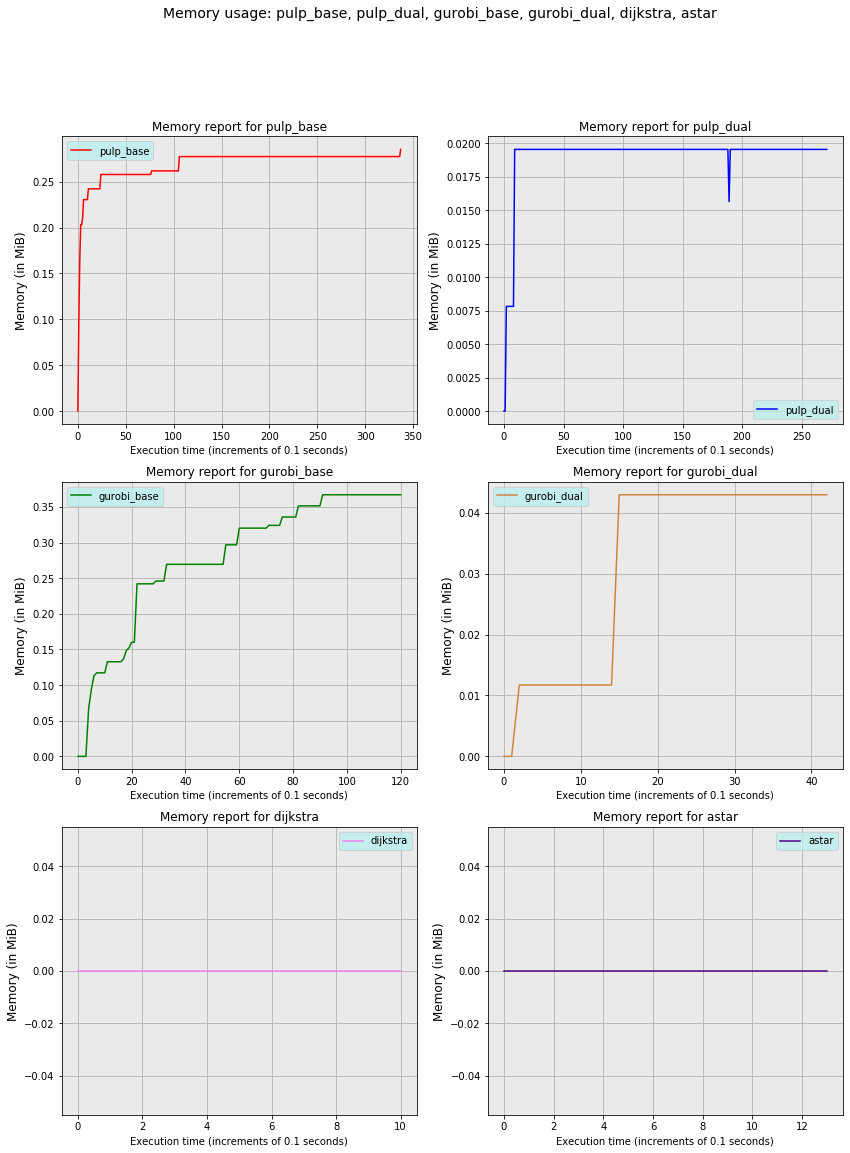

In [47]:
six_subplot_memory_report(pulp_base_1e1_memory, pulp_dual_1e1_memory, gurobi_base_1e1_memory, gurobi_dual_1e1_memory, dijkstra_1e1_memory, astar_1e1_memory,
                          "pulp_base", "pulp_dual", "gurobi_base", "gurobi_dual", "dijkstra", "astar")

Peak usage for pulp_base   	   0.285156
Peak usage for pulp_dual   	   0.019531
Peak usage for gurobi_base 	   0.367188
Peak usage for gurobi_dual 	   0.042969
Peak usage for dijkstra    	   0.000000
Peak usage for astar       	   0.000000



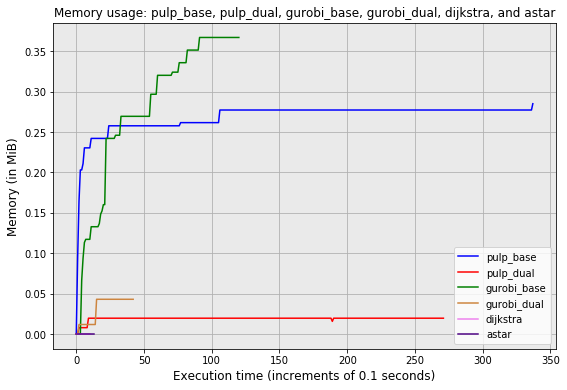

In [48]:
six_way_memory_report(pulp_base_1e1_memory, pulp_dual_1e1_memory, gurobi_base_1e1_memory, gurobi_dual_1e1_memory, dijkstra_1e1_memory, astar_1e1_memory,
                          "pulp_base", "pulp_dual", "gurobi_base", "gurobi_dual", "dijkstra", "astar")

In [49]:
# Behind the scenes, the PROF_DATA dataframe has been timing each trial
# This tuple shows that those data are waiting for us, and can already yield their secrets

np.mean(PROF_DATA["pulp_base_trial"][1]), np.std(PROF_DATA["pulp_base_trial"][1])

(0.03309407884179694, 0.00393731630109231)

In [50]:
pulp_base_time_square = PROF_DATA["pulp_base_trial"][1][-NUM_RUNS:]  # Odd way to extract the last 1024 values!
pulp_dual_time_square = PROF_DATA["pulp_dual_trial"][1][-NUM_RUNS:]
gurobi_base_time_square = PROF_DATA["gurobi_base_trial"][1][-NUM_RUNS:]
gurobi_dual_time_square = PROF_DATA["gurobi_dual_trial"][1][-NUM_RUNS:]
dijkstra_time_square = PROF_DATA["dijkstra_trial"][1][-NUM_RUNS:]
astar_time_square = PROF_DATA["astar_trial"][1][-NUM_RUNS:]

In [51]:
# Reshape the data for purposes of (vivid!) display

pulp_base_square = np.zeros((32, 32), dtype = float)
pulp_dual_square = np.zeros((32, 32), dtype = float)
gurobi_base_square = np.zeros((32, 32), dtype = float)
gurobi_dual_square = np.zeros((32, 32), dtype = float)
dijkstra_square = np.zeros((32, 32), dtype = float)
astar_square = np.zeros((32, 32), dtype = float)

solution_1e1_square = np.zeros((32, 32), dtype = float)
count = 0

for i in range(32):
    for j in range(32):
        pulp_base_square[i, j] = pulp_base_time_square[count]
        pulp_dual_square[i, j] = pulp_dual_time_square[count]
        gurobi_base_square[i, j] = gurobi_base_time_square[count]
        gurobi_dual_square[i, j] = gurobi_dual_time_square[count]
        dijkstra_square[i, j] = dijkstra_time_square[count]
        astar_square[i, j] = astar_time_square[count]
        
        solution_1e1_square[i, j] = pulp_base_1e1[count]
        count += 1

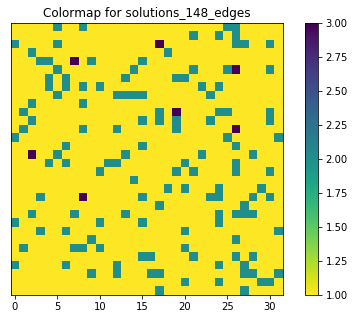

In [225]:
single_colormap(solution_1e1_square, "solutions_148_edges", colormap = "viridis_r")

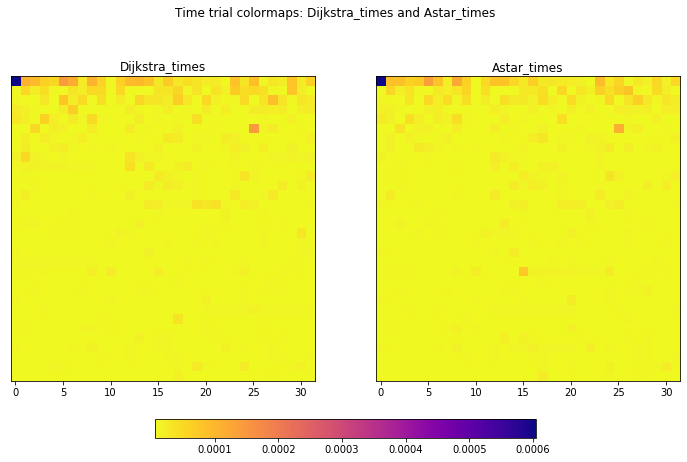

In [53]:
colormap_subplots(dijkstra_square, astar_square, "Dijkstra_times", "Astar_times")

In [54]:
# np.maximum(pulp_base_square, pulp_dual_square).max()
np.maximum.reduce([pulp_base_square, pulp_dual_square, gurobi_base_square, gurobi_dual_square, dijkstra_square, astar_square]).max()

# .any() and gurobi_base_square.any()) # + gurobi_dual_square.all() + dijkstra_square.all() + astar_square.all())

0.2692330330000061

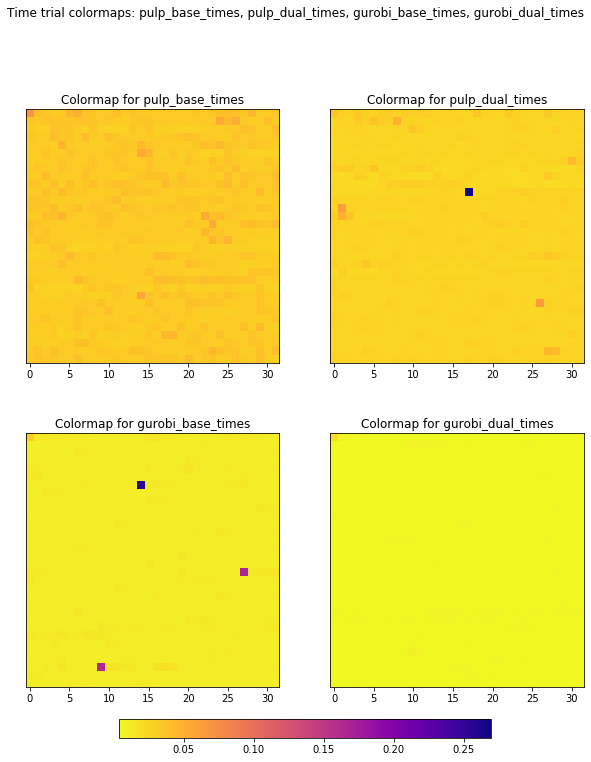

In [55]:
four_subplot_colormap(pulp_base_square, pulp_dual_square, gurobi_base_square, gurobi_dual_square,
                     "pulp_base_times", "pulp_dual_times", "gurobi_base_times", "gurobi_dual_times")

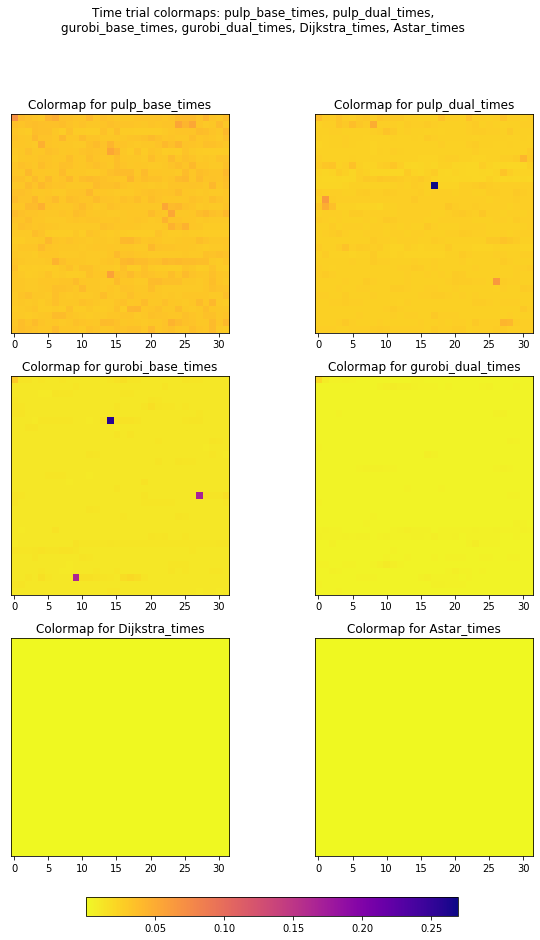

In [56]:
six_subplot_colormap(pulp_base_square, pulp_dual_square, gurobi_base_square, gurobi_dual_square, dijkstra_square, astar_square,
                     "pulp_base_times", "pulp_dual_times", "gurobi_base_times", "gurobi_dual_times",
                     "Dijkstra_times", "Astar_times")

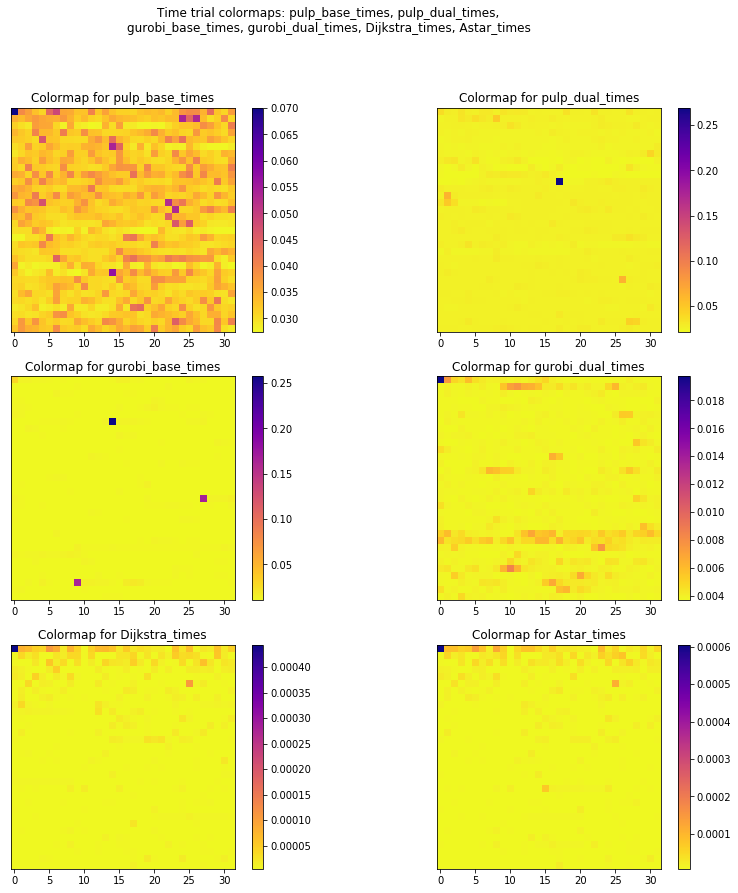

In [57]:
original_six_subplot_colormap(pulp_base_square, pulp_dual_square, gurobi_base_square, gurobi_dual_square, dijkstra_square, astar_square,
                     "pulp_base_times", "pulp_dual_times", "gurobi_base_times", "gurobi_dual_times",
                     "Dijkstra_times", "Astar_times")

## Scale it up: Moving to the exp(6) ≈ 403-edge instance!

In [58]:
pulp_base_1e2   = np.zeros(NUM_RUNS, dtype = float)
pulp_dual_1e2   = np.zeros(NUM_RUNS, dtype = float)
gurobi_base_1e2 = np.zeros(NUM_RUNS, dtype = float)
gurobi_dual_1e2 = np.zeros(NUM_RUNS, dtype = float)
dijkstra_1e2    = np.zeros(NUM_RUNS, dtype = float)
astar_1e2       = np.zeros(NUM_RUNS, dtype = float)

In [59]:
# Pulp base time trials!

@profile("pulp_base")
def pulp_base_trial_1e2(i):
    start_node_key = start_nodes_keys_list_2[i]
    end_node_key = end_nodes_keys_list_2[i]
    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_2, sampled_edges_2, start_node_key, end_node_key)
    prob = define_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_LP(prob)
    return clicks

def thousand_pulp_base_trials_1e2():
    global pulp_base_1e2
    for i in range(0, NUM_RUNS):
        this_path = pulp_base_trial_1e2(i)
        pulp_base_1e2[i] = this_path
    
# Memory tracking
pulp_base_1e2_memory = memory_usage(thousand_pulp_base_trials_1e2, interval = MEMORY_INTERVAL)

In [60]:
# Pulp dual time trials!

@profile("pulp_dual")
def pulp_dual_trial_1e2(i):
    start_node_key = start_nodes_keys_list_2[i]
    end_node_key = end_nodes_keys_list_2[i]
    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_2, sampled_edges_2, start_node_key, end_node_key)
    prob = define_dual_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_LP(prob)
    return clicks

def thousand_pulp_dual_trials_1e2():
    global pulp_dual_1e2
    for i in range(0, NUM_RUNS):
        this_path = pulp_dual_trial_1e2(i)
        pulp_dual_1e2[i] = this_path
    
# Memory tracking
pulp_dual_1e2_memory = memory_usage(thousand_pulp_dual_trials_1e2, interval = MEMORY_INTERVAL)

In [61]:
# Gurobi base time trials!

@profile("gurobi_base")
def gurobi_base_trial_1e2(i):
    start_node_key = start_nodes_keys_list_2[i]
    end_node_key = end_nodes_keys_list_2[i]
    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_2, sampled_edges_2, start_node_key, end_node_key)
    prob = define_gurobi_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_gurobi_lp(prob)
    return clicks

def thousand_gurobi_base_trials_1e2():
    global gurobi_base_1e2
    for i in range(0, NUM_RUNS):
        this_path = gurobi_base_trial_1e2(i)
        gurobi_base_1e2[i] = this_path
    
# Memory tracking
gurobi_base_1e2_memory = memory_usage(thousand_gurobi_base_trials_1e2, interval = MEMORY_INTERVAL)

In [62]:
# Gurobi dual time trials!

@profile("gurobi_dual")
def gurobi_dual_trial_1e2(i):
    start_node_key = start_nodes_keys_list_2[i]
    end_node_key = end_nodes_keys_list_2[i]
    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_2, sampled_edges_2, start_node_key, end_node_key)
    prob = define_gurobi_dual_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_gurobi_dual_lp(prob)
    return clicks

def thousand_gurobi_dual_trials_1e2():
    global gurobi_dual_1e2
    for i in range(0, NUM_RUNS):
        this_path = gurobi_dual_trial_1e2(i)
        gurobi_dual_1e2[i] = this_path
    
# Memory tracking
gurobi_dual_1e2_memory = memory_usage(thousand_gurobi_dual_trials_1e2, interval = MEMORY_INTERVAL)

In [63]:
# Dijkstra time trials!

@profile("dijkstra")
def dijkstra_trial_1e2(i): 
    start_node_key = start_nodes_keys_list_2[i]  # was: "start_nodes_keys_list" — This generated an error
    end_node_key = end_nodes_keys_list_2[i]  # Same issue as the previous line
    try:
        shortest_path = nx.dijkstra_path(H_2, source = start_node_key, target = end_node_key)
        path_length = len(shortest_path) - 1
    except:
        path_length = 0
    return path_length

def thousand_dijkstra_trials_1e2():
    global dijkstra_1e2
    for i in range(0, NUM_RUNS):
        # this_path = dijkstra_trial_1e2(i)
        dijkstra_1e2[i] = dijkstra_trial_1e2(i)
    
# Memory tracking
dijkstra_1e2_memory = memory_usage(thousand_dijkstra_trials_1e2, interval = MEMORY_INTERVAL)

In [64]:
# A* time trials!

@profile("astar")
def astar_trial_1e2(i): 
    start_node_key = start_nodes_keys_list_2[i]  # was: "start_nodes_keys_list" — This generated an error
    end_node_key = end_nodes_keys_list_2[i]  # Same issue as the previous line
    try:
        shortest_path = nx.astar_path(H_2, source = start_node_key, target = end_node_key)
        path_length = len(shortest_path) - 1
    except:
        path_length = 0
    return path_length


def thousand_astar_trials_1e2():
    global astar_1e2
    for i in range(0, NUM_RUNS):
        # this_path = astar_trial_1e2(i)  # Avoid double-counting, perhaps?
        astar_1e2[i] = astar_trial_1e2(i)
    
# Memory tracking
astar_1e2_memory = memory_usage(thousand_astar_trials_1e2, interval = MEMORY_INTERVAL)

In [65]:
for array in (pulp_base_1e2, pulp_dual_1e2, gurobi_base_1e2, gurobi_dual_1e2, dijkstra_1e2, astar_1e2):
    print(array.mean(), array.std(), array.max(), array.min())

1.236328125 0.4472229783161688 3.0 1.0
1.236328125 0.4472229783161688 3.0 1.0
1.236328125 0.4472229783161688 3.0 1.0
1.236328125 0.4472229783161688 3.0 1.0
1.236328125 0.4472229783161688 3.0 1.0
1.236328125 0.4472229783161688 3.0 1.0


Peak usage for pulp_base_1e2	  10.414062
Peak usage for pulp_dual_1e2	   0.015625
Peak usage for gurobi_base_1e2	  43.777344
Peak usage for gurobi_dual_1e2	   0.011719
Peak usage for dijkstra_1e2	   0.003906
Peak usage for astar_1e2   	   0.000000



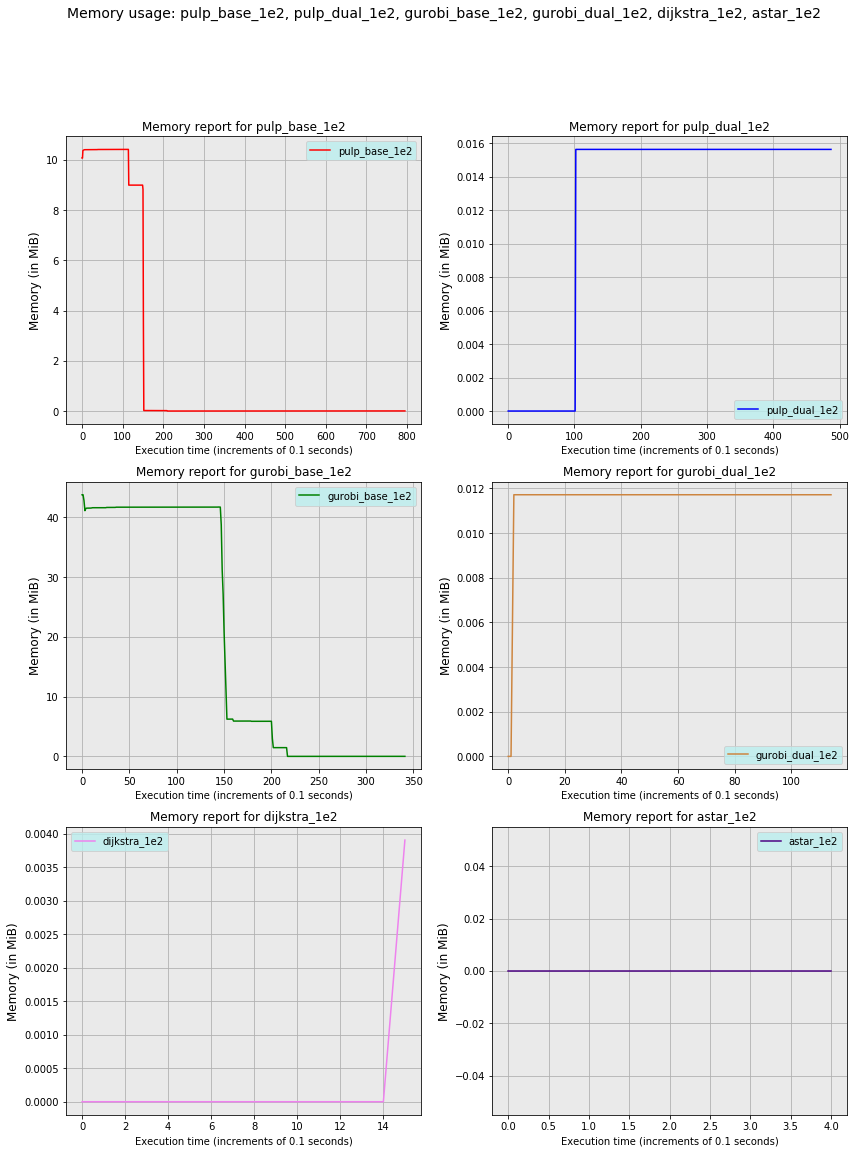

In [66]:
six_subplot_memory_report(pulp_base_1e2_memory, pulp_dual_1e2_memory, gurobi_base_1e2_memory,
                          gurobi_dual_1e2_memory, dijkstra_1e2_memory, astar_1e2_memory,
                          "pulp_base_1e2", "pulp_dual_1e2", "gurobi_base_1e2",
                          "gurobi_dual_1e2", "dijkstra_1e2", "astar_1e2")

In [67]:
pulp_base_1e2_time_square = PROF_DATA["pulp_base_trial_1e2"][1][-NUM_RUNS:]
pulp_dual_1e2_time_square = PROF_DATA["pulp_dual_trial_1e2"][1][-NUM_RUNS:]
gurobi_base_1e2_time_square = PROF_DATA["gurobi_base_trial_1e2"][1][-NUM_RUNS:]
gurobi_dual_1e2_time_square = PROF_DATA["gurobi_dual_trial_1e2"][1][-NUM_RUNS:]
dijkstra_1e2_time_square = PROF_DATA["dijkstra_trial_1e2"][1][-NUM_RUNS:]
astar_1e2_time_square = PROF_DATA["astar_trial_1e2"][1][-NUM_RUNS:]

In [68]:
pulp_base_1e2_square = np.zeros((32, 32), dtype = float)
pulp_dual_1e2_square = np.zeros((32, 32), dtype = float)
gurobi_base_1e2_square = np.zeros((32, 32), dtype = float)
gurobi_dual_1e2_square = np.zeros((32, 32), dtype = float)
dijkstra_1e2_square = np.zeros((32, 32), dtype = float)
astar_1e2_square = np.zeros((32, 32), dtype = float)

solution_1e2_square = np.zeros((32, 32), dtype = float)
count = 0

for i in range(32):
    for j in range(32):
        pulp_base_1e2_square[i, j] = pulp_base_1e2_time_square[count]
        pulp_dual_1e2_square[i, j] = pulp_dual_1e2_time_square[count]
        gurobi_base_1e2_square[i, j] = gurobi_base_1e2_time_square[count]
        gurobi_dual_1e2_square[i, j] = gurobi_dual_1e2_time_square[count]
        dijkstra_1e2_square[i, j] = dijkstra_1e2_time_square[count]
        astar_1e2_square[i, j] = astar_1e2_time_square[count]
        
        solution_1e2_square[i, j] = pulp_base_1e2[count]
        count += 1

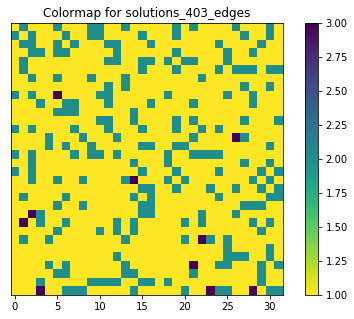

In [226]:
single_colormap(solution_1e2_square, "solutions_403_edges", colormap = "viridis_r")

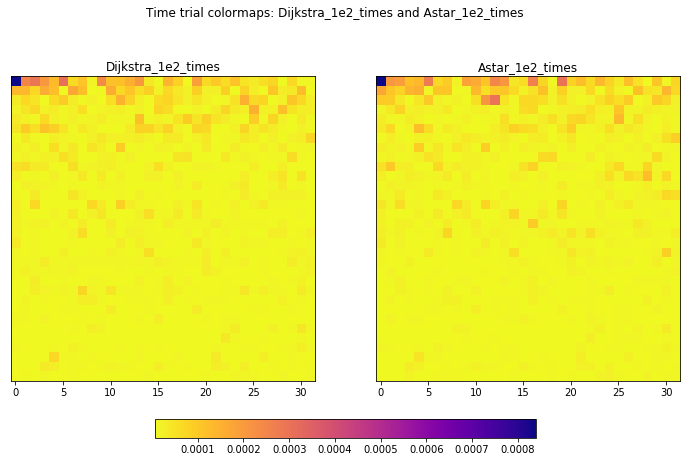

In [70]:
colormap_subplots(dijkstra_1e2_square, astar_1e2_square, "Dijkstra_1e2_times", "Astar_1e2_times")

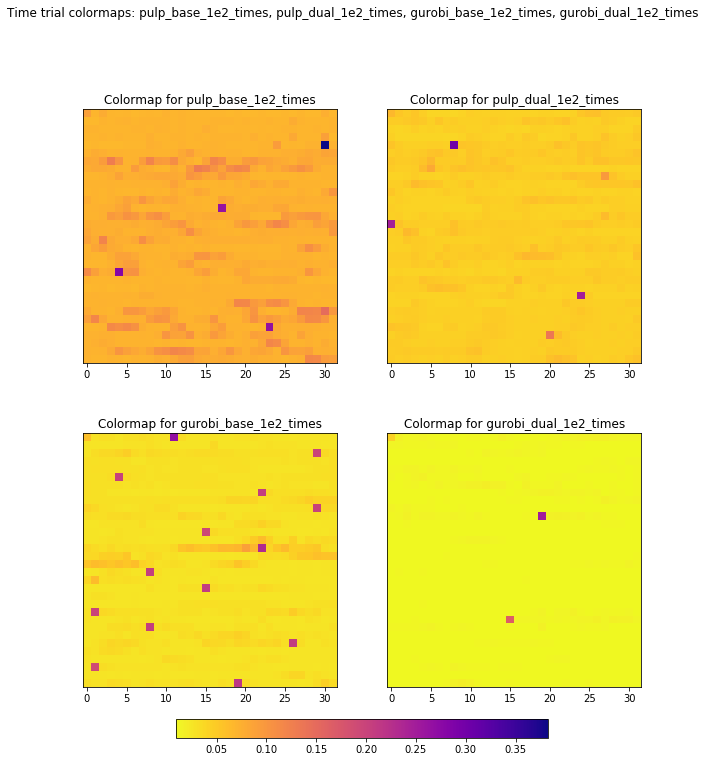

In [71]:
four_subplot_colormap(pulp_base_1e2_square, pulp_dual_1e2_square, gurobi_base_1e2_square, gurobi_dual_1e2_square,
                     "pulp_base_1e2_times", "pulp_dual_1e2_times", "gurobi_base_1e2_times", "gurobi_dual_1e2_times")

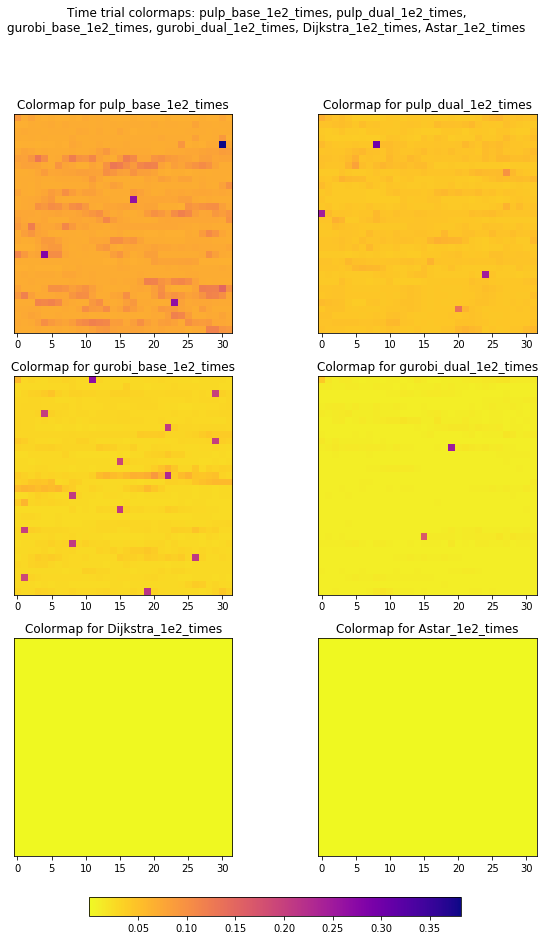

In [72]:
six_subplot_colormap(pulp_base_1e2_square, pulp_dual_1e2_square, gurobi_base_1e2_square,
                     gurobi_dual_1e2_square, dijkstra_1e2_square, astar_1e2_square,
                     "pulp_base_1e2_times", "pulp_dual_1e2_times", "gurobi_base_1e2_times",
                     "gurobi_dual_1e2_times", "Dijkstra_1e2_times", "Astar_1e2_times")

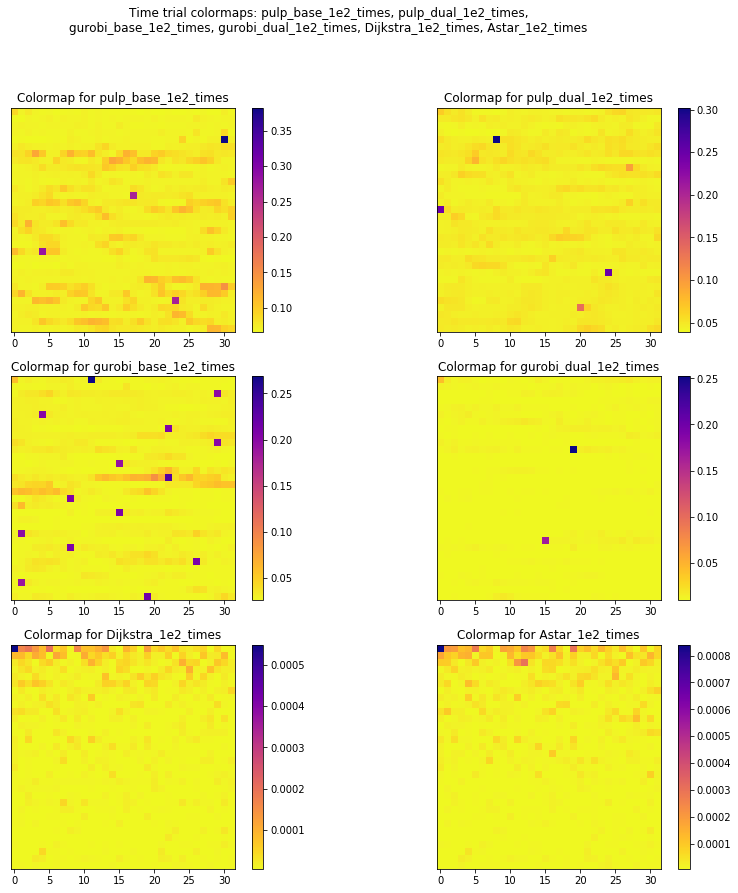

In [73]:
original_six_subplot_colormap(pulp_base_1e2_square, pulp_dual_1e2_square, gurobi_base_1e2_square,
                              gurobi_dual_1e2_square, dijkstra_1e2_square, astar_1e2_square,
                              "pulp_base_1e2_times", "pulp_dual_1e2_times", "gurobi_base_1e2_times",
                              "gurobi_dual_1e2_times", "Dijkstra_1e2_times", "Astar_1e2_times")

## Third round: exp(7) ≈ 1,097-edge instance

In [74]:
pulp_base_1e3   = np.zeros(NUM_RUNS, dtype = float)
pulp_dual_1e3   = np.zeros(NUM_RUNS, dtype = float)
gurobi_base_1e3 = np.zeros(NUM_RUNS, dtype = float)
gurobi_dual_1e3 = np.zeros(NUM_RUNS, dtype = float)
dijkstra_1e3    = np.zeros(NUM_RUNS, dtype = float)
astar_1e3       = np.zeros(NUM_RUNS, dtype = float)

In [75]:
# Pulp base time trials!

@profile("pulp_base")
def pulp_base_trial_1e3(i):
    start_node_key = start_nodes_keys_list_3[i]
    end_node_key = end_nodes_keys_list_3[i]
    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_3, sampled_edges_3, start_node_key, end_node_key)
    prob = define_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_LP(prob)
    return clicks

def thousand_pulp_base_trials_1e3():
    global pulp_base_1e3
    for i in range(0, NUM_RUNS):
        this_path = pulp_base_trial_1e3(i)
        pulp_base_1e3[i] = this_path
    
# Memory tracking
pulp_base_1e3_memory = memory_usage(thousand_pulp_base_trials_1e3, interval = MEMORY_INTERVAL)

In [76]:
# Pulp dual time trials!

@profile("pulp_dual")
def pulp_dual_trial_1e3(i):
    start_node_key = start_nodes_keys_list_3[i]
    end_node_key = end_nodes_keys_list_3[i]
    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_3, sampled_edges_3, start_node_key, end_node_key)
    prob = define_dual_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_LP(prob)
    return clicks

def thousand_pulp_dual_trials_1e3():
    global pulp_dual_1e3
    for i in range(0, NUM_RUNS):
        this_path = pulp_dual_trial_1e3(i)
        pulp_dual_1e3[i] = this_path
    
# Memory tracking
pulp_dual_1e3_memory = memory_usage(thousand_pulp_dual_trials_1e3, interval = MEMORY_INTERVAL)

In [77]:
# Gurobi base time trials!

@profile("gurobi_base")
def gurobi_base_trial_1e3(i):
    start_node_key = start_nodes_keys_list_3[i]
    end_node_key = end_nodes_keys_list_3[i]
    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_3, sampled_edges_3, start_node_key, end_node_key)
    prob = define_gurobi_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_gurobi_lp(prob)
    return clicks

def thousand_gurobi_base_trials_1e3():
    global gurobi_base_1e3
    for i in range(0, NUM_RUNS):
        this_path = gurobi_base_trial_1e3(i)
        gurobi_base_1e3[i] = this_path
    
# Memory tracking
gurobi_base_1e3_memory = memory_usage(thousand_gurobi_base_trials_1e3, interval = MEMORY_INTERVAL)

In [78]:
# Gurobi dual time trials!

@profile("gurobi_dual")
def gurobi_dual_trial_1e3(i):
    start_node_key = start_nodes_keys_list_3[i]
    end_node_key = end_nodes_keys_list_3[i]
    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_3, sampled_edges_3, start_node_key, end_node_key)
    prob = define_gurobi_dual_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_gurobi_dual_lp(prob)
    return clicks

def thousand_gurobi_dual_trials_1e3():
    global gurobi_dual_1e3
    for i in range(0, NUM_RUNS):
        this_path = gurobi_dual_trial_1e3(i)
        gurobi_dual_1e3[i] = this_path
    
# Memory tracking
gurobi_dual_1e3_memory = memory_usage(thousand_gurobi_dual_trials_1e3, interval = MEMORY_INTERVAL)

In [79]:
# Dijkstra time trials!

@profile("dijkstra")
def dijkstra_trial_1e3(i): 
    start_node_key = start_nodes_keys_list_3[i]  # was: "start_nodes_keys_list" — This generated an error
    end_node_key = end_nodes_keys_list_3[i]  # Same issue as the previous line
    try:
        shortest_path = nx.dijkstra_path(H_3, source = start_node_key, target = end_node_key)
        path_length = len(shortest_path) - 1
    except:
        path_length = 0
    return path_length

def thousand_dijkstra_trials_1e3():
    global dijkstra_1e3
    for i in range(0, NUM_RUNS):
        # this_path = dijkstra_trial_1e3(i)
        dijkstra_1e3[i] = dijkstra_trial_1e3(i)
    
# Memory tracking
dijkstra_1e3_memory = memory_usage(thousand_dijkstra_trials_1e3, interval = MEMORY_INTERVAL)

In [80]:
# A* time trials!

@profile("astar")
def astar_trial_1e3(i): 
    start_node_key = start_nodes_keys_list_3[i]  # was: "start_nodes_keys_list" — This generated an error
    end_node_key = end_nodes_keys_list_3[i]  # Same issue as the previous line
    try:
        shortest_path = nx.astar_path(H_3, source = start_node_key, target = end_node_key)
        path_length = len(shortest_path) - 1
    except:
        path_length = 0
    return path_length


def thousand_astar_trials_1e3():
    global astar_1e3
    for i in range(0, NUM_RUNS):
        # this_path = astar_trial_1e3(i)
        astar_1e3[i] = astar_trial_1e3(i)
    
# Memory tracking
astar_1e3_memory = memory_usage(thousand_astar_trials_1e3, interval = MEMORY_INTERVAL)

In [81]:
for array in (pulp_base_1e3, pulp_dual_1e3, gurobi_base_1e3, gurobi_dual_1e3, dijkstra_1e3, astar_1e3):
    print(array.mean(), array.std(), array.max(), array.min())

1.7333984375 0.9813782626350345 8.0 1.0
1.7333984375 0.9813782626350345 8.0 1.0
1.7333984375 0.9813782626350345 8.0 1.0
1.7333984375 0.9813782626350345 8.0 1.0
1.7333984375 0.9813782626350345 8.0 1.0
1.7333984375 0.9813782626350345 8.0 1.0


Peak usage for pulp_base_1e3	 105.453125
Peak usage for pulp_dual_1e3	  16.773438
Peak usage for gurobi_base_1e3	   6.335938
Peak usage for gurobi_dual_1e3	   0.308594
Peak usage for dijkstra_1e3	   0.000000
Peak usage for astar_1e3   	   0.000000



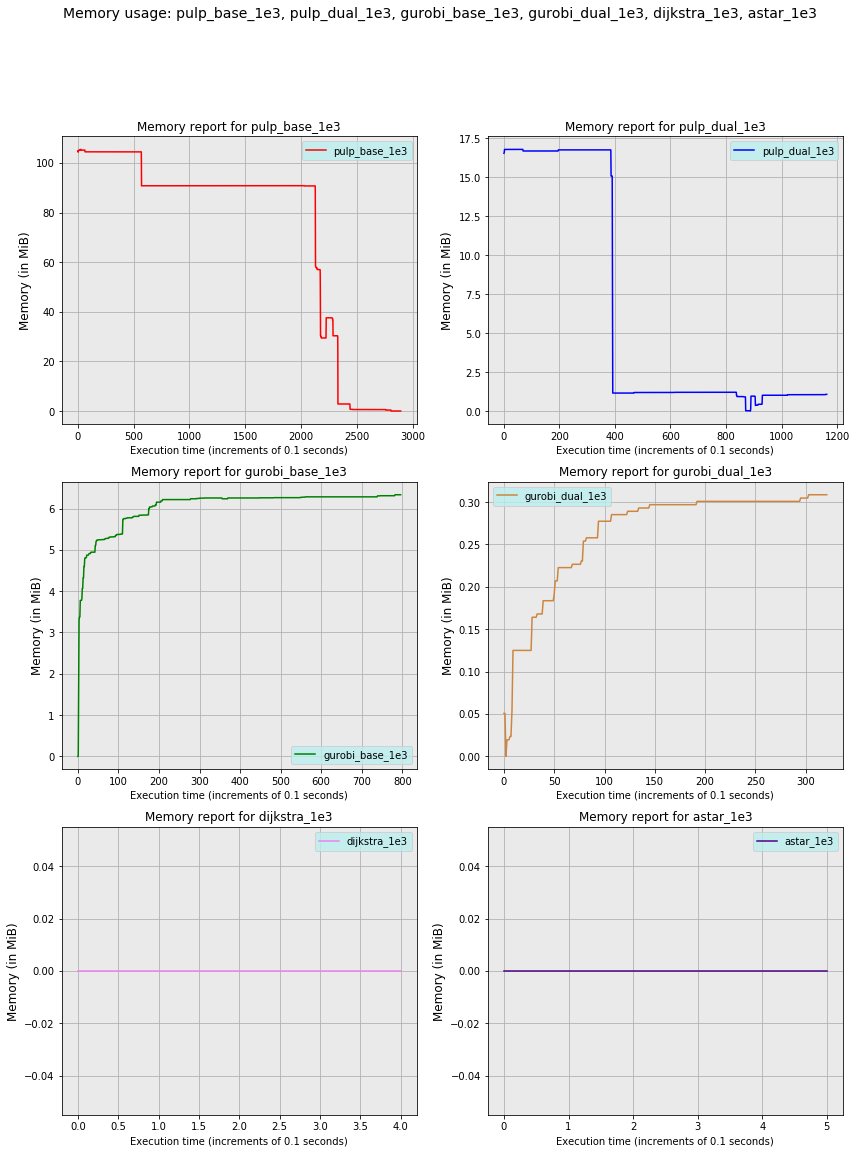

In [82]:
six_subplot_memory_report(pulp_base_1e3_memory, pulp_dual_1e3_memory, gurobi_base_1e3_memory,
                          gurobi_dual_1e3_memory, dijkstra_1e3_memory, astar_1e3_memory,
                          "pulp_base_1e3", "pulp_dual_1e3", "gurobi_base_1e3",
                          "gurobi_dual_1e3", "dijkstra_1e3", "astar_1e3")

In [83]:
pulp_base_1e3_time_square = PROF_DATA["pulp_base_trial_1e3"][1][-NUM_RUNS:]
pulp_dual_1e3_time_square = PROF_DATA["pulp_dual_trial_1e3"][1][-NUM_RUNS:]
gurobi_base_1e3_time_square = PROF_DATA["gurobi_base_trial_1e3"][1][-NUM_RUNS:]
gurobi_dual_1e3_time_square = PROF_DATA["gurobi_dual_trial_1e3"][1][-NUM_RUNS:]
dijkstra_1e3_time_square = PROF_DATA["dijkstra_trial_1e3"][1][-NUM_RUNS:]
astar_1e3_time_square = PROF_DATA["astar_trial_1e3"][1][-NUM_RUNS:]

In [84]:
pulp_base_1e3_square = np.zeros((32, 32), dtype = float)
pulp_dual_1e3_square = np.zeros((32, 32), dtype = float)
gurobi_base_1e3_square = np.zeros((32, 32), dtype = float)
gurobi_dual_1e3_square = np.zeros((32, 32), dtype = float)
dijkstra_1e3_square = np.zeros((32, 32), dtype = float)
astar_1e3_square = np.zeros((32, 32), dtype = float)

solution_1e3_square = np.zeros((32, 32), dtype = float)
count = 0

for i in range(32):
    for j in range(32):
        pulp_base_1e3_square[i, j] = pulp_base_1e3_time_square[count]
        pulp_dual_1e3_square[i, j] = pulp_dual_1e3_time_square[count]
        gurobi_base_1e3_square[i, j] = gurobi_base_1e3_time_square[count]
        gurobi_dual_1e3_square[i, j] = gurobi_dual_1e3_time_square[count]
        dijkstra_1e3_square[i, j] = dijkstra_1e3_time_square[count]
        astar_1e3_square[i, j] = astar_1e3_time_square[count]
        
        solution_1e3_square[i, j] = pulp_base_1e3[count]
        count += 1

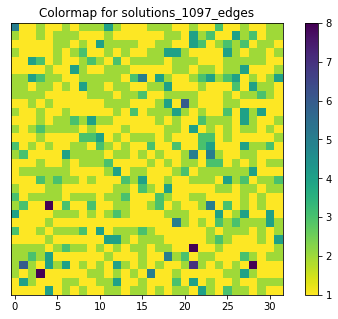

In [227]:
single_colormap(solution_1e3_square, "solutions_1097_edges", colormap = "viridis_r")

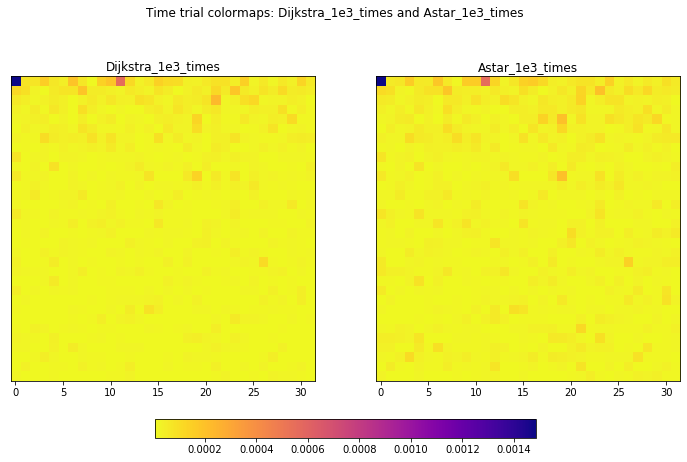

In [86]:
colormap_subplots(dijkstra_1e3_square, astar_1e3_square, "Dijkstra_1e3_times", "Astar_1e3_times")

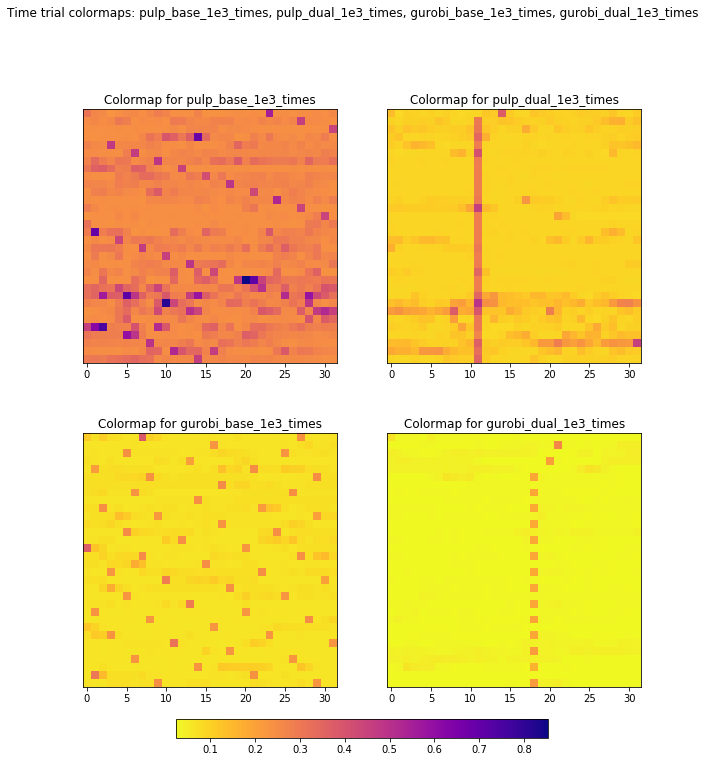

In [87]:
four_subplot_colormap(pulp_base_1e3_square, pulp_dual_1e3_square, gurobi_base_1e3_square, gurobi_dual_1e3_square,
                     "pulp_base_1e3_times", "pulp_dual_1e3_times", "gurobi_base_1e3_times", "gurobi_dual_1e3_times")

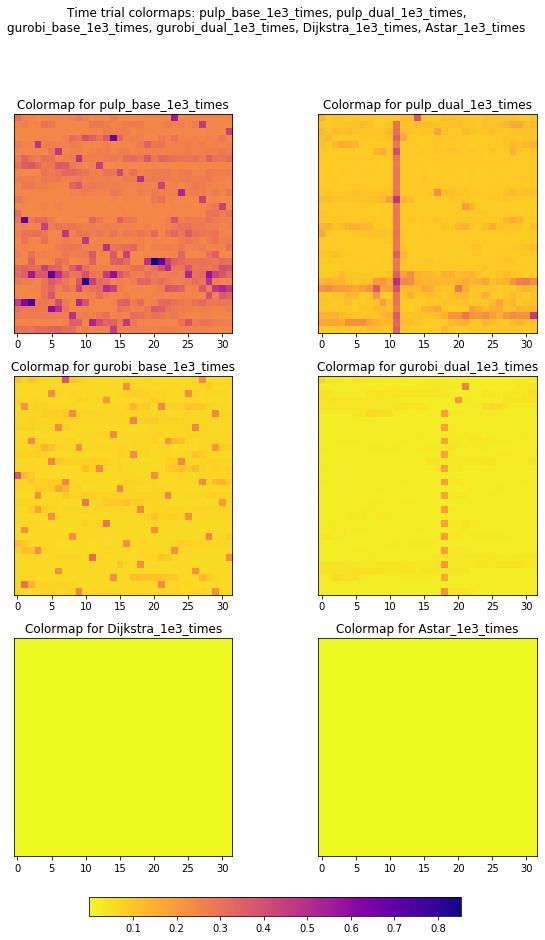

In [88]:
six_subplot_colormap(pulp_base_1e3_square, pulp_dual_1e3_square, gurobi_base_1e3_square,
                     gurobi_dual_1e3_square, dijkstra_1e3_square, astar_1e3_square,
                     "pulp_base_1e3_times", "pulp_dual_1e3_times", "gurobi_base_1e3_times",
                     "gurobi_dual_1e3_times", "Dijkstra_1e3_times", "Astar_1e3_times")

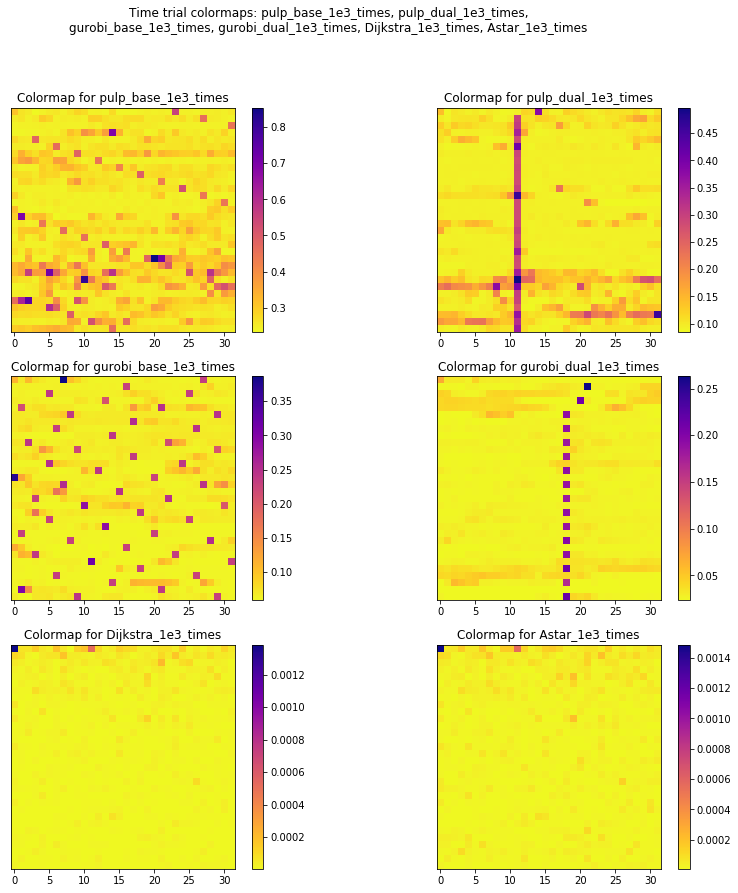

In [89]:
original_six_subplot_colormap(pulp_base_1e3_square, pulp_dual_1e3_square, gurobi_base_1e3_square,
                              gurobi_dual_1e3_square, dijkstra_1e3_square, astar_1e3_square,
                              "pulp_base_1e3_times", "pulp_dual_1e3_times", "gurobi_base_1e3_times",
                              "gurobi_dual_1e3_times", "Dijkstra_1e3_times", "Astar_1e3_times")

## The big, 2,981-edge instance

### This is equivalent to exp(8) ≈ 2,981

In [90]:
pulp_base_1e4   = np.zeros(NUM_RUNS, dtype = float)
pulp_dual_1e4   = np.zeros(NUM_RUNS, dtype = float)
gurobi_base_1e4 = np.zeros(NUM_RUNS, dtype = float)
gurobi_dual_1e4 = np.zeros(NUM_RUNS, dtype = float)
dijkstra_1e4    = np.zeros(NUM_RUNS, dtype = float)
astar_1e4       = np.zeros(NUM_RUNS, dtype = float)

In [91]:
# Pulp base time trials!

@profile("pulp_base")
def pulp_base_trial_1e4(i):
    start_node_key = start_nodes_keys_list_4[i]
    end_node_key = end_nodes_keys_list_4[i]
    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_4, sampled_edges_4, start_node_key, end_node_key)
    prob = define_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_LP(prob)
    return clicks

def thousand_pulp_base_trials_1e4():
    global pulp_base_1e4
    for i in range(0, NUM_RUNS):
        this_path = pulp_base_trial_1e4(i)
        pulp_base_1e4[i] = this_path
    
# Memory tracking
pulp_base_1e4_memory = memory_usage(thousand_pulp_base_trials_1e4, interval = MEMORY_INTERVAL)

In [92]:
# Pulp dual time trials!

@profile("pulp_dual")
def pulp_dual_trial_1e4(i):
    start_node_key = start_nodes_keys_list_4[i]
    end_node_key = end_nodes_keys_list_4[i]
    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_4, sampled_edges_4, start_node_key, end_node_key)
    prob = define_dual_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_LP(prob)
    return clicks

def thousand_pulp_dual_trials_1e4():
    global pulp_dual_1e4
    for i in range(0, NUM_RUNS):
        this_path = pulp_dual_trial_1e4(i)
        pulp_dual_1e4[i] = this_path
    
# Memory tracking
pulp_dual_1e4_memory = memory_usage(thousand_pulp_dual_trials_1e4, interval = MEMORY_INTERVAL)

In [93]:
# Gurobi base time trials!

@profile("gurobi_base")
def gurobi_base_trial_1e4(i):
    start_node_key = start_nodes_keys_list_4[i]
    end_node_key = end_nodes_keys_list_4[i]
    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_4, sampled_edges_4, start_node_key, end_node_key)
    prob = define_gurobi_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_gurobi_lp(prob)
    return clicks

def thousand_gurobi_base_trials_1e4():
    global gurobi_base_1e4
    for i in range(0, NUM_RUNS):
        this_path = gurobi_base_trial_1e4(i)
        gurobi_base_1e4[i] = this_path
    
# Memory tracking
gurobi_base_1e4_memory = memory_usage(thousand_gurobi_base_trials_1e4, interval = MEMORY_INTERVAL)

In [94]:
# Gurobi dual time trials!

@profile("gurobi_dual")
def gurobi_dual_trial_1e4(i):
    start_node_key = start_nodes_keys_list_4[i]
    end_node_key = end_nodes_keys_list_4[i]
    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_4, sampled_edges_4, start_node_key, end_node_key)
    prob = define_gurobi_dual_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_gurobi_dual_lp(prob)
    return clicks

def thousand_gurobi_dual_trials_1e4():
    global gurobi_dual_1e4
    for i in range(0, NUM_RUNS):
        this_path = gurobi_dual_trial_1e4(i)
        gurobi_dual_1e4[i] = this_path
    
# Memory tracking
gurobi_dual_1e4_memory = memory_usage(thousand_gurobi_dual_trials_1e4, interval = MEMORY_INTERVAL)

In [95]:
# Dijkstra time trials!

@profile("dijkstra")
def dijkstra_trial_1e4(i): 
    start_node_key = start_nodes_keys_list_4[i]  # was: "start_nodes_keys_list" — This generated an error
    end_node_key = end_nodes_keys_list_4[i]  # Same issue as the previous line
    try:
        shortest_path = nx.dijkstra_path(H_4, source = start_node_key, target = end_node_key)
        path_length = len(shortest_path) - 1
    except:
        path_length = 0
    return path_length

def thousand_dijkstra_trials_1e4():
    global dijkstra_1e4
    for i in range(0, NUM_RUNS):
        # this_path = dijkstra_trial_1e4(i)
        dijkstra_1e4[i] = dijkstra_trial_1e4(i)
    
# Memory tracking
dijkstra_1e4_memory = memory_usage(thousand_dijkstra_trials_1e4, interval = MEMORY_INTERVAL)

In [96]:
# A* time trials!

@profile("astar")
def astar_trial_1e4(i): 
    start_node_key = start_nodes_keys_list_4[i]  # was: "start_nodes_keys_list" — This generated an error
    end_node_key = end_nodes_keys_list_4[i]  # Same issue as the previous line
    try:
        shortest_path = nx.astar_path(H_4, source = start_node_key, target = end_node_key)
        path_length = len(shortest_path) - 1
    except:
        path_length = 0
    return path_length

def thousand_astar_trials_1e4():
    global astar_1e4
    for i in range(0, NUM_RUNS):
        # this_path = astar_trial_1e4(i)
        astar_1e4[i] = astar_trial_1e4(i)
    
# Memory tracking
astar_1e4_memory = memory_usage(thousand_astar_trials_1e4, interval = MEMORY_INTERVAL)

In [97]:
for array in (pulp_base_1e4, pulp_dual_1e4, gurobi_base_1e4, gurobi_dual_1e4, dijkstra_1e4, astar_1e4):
    print(array.mean(), array.std(), array.max(), array.min())

8.4853515625 10.281572006423863 40.0 1.0
8.4853515625 10.281572006423863 40.0 1.0
8.4853515625 10.281572006423863 40.0 1.0
8.4853515625 10.281572006423863 40.0 1.0
8.4853515625 10.281572006423863 40.0 1.0
8.4853515625 10.281572006423863 40.0 1.0


Peak usage for pulp_base_1e4	 143.289062
Peak usage for pulp_dual_1e4	   0.753906
Peak usage for gurobi_base_1e4	  80.910156
Peak usage for gurobi_dual_1e4	   0.652344
Peak usage for dijkstra_1e4	   0.093750
Peak usage for astar_1e4   	   0.035156



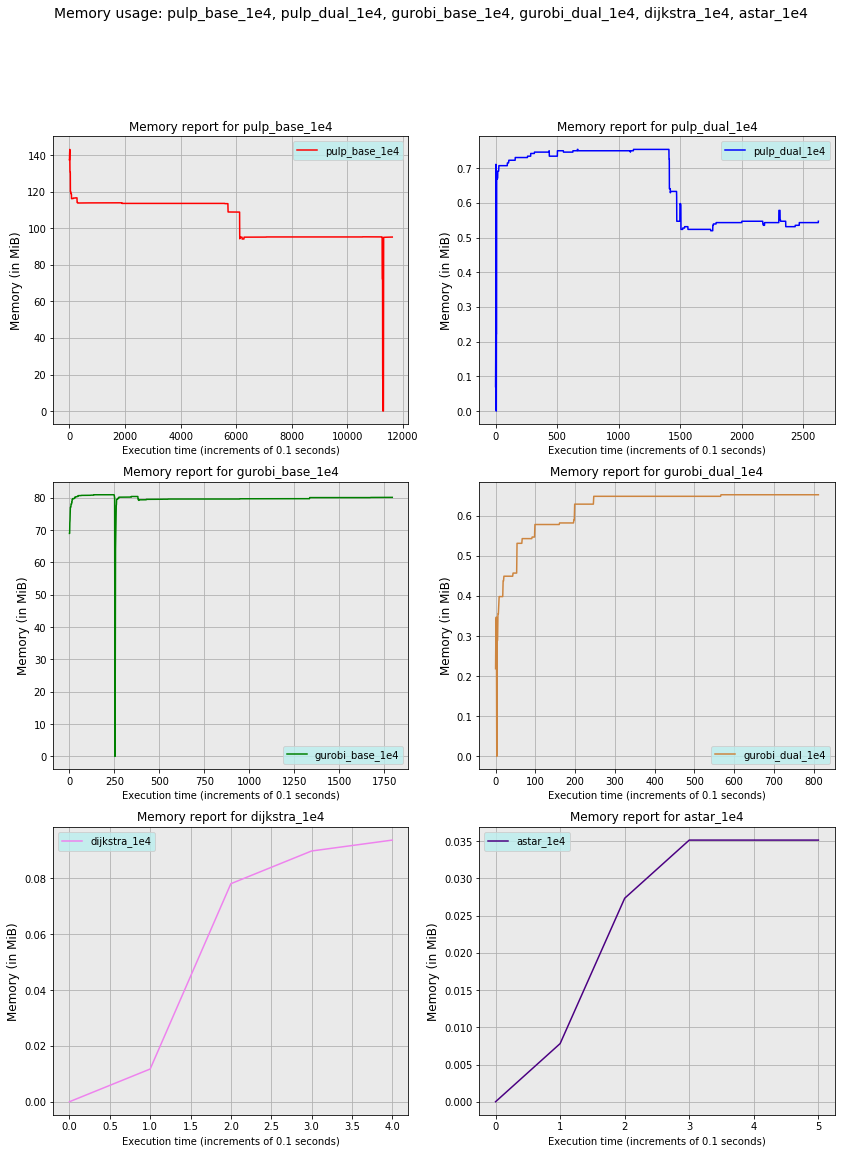

In [98]:
six_subplot_memory_report(pulp_base_1e4_memory, pulp_dual_1e4_memory, gurobi_base_1e4_memory,
                          gurobi_dual_1e4_memory, dijkstra_1e4_memory, astar_1e4_memory,
                          "pulp_base_1e4", "pulp_dual_1e4", "gurobi_base_1e4",
                          "gurobi_dual_1e4", "dijkstra_1e4", "astar_1e4")

We can combine memory reports by algorithm for the entire experiment! First, we shall show the memory demands of the PuLP base LP algorithm across all four instances. Then we will consolidate all 24 memory reports we have generated so that the combined memory demands of each algorithm can be seen in a single set of six subplots.

Peak memory usage for combined_pulp_base:	 249.910156


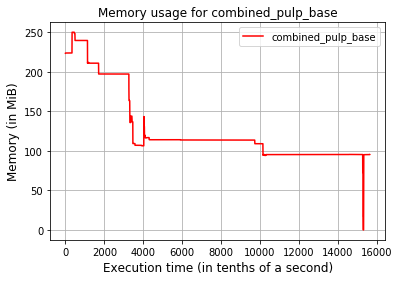

In [99]:
combined_pulp_base_memory = pulp_base_1e1_memory + pulp_base_1e2_memory + pulp_base_1e3_memory + pulp_base_1e4_memory
solo_memory_report(combined_pulp_base_memory, "combined_pulp_base")

In [100]:
combined_pulp_dual_memory = pulp_dual_1e1_memory + pulp_dual_1e2_memory + pulp_dual_1e3_memory + pulp_dual_1e4_memory
combined_gurobi_base_memory = gurobi_base_1e1_memory + gurobi_base_1e2_memory + gurobi_base_1e3_memory + gurobi_base_1e4_memory
combined_gurobi_dual_memory = gurobi_dual_1e1_memory + gurobi_dual_1e2_memory + gurobi_dual_1e3_memory + gurobi_dual_1e4_memory
combined_dijkstra_memory = dijkstra_1e1_memory + dijkstra_1e2_memory + dijkstra_1e3_memory + dijkstra_1e4_memory
combined_astar_memory = astar_1e1_memory + astar_1e2_memory + astar_1e3_memory + astar_1e4_memory

Peak usage for combined_pulp_base	 249.910156
Peak usage for combined_pulp_dual	 148.917969
Peak usage for combined_gurobi_base	 211.359375
Peak usage for combined_gurobi_dual	 125.753906
Peak usage for combined_dijkstra	 125.316406
Peak usage for combined_astar	 125.242188



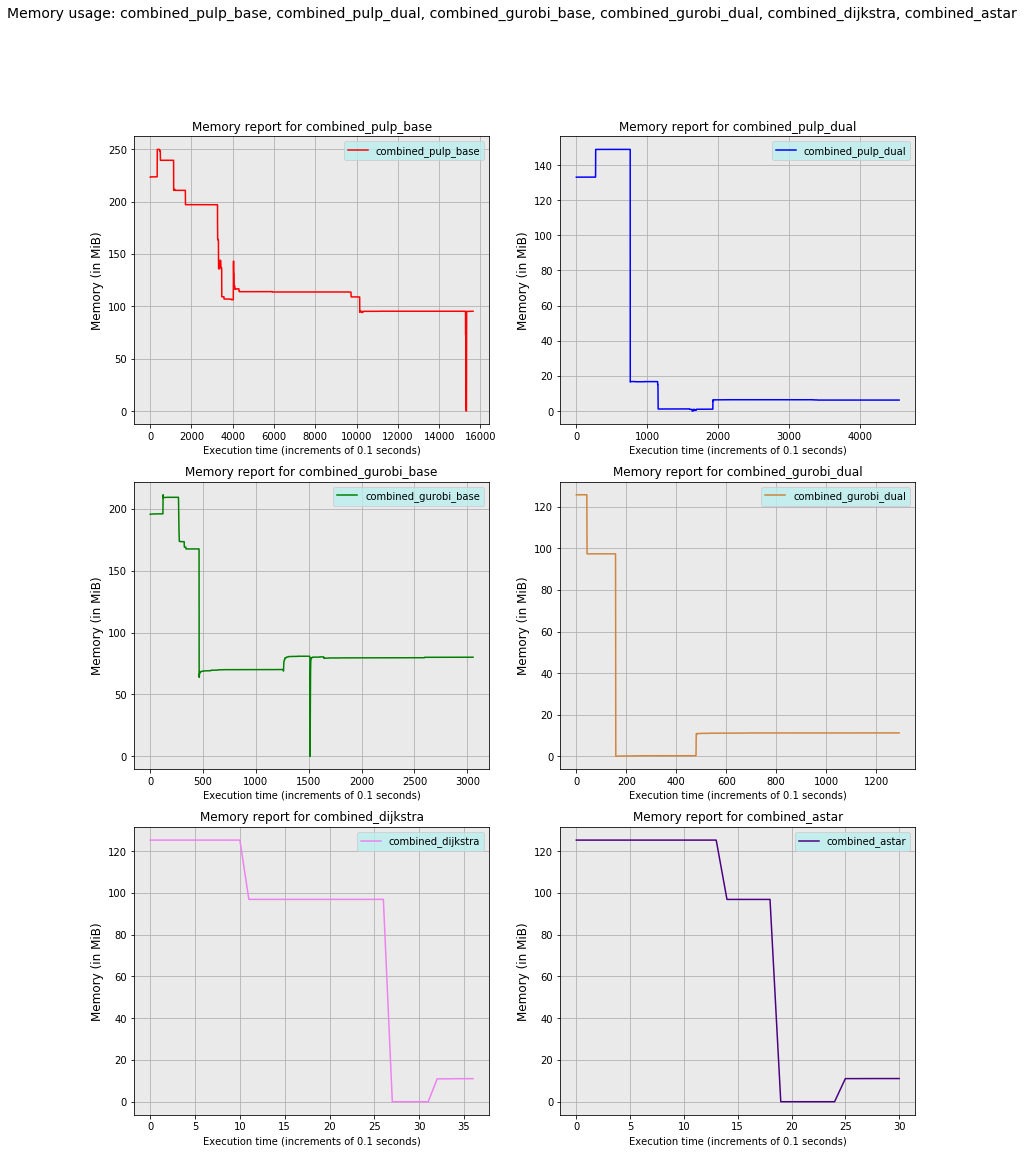

In [101]:
six_subplot_memory_report(combined_pulp_base_memory, combined_pulp_dual_memory, combined_gurobi_base_memory,
                          combined_gurobi_dual_memory, combined_dijkstra_memory, combined_astar_memory,
                          "combined_pulp_base", "combined_pulp_dual", "combined_gurobi_base",
                          "combined_gurobi_dual", "combined_dijkstra", "combined_astar")

In [102]:
# What is the relationship between the number of edges in an instance and length of the shortest path?

pulp_base_1e1.mean() / 6, pulp_base_1e2.mean() / 7, pulp_base_1e3.mean() / 8, pulp_base_1e4.mean() / 9
pulp_base_1e1.mean(), pulp_base_1e2.mean(), pulp_base_1e3.mean(), pulp_base_1e4.mean()

(1.146484375, 1.236328125, 1.7333984375, 8.4853515625)

In [103]:
pulp_base_1e4_time_square = PROF_DATA["pulp_base_trial_1e4"][1][-NUM_RUNS:]
pulp_dual_1e4_time_square = PROF_DATA["pulp_dual_trial_1e4"][1][-NUM_RUNS:]
gurobi_base_1e4_time_square = PROF_DATA["gurobi_base_trial_1e4"][1][-NUM_RUNS:]
gurobi_dual_1e4_time_square = PROF_DATA["gurobi_dual_trial_1e4"][1][-NUM_RUNS:]
dijkstra_1e4_time_square = PROF_DATA["dijkstra_trial_1e4"][1][-NUM_RUNS:]
astar_1e4_time_square = PROF_DATA["astar_trial_1e4"][1][-NUM_RUNS:]

In [104]:
pulp_base_1e4_square = np.zeros((32, 32), dtype = float)
pulp_dual_1e4_square = np.zeros((32, 32), dtype = float)
gurobi_base_1e4_square = np.zeros((32, 32), dtype = float)
gurobi_dual_1e4_square = np.zeros((32, 32), dtype = float)
dijkstra_1e4_square = np.zeros((32, 32), dtype = float)
astar_1e4_square = np.zeros((32, 32), dtype = float)

solution_1e4_square = np.zeros((32, 32), dtype = float)
count = 0

for i in range(32):
    for j in range(32):
        pulp_base_1e4_square[i, j] = pulp_base_1e4_time_square[count]
        pulp_dual_1e4_square[i, j] = pulp_dual_1e4_time_square[count]
        gurobi_base_1e4_square[i, j] = gurobi_base_1e4_time_square[count]
        gurobi_dual_1e4_square[i, j] = gurobi_dual_1e4_time_square[count]
        dijkstra_1e4_square[i, j] = dijkstra_1e4_time_square[count]
        astar_1e4_square[i, j] = astar_1e4_time_square[count]
        
        solution_1e4_square[i, j] = pulp_base_1e4[count]
        count += 1

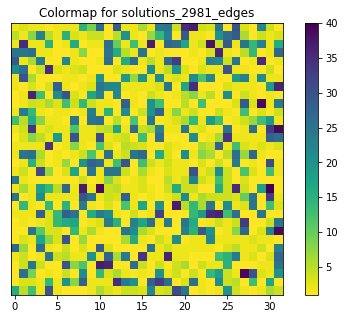

In [228]:
single_colormap(solution_1e4_square, "solutions_2981_edges", colormap = "viridis_r")

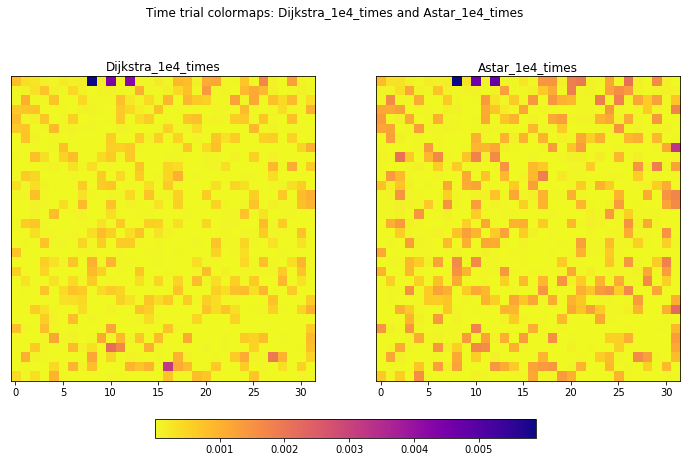

In [106]:
colormap_subplots(dijkstra_1e4_square, astar_1e4_square, "Dijkstra_1e4_times", "Astar_1e4_times")

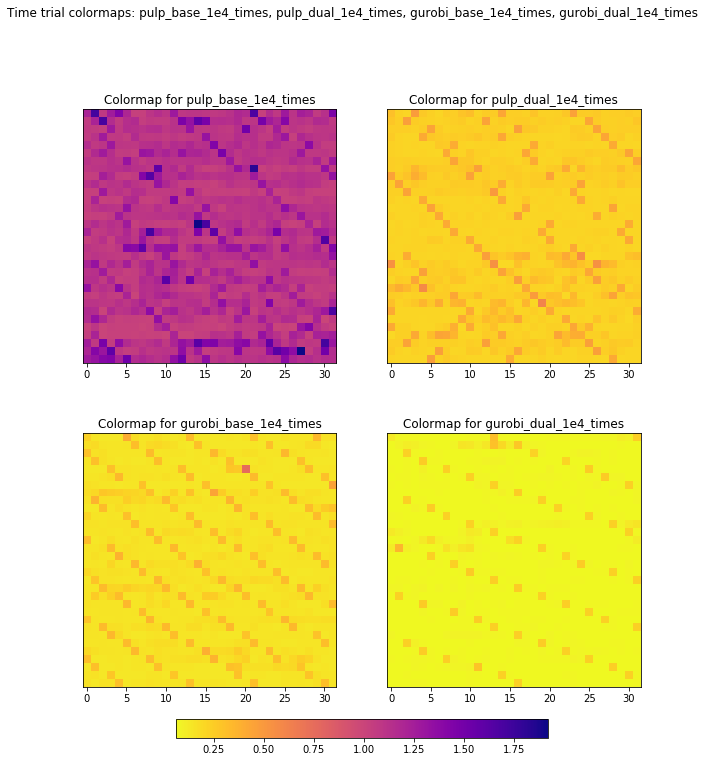

In [107]:
four_subplot_colormap(pulp_base_1e4_square, pulp_dual_1e4_square, gurobi_base_1e4_square, gurobi_dual_1e4_square,
                     "pulp_base_1e4_times", "pulp_dual_1e4_times", "gurobi_base_1e4_times", "gurobi_dual_1e4_times")

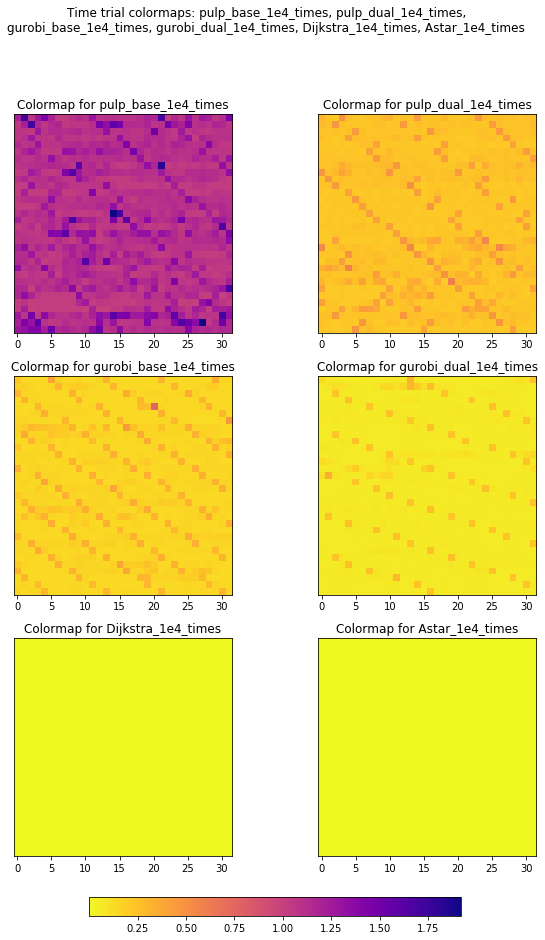

In [108]:
six_subplot_colormap(pulp_base_1e4_square, pulp_dual_1e4_square, gurobi_base_1e4_square,
                     gurobi_dual_1e4_square, dijkstra_1e4_square, astar_1e4_square,
                     "pulp_base_1e4_times", "pulp_dual_1e4_times", "gurobi_base_1e4_times",
                     "gurobi_dual_1e4_times", "Dijkstra_1e4_times", "Astar_1e4_times")

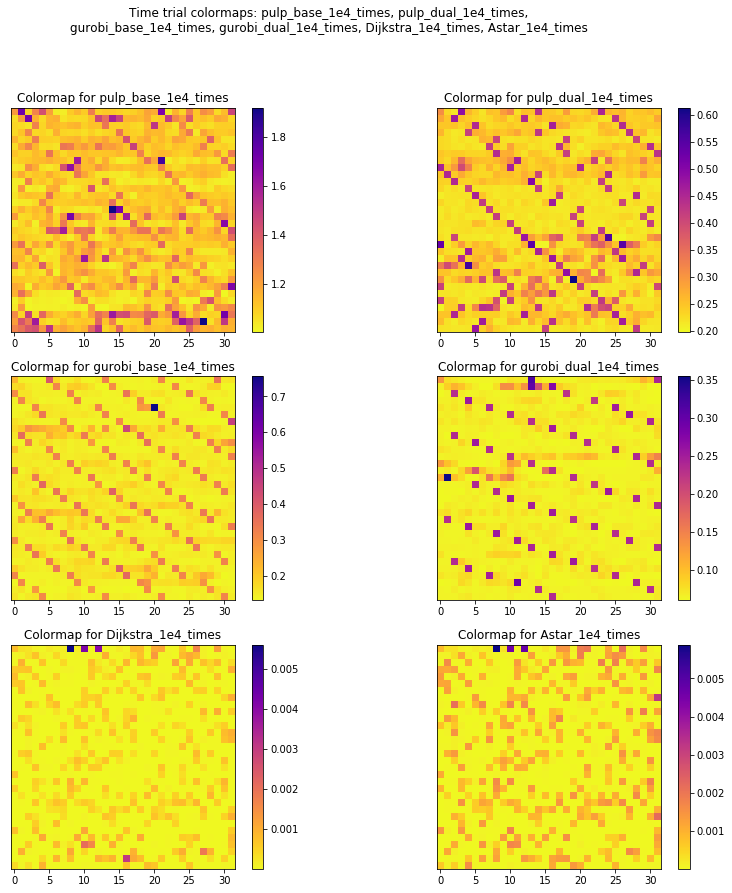

In [109]:
original_six_subplot_colormap(pulp_base_1e4_square, pulp_dual_1e4_square, gurobi_base_1e4_square,
                              gurobi_dual_1e4_square, dijkstra_1e4_square, astar_1e4_square,
                              "pulp_base_1e4_times", "pulp_dual_1e4_times", "gurobi_base_1e4_times",
                              "gurobi_dual_1e4_times", "Dijkstra_1e4_times", "Astar_1e4_times")

## Super squares!

The goal here is to portray trial times for each of the algorithms across all four instances. As the number of edges goes up, the strain on the linear programming algorithms, in particular, becomes severe. Indeed, to keep those algorithms' colormaps interpretable, We have implemented a routine for trimming at an arbitrary number of standard deviations above the mean. 2σ follows a long, venerable tradition in statistics. It corresponds roughly with 95% confidence. So that's what we'll pick.

In [229]:
def super_square_colormap(square_1, square_2, square_3, square_4, label, trim = 0, colormap = "plasma_r"):
    
    super_square = np.zeros((64, 64), dtype = float)
    row_count = 0
    column_count = 0
    for square in (square_1, square_2, square_3, square_4):
        for i in range(len(square)):
            for j in range(len(square[i])):
                super_square[row_count, column_count] = square[i, j]
                column_count += 1
                if column_count >= 64:
                    column_count = 0
                    row_count += 1
    plot_square = super_square
    plot_title = "Combined colormap for " + label
    trim_title = ""
    if trim > 0:  # Cap outliers at mean + trim * standard deviation
        plot_title += " | Outliers trimmed at +" + str(trim) + "σ"
        trim_title = "_trim_" + str(trim)
        top_value = super_square.mean() + trim * super_square.std()
        for i in range(len(plot_square)):
            for j in range(len(plot_square)):
                plot_square[i, j] = min(plot_square[i, j], top_value)      
    plt.figure(figsize = (9, 8))
    plt.title(plot_title)
    plt.imshow(plot_square, aspect = "equal", interpolation = "none", cmap = colormap)
    plt.yticks([])
    plt.colorbar()
    file_name = label + trim_title + "_combined_matrix.png"
    plt.savefig(file_name)
    return super_square

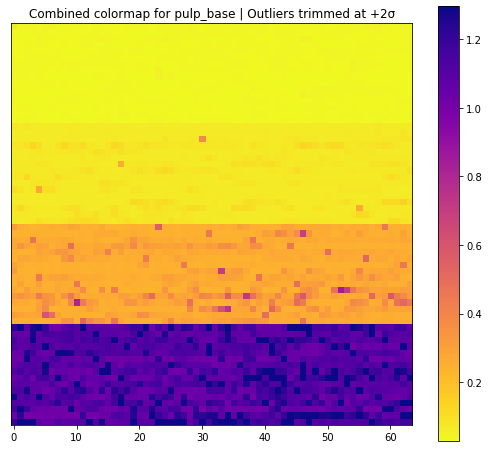

In [230]:
pulp_base_super_square = super_square_colormap(pulp_base_square, pulp_base_1e2_square, pulp_base_1e3_square,
                                               pulp_base_1e4_square, "pulp_base", trim = 2)

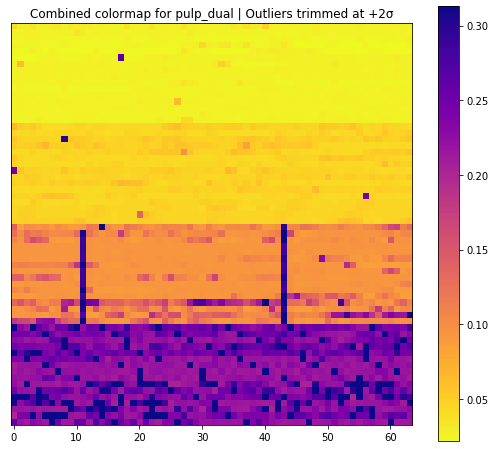

In [112]:
pulp_dual_super_square = super_square_colormap(pulp_dual_square, pulp_dual_1e2_square, pulp_dual_1e3_square,
                                               pulp_dual_1e4_square, "pulp_dual", trim = 2)

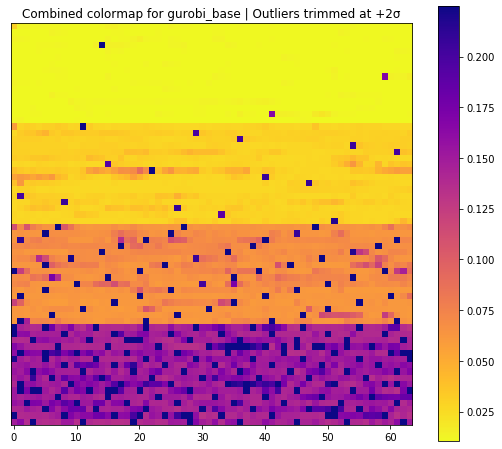

In [113]:
gurobi_base_super_square = super_square_colormap(gurobi_base_square, gurobi_base_1e2_square,
                                                 gurobi_base_1e3_square, gurobi_base_1e4_square, "gurobi_base",
                                                 trim = 2)

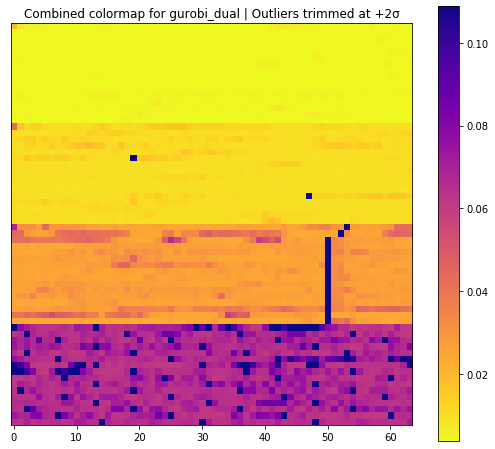

In [114]:
gurobi_dual_super_square = super_square_colormap(gurobi_dual_square, gurobi_dual_1e2_square,
                                                 gurobi_dual_1e3_square, gurobi_dual_1e4_square, "gurobi_dual",
                                                 trim = 2)

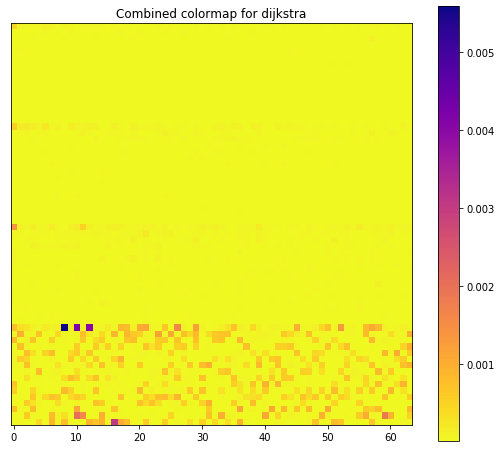

In [115]:
dijkstra_super_square = super_square_colormap(dijkstra_square, dijkstra_1e2_square, dijkstra_1e3_square,
                                              dijkstra_1e4_square, "dijkstra")

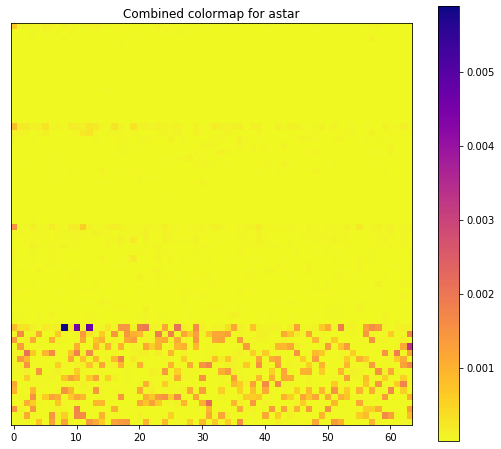

In [116]:
astar_super_square = super_square_colormap(astar_square, astar_1e2_square, astar_1e3_square,
                                           astar_1e4_square, "astar")

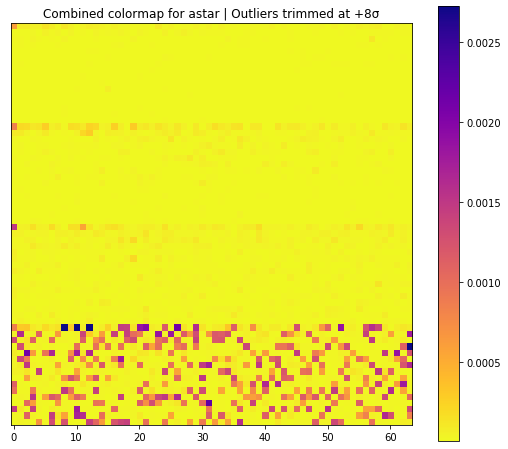

In [117]:
astar_super_square = super_square_colormap(astar_square, astar_1e2_square, astar_1e3_square,
                                           astar_1e4_square, "astar", trim = 8)

The supersquare maneuver also applies to the consolidated colormap of shortest-path solutions for all four instances!

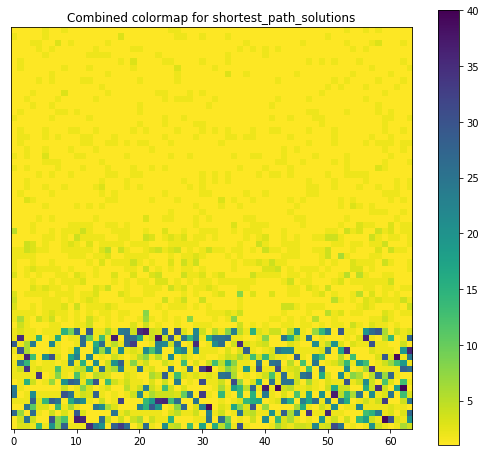

In [231]:
solutions_super_square = super_square_colormap(solution_1e1_square, solution_1e2_square, solution_1e3_square,
                                               solution_1e4_square, "shortest_path_solutions",
                                               colormap = "viridis_r")

### Some experimental code, leading to visualizations of time per trial in each instance

In [119]:
# Fooling around with possible relationships between the length of the shortest path and n_edges per instance

gurobi_base_1e4.mean() / 8
# gurobi_base_1e3.mean() / (np.log(512) / np.log(4))
# gurobi_base_1e2.mean() / (np.log(128) / np.log(4))
# gurobi_base_1e1.mean() / (np.log(32) / np.log(4))

1.0606689453125

In [120]:
def vertex_equivalent(n_edges):
    n_vertices = np.sqrt(2* n_edges + 1/4) + 1/2
    return n_vertices

NUM_EDGES_4, vertex_equivalent(NUM_EDGES_4)
NUM_EDGES_3, vertex_equivalent(NUM_EDGES_3)

(1097, 47.34282228901243)

In [121]:
gurobi_base_1e1.mean() / np.log(vertex_equivalent(NUM_EDGES)), \
gurobi_base_1e2.mean() / np.log(vertex_equivalent(NUM_EDGES_2)), \
gurobi_base_1e3.mean() / np.log(vertex_equivalent(NUM_EDGES_3)), \
gurobi_base_1e4.mean() / np.log(vertex_equivalent(NUM_EDGES_4))

(0.3988829580231326,
 0.36755522394099277,
 0.4493678639082454,
 1.9492860562261374)

In [122]:
np.log(vertex_equivalent(NUM_EDGES)), np.log(vertex_equivalent(NUM_EDGES_2)), \
np.log(vertex_equivalent(NUM_EDGES_3)), np.log(vertex_equivalent(NUM_EDGES_4))

(2.874237547480059, 3.363652709772069, 3.857415219736175, 4.353056102462373)

In [123]:
# Create routines for calculating and rendering the linear regression hyperplane for any data we display

def linear_regression_3d(data_frame, x1_column, x2_column, y_column):
    X_data = data_frame[[x1_column, x2_column]].values
    y_data = data_frame[y_column].values
    lin_reg = LinearRegression()
    linear_model = lin_reg.fit(X_data, y_data)
    model_score = lin_reg.score(X_data, y_data)
    return linear_model, model_score

def linear_regression_2d(X_data, y_data):
    # X_data = data_frame[[x1_column, x2_column]].values
    # y_data = data_frame[y_column].values
    lin_reg = LinearRegression()
    linear_model = lin_reg.fit(X_data, y_data)
    return linear_model

def scale_this_graph(vector, data_frame, y_column):
    y_data = data_frame[y_column].values
    vector = (vector - np.min(y_data)) / (vector.max() - np.min(y_data))
    return vector

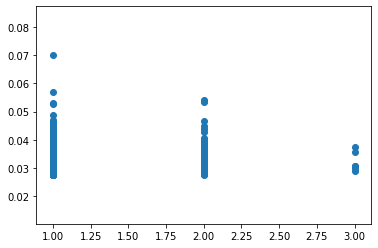

In [124]:
plt.scatter(pulp_base_1e1, pulp_base_time_square)

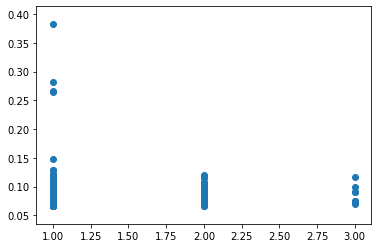

In [125]:
plt.scatter(pulp_base_1e2, pulp_base_1e2_time_square)

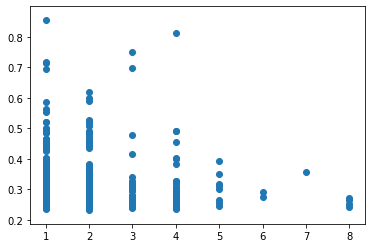

In [126]:
plt.scatter(pulp_base_1e3, pulp_base_1e3_time_square)

In [127]:
solutions_1e4_model = linear_regression_2d(pulp_base_1e4.reshape(-1, 1), pulp_base_1e4_time_square)
solutions_1e4_model.coef_
solutions_1e4_model.score(pulp_base_1e4.reshape(-1, 1), pulp_base_1e4_time_square)
solutions_1e4_model.intercept_

1.1483657915477663

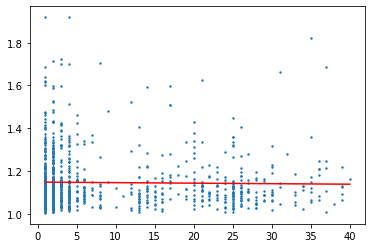

In [128]:
plt.scatter(pulp_base_1e4, pulp_base_1e4_time_square, s = 2)
plot_x = np.linspace(min(pulp_base_1e4), max(pulp_base_1e4), 100)
plot_y = solutions_1e4_model.coef_[0] * plot_x +  solutions_1e4_model.intercept_
plt.plot(plot_x, plot_y, color = "red")

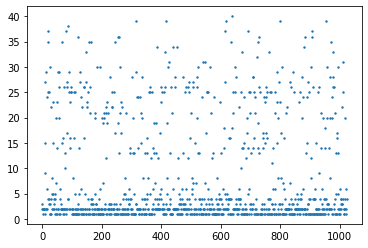

In [129]:
# plt.plot(pulp_base_1e4, linewidth = 0.5)
plt.scatter(np.linspace(0, 1023, 1024), pulp_base_1e4, s = 2)

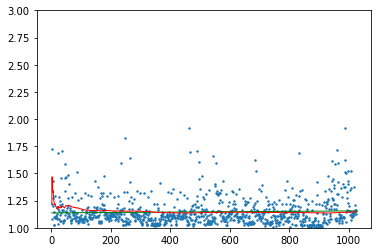

In [130]:
plot_x = np.linspace(1, 1025, 1024)
times_1e4_model = linear_regression_2d(plot_x.reshape(-1, 1), pulp_base_1e4_time_square)
plt.ylim(1, 3)
plt.scatter(plot_x, pulp_base_1e4_time_square, s = 2)
plt.plot(plot_x, times_1e4_model.coef_[0] * plot_x + times_1e4_model.intercept_, linewidth = 1, color = "green")
plt.plot(plot_x, np.cumsum(pulp_base_1e4_time_square) / plot_x, linewidth = 1, color = "red")

In [131]:
times_1e4_model.score(plot_x.reshape(-1, 1), pulp_base_1e4_time_square)

# I.e., the regression line is almost meaningness, since r-squared is essentially 0

0.001822387185190899

In [132]:
np.mean(pulp_base_1e4_time_square), np.std(pulp_base_1e4_time_square)

(1.146298039762696, 0.12498057017500099)

In [133]:
# Look how close the mean of this series is to the regression intercept

times_1e4_model.coef_[0], times_1e4_model.intercept_

(1.8031397132259255e-05, 1.137047933033847)

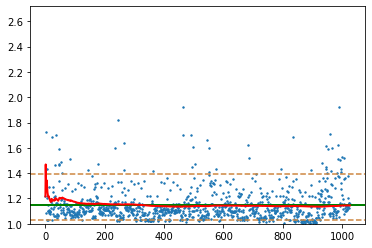

In [134]:
# Let's redo the plot with an indication of ±1σ
# Or perhaps better yet, 5th and 95th percentiles of observations, consistent with α = 10%

plot_x = np.linspace(1, 1025, 1024)
plt.ylim(1, np.e)
plt.scatter(plot_x, pulp_base_1e4_time_square, s = 2)
plt.axhline(np.mean(pulp_base_1e4_time_square), linewidth = 2, color = "green")
plt.axhline(np.percentile(pulp_base_1e4_time_square, 95), linestyle = "--", color = "peru")
plt.axhline(np.percentile(pulp_base_1e4_time_square, 5), linestyle = "--", color = "peru")
plt.plot(plot_x, np.cumsum(pulp_base_1e4_time_square) / plot_x, linewidth = 2, color = "red")

In [135]:
# Hey! That looks pretty good!!
# Let's generate 2x2 subplots of trial time scatterplots

def four_subplot_time_scatter(func_1, func_2, func_3, func_4, label_1, label_2, label_3, label_4):
    
    plot_x = np.linspace(1, NUM_RUNS + 1, NUM_RUNS)
    fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (14, 12))
    fig.suptitle("Processing time in seconds by trial:\n" + label_1 + ", " + label_2 + ", " + label_3 \
                 + ", and " + label_4, fontsize = 14)
    plot_funcs  = [[func_1, func_2], [func_3, func_4]]
    plot_labels = [[label_1, label_2], [label_3, label_4]]
    # plot_colors = [["red", "blue"], ["green", "peru"]]  # Each plot will share the same color scheme
    for i in (0, 1):
        for j in (0, 1):
            axes[i, j].set_facecolor("#eaeaea")
            axes[i, j].set_title("Processing time: " + plot_labels[i][j])
            axes[i, j].grid()
            axes[i, j].set_ylim(0.9 * np.percentile(plot_funcs[i][j], 5),
                                1.05 * np.percentile(plot_funcs[i][j], 95))
            axes[i, j].scatter(plot_x, plot_funcs[i][j], s = 2, color = "blue")
            axes[i, j].axhline(np.mean(plot_funcs[i][j]), linewidth = 2, color = "green", label = "Mean time")
            axes[i, j].axhline(np.percentile(plot_funcs[i][j], 95), linestyle = "--", color = "peru",
                              label = "5th, 95th percentiles")
            axes[i, j].axhline(np.percentile(plot_funcs[i][j], 5), linestyle = "--", color = "peru")
            axes[i, j].plot(plot_x, np.cumsum(plot_funcs[i][j]) / plot_x, linewidth = 2, color = "red",
                            label = "Cumulative average")
            axes[i, j].set_xlabel("Trial runs, 1 to " + str(NUM_RUNS))
            axes[i, j].set_ylabel("Processing time (in seconds)", fontsize = 12)
            axes[i, j].legend(loc = "best", fontsize = 8)
    file_name = "trial_time_subplots_" + label_1 + "_" + label_2 + "_" + label_3 + "_" + label_4
    plt.savefig(file_name + ".png")
    plt.show()

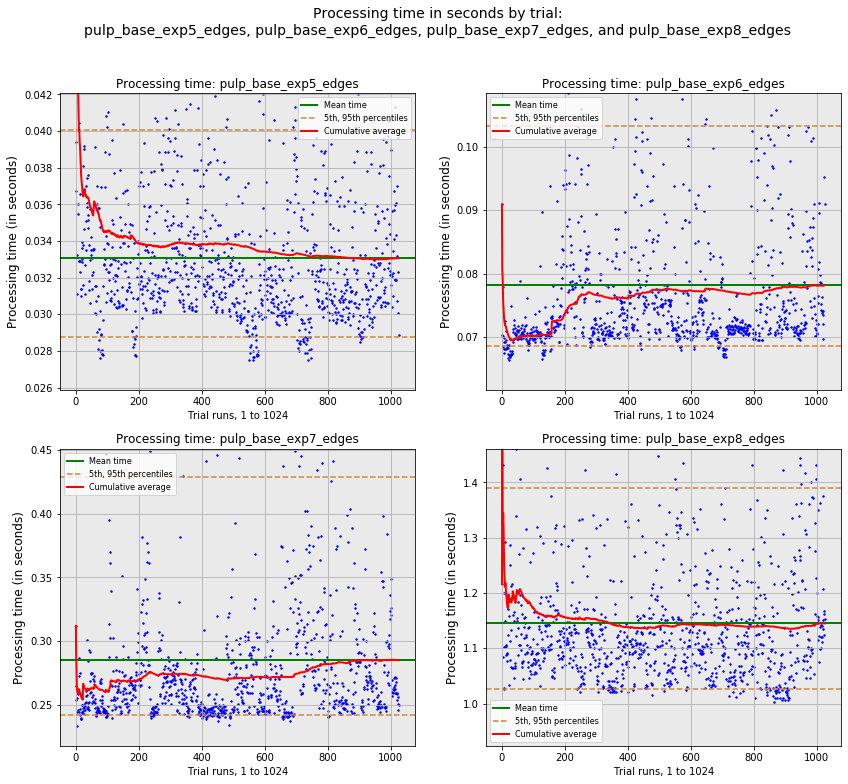

In [136]:
four_subplot_time_scatter(pulp_base_time_square, pulp_base_1e2_time_square, pulp_base_1e3_time_square, 
                          pulp_base_1e4_time_square, "pulp_base_exp5_edges", "pulp_base_exp6_edges",
                          "pulp_base_exp7_edges", "pulp_base_exp8_edges")

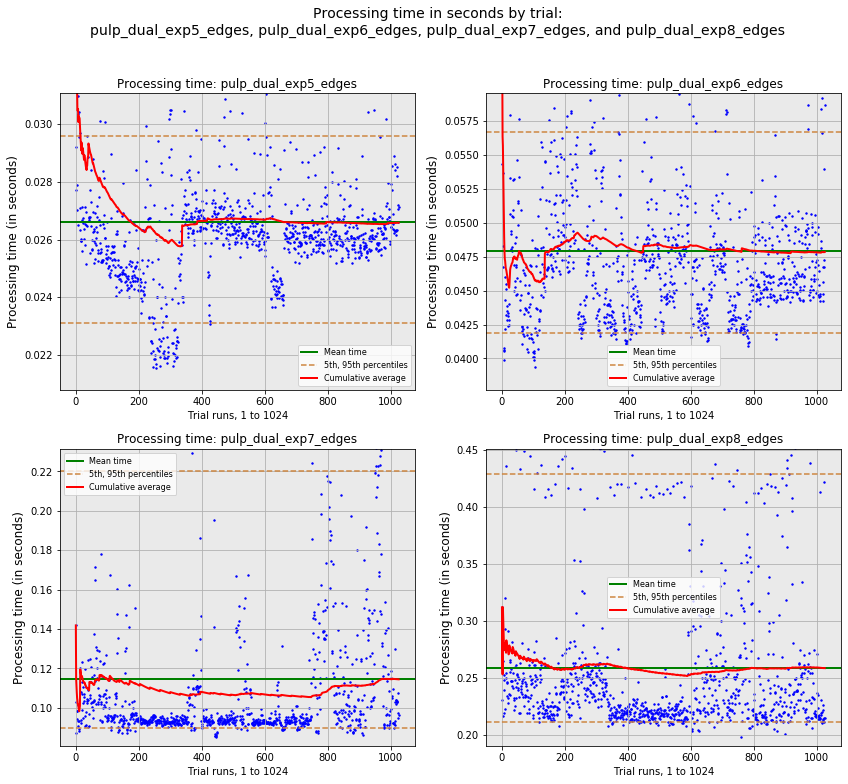

In [137]:
four_subplot_time_scatter(pulp_dual_time_square, pulp_dual_1e2_time_square, pulp_dual_1e3_time_square, 
                          pulp_dual_1e4_time_square, "pulp_dual_exp5_edges", "pulp_dual_exp6_edges",
                          "pulp_dual_exp7_edges", "pulp_dual_exp8_edges")

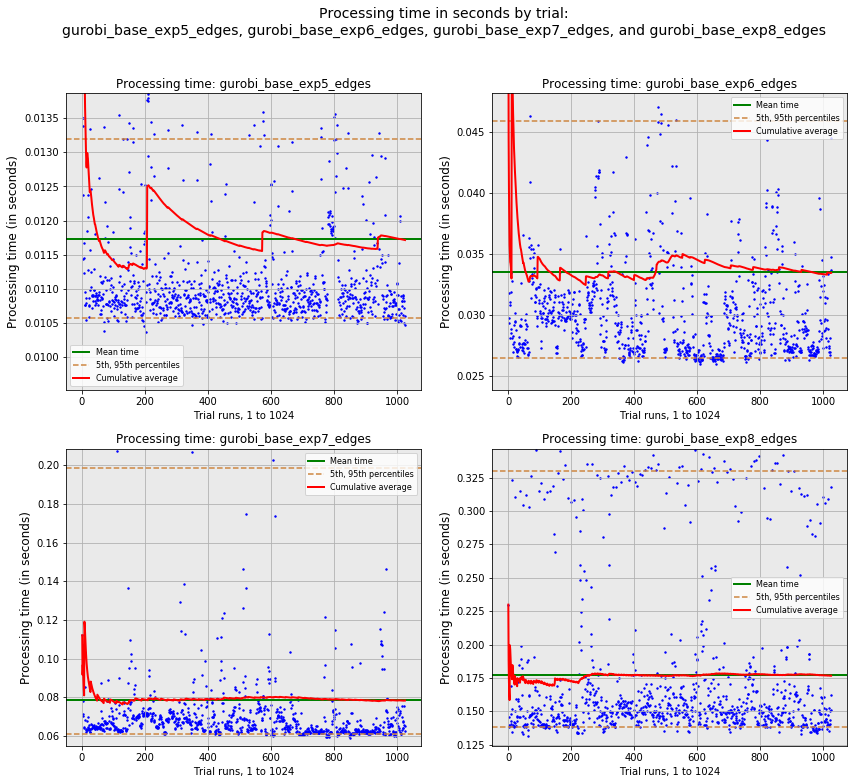

In [138]:
four_subplot_time_scatter(gurobi_base_time_square, gurobi_base_1e2_time_square, gurobi_base_1e3_time_square, 
                          gurobi_base_1e4_time_square, "gurobi_base_exp5_edges", "gurobi_base_exp6_edges",
                          "gurobi_base_exp7_edges", "gurobi_base_exp8_edges")

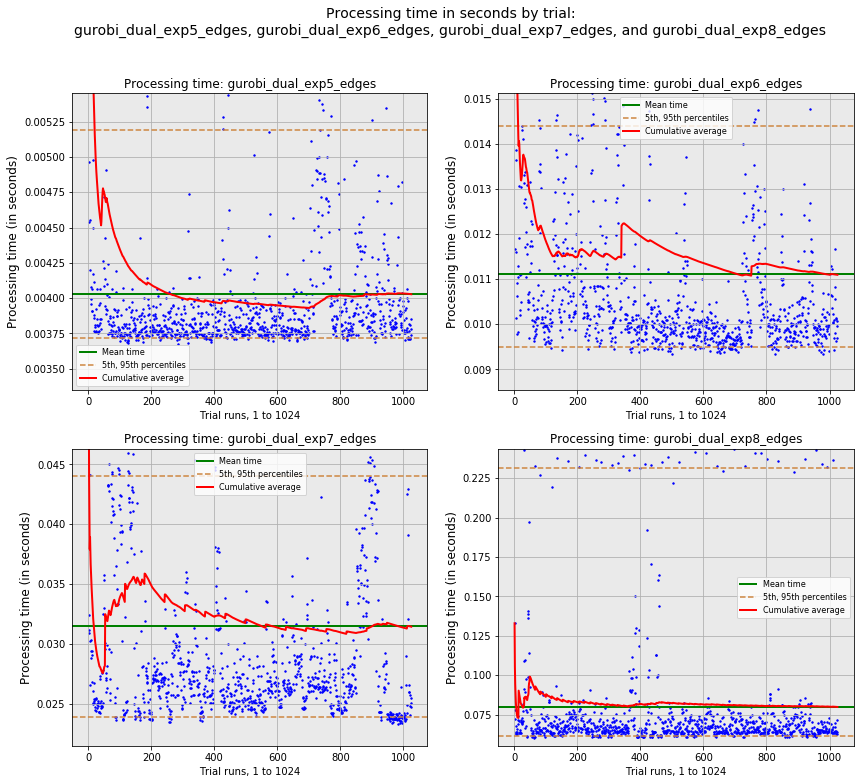

In [139]:
four_subplot_time_scatter(gurobi_dual_time_square, gurobi_dual_1e2_time_square, gurobi_dual_1e3_time_square, 
                          gurobi_dual_1e4_time_square, "gurobi_dual_exp5_edges", "gurobi_dual_exp6_edges",
                          "gurobi_dual_exp7_edges", "gurobi_dual_exp8_edges")

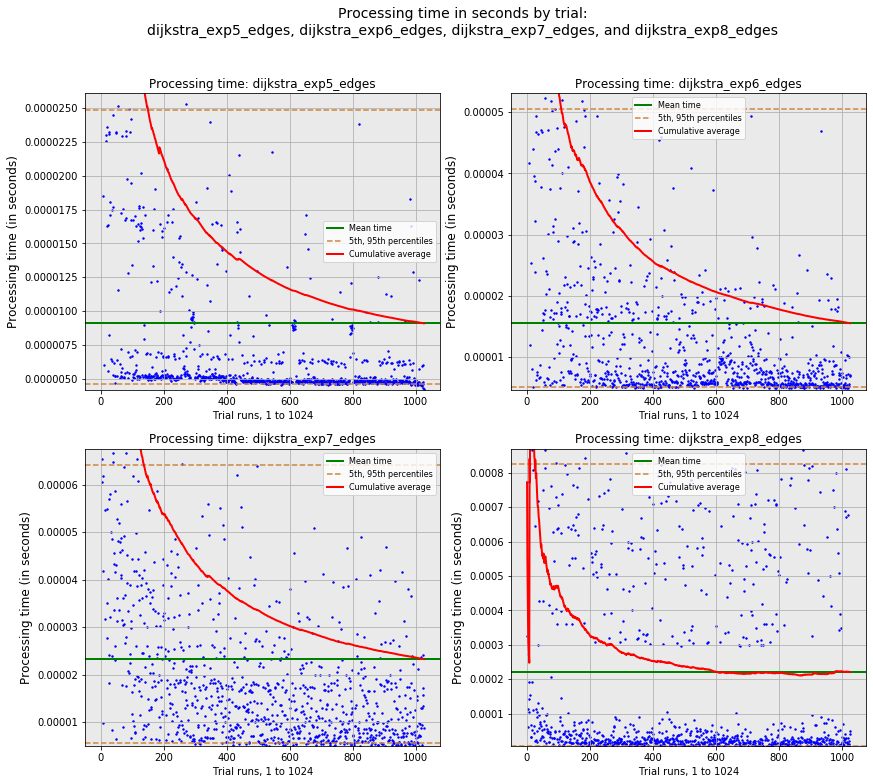

In [140]:
four_subplot_time_scatter(dijkstra_time_square, dijkstra_1e2_time_square, dijkstra_1e3_time_square, 
                          dijkstra_1e4_time_square, "dijkstra_exp5_edges", "dijkstra_exp6_edges",
                          "dijkstra_exp7_edges", "dijkstra_exp8_edges")

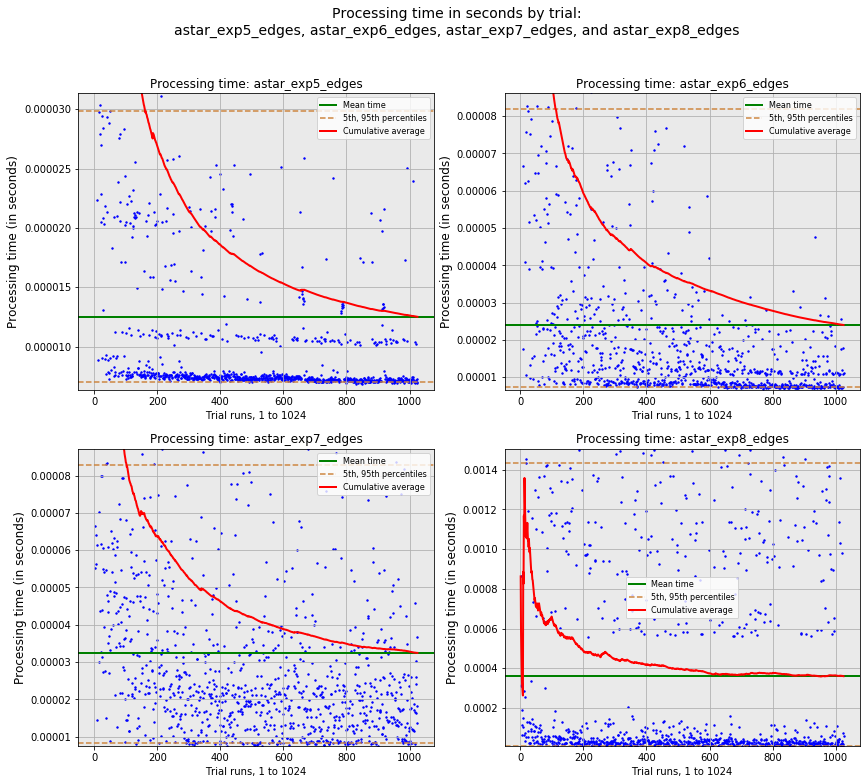

In [141]:
four_subplot_time_scatter(astar_time_square, astar_1e2_time_square, astar_1e3_time_square, 
                          astar_1e4_time_square, "astar_exp5_edges", "astar_exp6_edges",
                          "astar_exp7_edges", "astar_exp8_edges")

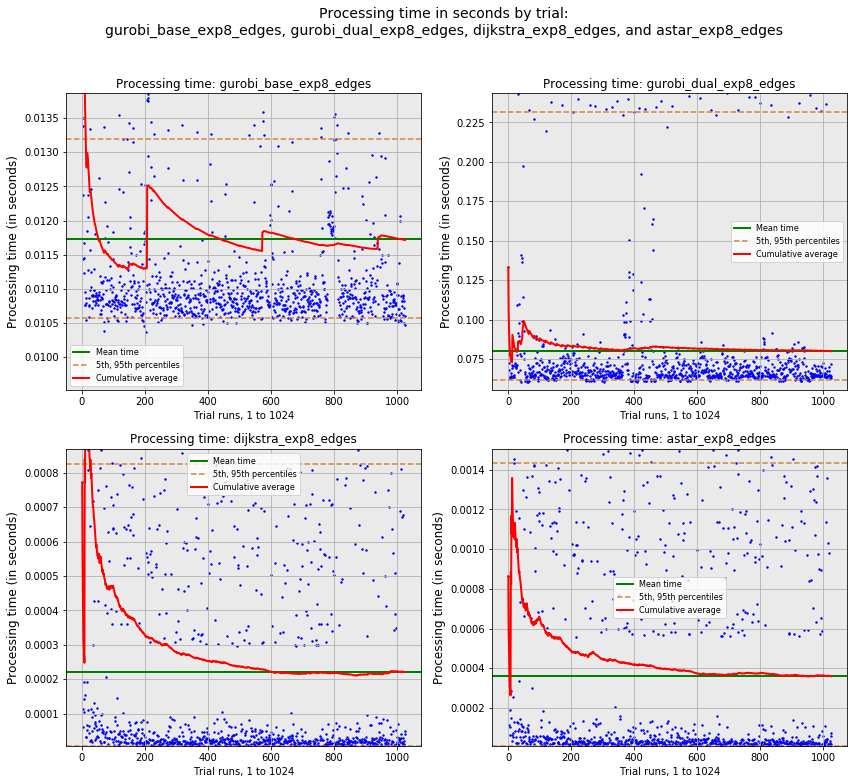

In [177]:
four_subplot_time_scatter(gurobi_base_time_square, gurobi_dual_1e4_time_square, dijkstra_1e4_time_square, 
                          astar_1e4_time_square, "gurobi_base_exp8_edges", "gurobi_dual_exp8_edges",
                          "dijkstra_exp8_edges", "astar_exp8_edges")

These next two lines look like experiments. They are not. They enable the regression line in the plot of all PuLP base solutions found, projected as a manifold onto a numpy linspace from 0 to 1023.

In [142]:
solution_string = np.concatenate((pulp_base_1e1, pulp_base_1e2, pulp_base_1e3, pulp_base_1e4))

In [143]:
time_string = pulp_base_time_square + pulp_base_1e2_time_square + pulp_base_1e3_time_square + pulp_base_1e4_time_square

In [144]:
gurobi_base_time_string = gurobi_base_time_square + gurobi_base_1e2_time_square + gurobi_base_1e3_time_square + gurobi_base_1e4_time_square

In [145]:
pulp_base_y = []
for i in range(0, 4):
    for j in range(0, NUM_RUNS):
        pulp_base_y += [i + 5]
pulp_base_y[4000]

8

In [146]:
solution_string_model = linear_regression_2d(solution_string.reshape(-1, 1), time_string)

In [147]:
# r-squared for the relationship between solutions and processing time, over the entire sequence, ≈ 0.22765

solution_string_model.score(solution_string.reshape(-1, 1), time_string)

0.24895542086400324

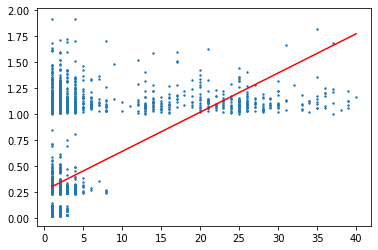

In [148]:
plt.scatter(solution_string, time_string, s = 2)
plot_x = np.linspace(min(solution_string), max(solution_string), 100)
plot_y = solution_string_model.coef_[0] * plot_x +  solution_string_model.intercept_
plt.plot(plot_x, plot_y, color = "red")

In [183]:
np.mean(solution_string), np.std(solution_string)

(3.150390625, 6.024148980657941)

In [182]:
# This cell reports statistics on shortest path solutions for all four instances

print("Sum\tAverage\t\tStandard deviation\tMin\tMax")
for string in (pulp_base_1e1, pulp_base_1e2, pulp_base_1e3, pulp_base_1e4):
    print(sum(string), "\t", np.mean(string), "\t", np.std(string), "\t", np.min(string), "\t", np.max(string))

Sum	Average		Standard deviation	Min	Max
1174.0 	 1.146484375 	 0.3724225797140385 	 1.0 	 3.0
1266.0 	 1.236328125 	 0.4472229783161688 	 1.0 	 3.0
1775.0 	 1.7333984375 	 0.9813782626350345 	 1.0 	 8.0
8689.0 	 8.4853515625 	 10.281572006423863 	 1.0 	 40.0


In [149]:
# Create a routine for plotting a histogram
# This provides an alternative — indeed, traditional — way of visualizing information depicted via colormaps

def histogram(array, width = 1):
    plt.hist(array, color = "blue", bins = np.arange(0, max(array), width), histtype = "step", linewidth = width * 2)
    plt.hist(array, color = "#0000ff44", bins = np.arange(0, max(array), width), histtype = "stepfilled")

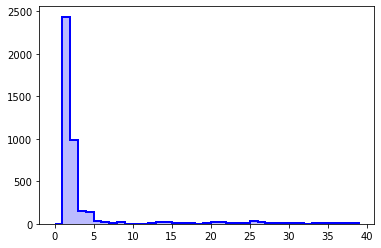

In [150]:
histogram(solution_string, width = 1)

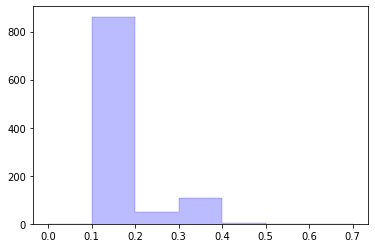

In [151]:
histogram(gurobi_base_1e4_time_square, width = 0.1)

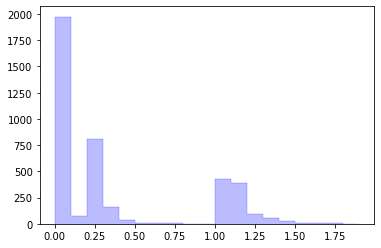

In [152]:
histogram(time_string, width = 0.1)

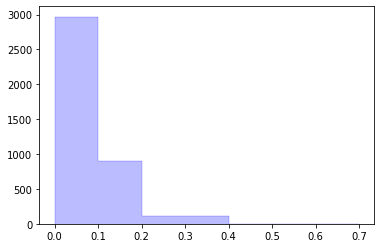

In [153]:
histogram(gurobi_base_time_string, width = 0.1)

As we can see on the unadorned plot just a few cells above, we can use linear regression on the 2d manifold of processing times projected against the length of shortest paths to express the general relationship between path length and processing time. If we plot processing times against a second independent variable — either the log-transformed value of the number of edges in an instance or the log-transformed value of the equivalent number of vertices in a simple undirected graph — we should be able to achieve a closer fit to actually observed processing times for each algorithm.

## Visualizing the whole experiment

We are now prepared to present visualizations summarizing the entire experiment. As a preliminary step, we will consolidate all of the data we have gathered into a comprehensive 24,576-record dataframe that preserves each of the trials we have conducted — for each algorithm, over each instance. Though somewhat time consuming, this preparatory step makes it considerably easier to visualize the whole experiment.

We will conclude with three-dimensional looks at per-trial processing time for the linear programming and graph algorithms as a function of the length of each shortest path solution and of a log-transformed measure of graph complexity (either the number of edges in an instance or the number of vertices it takes to generate N edges in a  simple undirected graph).

The consolidated dataframe, alas, takes between 5 and 10 minutes to greate. This is a function of its sheer size. We are trying to memorialize a grand total of 24,576 attempts to solve shortest-path problems on the mathematics subset of Wikipedia. Even at 0.01 seconds per record, this effort takes longer than 4 minutes.

In [154]:
# Create a giant dataframe containing all shortest_path and processing time data for all 24,576 trials

frame_columns = ["algorithm", "n_edges", "log_edges", "n_vertices", "log_vertices", "path_length", "time"]
final_frame   = pd.DataFrame(columns = frame_columns)
final_frame

Empty DataFrame
Columns: [algorithm, n_edges, log_edges, n_vertices, log_vertices, path_length, time]
Index: []

In [155]:
def fill_frame(target_frame, starting_row, algorithm, solution_array, time_array, n_edges):
    log_edges = int(round(np.log(n_edges)))
    n_vertices = vertex_equivalent(n_edges)
    log_vertices = np.log(n_vertices)
    for i in range(starting_row, starting_row + len(solution_array)):
        target_frame.loc[i, "algorithm"]    = algorithm
        target_frame.loc[i, "n_edges"]      = n_edges
        target_frame.loc[i, "log_edges"]    = log_edges
        target_frame.loc[i, "n_vertices"]   = n_vertices
        target_frame.loc[i, "log_vertices"] = log_vertices
        target_frame.loc[i, "path_length"]  = solution_array[i - starting_row]
        target_frame.loc[i, "time"]         = time_array[i - starting_row]

algorithm_roster = (
    (final_frame, 0, "pulp_base", pulp_base_1e1, pulp_base_time_square, NUM_EDGES),
    (final_frame, 1  * NUM_RUNS, "pulp_dual", pulp_dual_1e1, pulp_dual_time_square, NUM_EDGES),
    (final_frame, 2  * NUM_RUNS, "gurobi_base", gurobi_base_1e1, gurobi_base_time_square, NUM_EDGES),
    (final_frame, 3  * NUM_RUNS, "gurobi_dual", gurobi_dual_1e1, gurobi_dual_time_square, NUM_EDGES),
    (final_frame, 4  * NUM_RUNS, "dijkstra", dijkstra_1e1, dijkstra_time_square, NUM_EDGES),
    (final_frame, 5  * NUM_RUNS, "astar", astar_1e1, astar_time_square, NUM_EDGES),
    (final_frame, 6  * NUM_RUNS, "pulp_base", pulp_base_1e2, pulp_base_1e2_time_square, NUM_EDGES_2),
    (final_frame, 7  * NUM_RUNS, "pulp_dual", pulp_dual_1e2, pulp_dual_1e2_time_square, NUM_EDGES_2),
    (final_frame, 8  * NUM_RUNS, "gurobi_base", gurobi_base_1e2, gurobi_base_1e2_time_square, NUM_EDGES_2),
    (final_frame, 9  * NUM_RUNS, "gurobi_dual", gurobi_dual_1e2, gurobi_dual_1e2_time_square, NUM_EDGES_2),
    (final_frame, 10 * NUM_RUNS, "dijkstra", dijkstra_1e2, dijkstra_1e2_time_square, NUM_EDGES_2),
    (final_frame, 11 * NUM_RUNS, "astar", astar_1e2, astar_1e2_time_square, NUM_EDGES_2),
    (final_frame, 12 * NUM_RUNS, "pulp_base", pulp_base_1e3, pulp_base_1e3_time_square, NUM_EDGES_3),
    (final_frame, 13 * NUM_RUNS, "pulp_dual", pulp_dual_1e3, pulp_dual_1e3_time_square, NUM_EDGES_3),
    (final_frame, 14 * NUM_RUNS, "gurobi_base", gurobi_base_1e3, gurobi_base_1e3_time_square, NUM_EDGES_3),
    (final_frame, 15 * NUM_RUNS, "gurobi_dual", gurobi_dual_1e3, gurobi_dual_1e3_time_square, NUM_EDGES_3),
    (final_frame, 16 * NUM_RUNS, "dijkstra", dijkstra_1e3, dijkstra_1e3_time_square, NUM_EDGES_3),
    (final_frame, 17 * NUM_RUNS, "astar", astar_1e3, astar_1e3_time_square, NUM_EDGES_3),
    (final_frame, 18 * NUM_RUNS, "pulp_base", pulp_base_1e4, pulp_base_1e4_time_square, NUM_EDGES_4),
    (final_frame, 19 * NUM_RUNS, "pulp_dual", pulp_dual_1e4, pulp_dual_1e4_time_square, NUM_EDGES_4),
    (final_frame, 20 * NUM_RUNS, "gurobi_base", gurobi_base_1e4, gurobi_base_1e4_time_square, NUM_EDGES_4),
    (final_frame, 21 * NUM_RUNS, "gurobi_dual", gurobi_dual_1e4, gurobi_dual_1e4_time_square, NUM_EDGES_4),
    (final_frame, 22 * NUM_RUNS, "dijkstra", dijkstra_1e4, dijkstra_1e4_time_square, NUM_EDGES_4),
    (final_frame, 23 * NUM_RUNS, "astar", astar_1e4, astar_1e4_time_square, NUM_EDGES_4))

for target_frame, starting_row, algorithm, solution_array, time_array, n_edges in algorithm_roster:
    fill_frame(target_frame, starting_row, algorithm, solution_array, time_array, n_edges)

In [156]:
final_frame.head()

algorithm n_edges log_edges n_vertices log_vertices path_length       time
0  pulp_base     148         5    17.7119      2.87424           1  0.0700594
1  pulp_base     148         5    17.7119      2.87424           1  0.0394281
2  pulp_base     148         5    17.7119      2.87424           1  0.0367541
3  pulp_base     148         5    17.7119      2.87424           1  0.0332232
4  pulp_base     148         5    17.7119      2.87424           1  0.0311006

In [157]:
final_frame.tail()

algorithm n_edges log_edges n_vertices log_vertices path_length  \
24571     astar    2981         8    77.7156      4.35306           2   
24572     astar    2981         8    77.7156      4.35306           1   
24573     astar    2981         8    77.7156      4.35306           2   
24574     astar    2981         8    77.7156      4.35306           6   
24575     astar    2981         8    77.7156      4.35306           4   

             time  
24571  2.2411e-05  
24572   8.047e-06  
24573  1.6571e-05  
24574  7.2542e-05  
24575  6.0455e-05

In [158]:
(final_frame.groupby("algorithm")["time"].sum() / final_frame.groupby("algorithm")["time"].count()).sort_values(ascending = False)

algorithm
pulp_base      0.385734
pulp_dual      0.111985
gurobi_base    0.075127
gurobi_dual    0.031656
astar          0.000107
dijkstra       0.000067
Name: time, dtype: float64

In [159]:
final_frame.groupby("algorithm")["time"].sum().sort_values(ascending = False)

algorithm
pulp_base      1579.966560
pulp_dual       458.689851
gurobi_base     307.718876
gurobi_dual     129.664608
astar             0.439691
dijkstra          0.275517
Name: time, dtype: float64

In [160]:
# It is possible to use pandas dataframe operations to report total processing time by instance

final_frame.groupby("n_edges")["time"].sum().sort_values(ascending = False)

n_edges
2981    1702.573096
1097     521.992669
403      174.896634
148       77.292703
Name: time, dtype: float64

In [161]:
final_frame.groupby("n_edges")["path_length"].sum().sort_values(ascending = False)

n_edges
2981    52134.0
1097    10650.0
403      7596.0
148      7044.0
Name: path_length, dtype: float64

In [162]:
# We know this already, but counting the average path length by instance is a measure of complexity

(final_frame.groupby("n_edges")["path_length"].sum() / final_frame.groupby("n_edges")["path_length"].count()).sort_values(ascending = False)

n_edges
2981    8.485352
1097    1.733398
403     1.236328
148     1.146484
Name: path_length, dtype: float64

In [197]:
final_frame.groupby(["algorithm", "log_edges"])["time"].sum()

algorithm    log_edges
astar        5               0.012819
             6               0.024628
             7               0.033286
             8               0.368958
dijkstra     5               0.009334
             6               0.015947
             7               0.023870
             8               0.226367
gurobi_base  5              12.007986
             6              34.287186
             7              80.280306
             8             181.143398
gurobi_dual  5               4.128344
             6              11.378065
             7              32.215738
             8              81.942460
pulp_base    5              33.888337
             6              80.144064
             7             292.124966
             8            1173.809193
pulp_dual    5              27.245884
             6              49.046745
             7             117.314502
             8             265.082721
Name: time, dtype: float64

In [196]:
final_frame.groupby(["algorithm", "log_edges"])["time"].sum().sort_values(ascending = False)

algorithm    log_edges
pulp_base    8            1173.809193
             7             292.124966
pulp_dual    8             265.082721
gurobi_base  8             181.143398
pulp_dual    7             117.314502
gurobi_dual  8              81.942460
gurobi_base  7              80.280306
pulp_base    6              80.144064
pulp_dual    6              49.046745
gurobi_base  6              34.287186
pulp_base    5              33.888337
gurobi_dual  7              32.215738
pulp_dual    5              27.245884
gurobi_base  5              12.007986
gurobi_dual  6              11.378065
             5               4.128344
astar        8               0.368958
dijkstra     8               0.226367
astar        7               0.033286
             6               0.024628
dijkstra     7               0.023870
             6               0.015947
astar        5               0.012819
dijkstra     5               0.009334
Name: time, dtype: float64

In [206]:
final_frame.groupby(["algorithm", "log_edges"])["time"].sum() / final_frame.groupby(["algorithm", "log_edges"])["time"].count()

algorithm    log_edges
astar        5            0.000013
             6            0.000024
             7            0.000033
             8            0.000360
dijkstra     5            0.000009
             6            0.000016
             7            0.000023
             8            0.000221
gurobi_base  5            0.011727
             6            0.033484
             7            0.078399
             8            0.176898
gurobi_dual  5            0.004032
             6            0.011111
             7            0.031461
             8            0.080022
pulp_base    5            0.033094
             6            0.078266
             7            0.285278
             8            1.146298
pulp_dual    5            0.026607
             6            0.047897
             7            0.114565
             8            0.258870
Name: time, dtype: float64

In [200]:
final_frame.groupby("algorithm")["time"].std().sort_values(ascending = False)

algorithm
pulp_base      0.455036
pulp_dual      0.100460
gurobi_base    0.074782
gurobi_dual    0.038593
astar          0.000327
dijkstra       0.000221
Name: time, dtype: float64

In [198]:
final_frame.groupby(["algorithm", "log_edges"])["time"].std()

algorithm    log_edges
astar        5            0.000022
             6            0.000041
             7            0.000055
             8            0.000580
dijkstra     5            0.000017
             6            0.000026
             7            0.000051
             8            0.000400
gurobi_base  5            0.010366
             6            0.021857
             7            0.041057
             8            0.063064
gurobi_dual  5            0.000739
             6            0.009171
             7            0.021785
             8            0.043299
pulp_base    5            0.003939
             6            0.018133
             7            0.068039
             8            0.125042
pulp_dual    5            0.008097
             6            0.013144
             7            0.050175
             8            0.068057
Name: time, dtype: float64

In [205]:
final_frame.groupby("algorithm")["time"].sum().sort_values(ascending = False), \
(final_frame.groupby("algorithm")["time"].sum() / final_frame.groupby("algorithm")["time"].count()).sort_values(ascending = False), \
final_frame.groupby("algorithm")["time"].std().sort_values(ascending = False)

(algorithm
 pulp_base      1579.966560
 pulp_dual       458.689851
 gurobi_base     307.718876
 gurobi_dual     129.664608
 astar             0.439691
 dijkstra          0.275517
 Name: time, dtype: float64, algorithm
 pulp_base      0.385734
 pulp_dual      0.111985
 gurobi_base    0.075127
 gurobi_dual    0.031656
 astar          0.000107
 dijkstra       0.000067
 Name: time, dtype: float64, algorithm
 pulp_base      0.455036
 pulp_dual      0.100460
 gurobi_base    0.074782
 gurobi_dual    0.038593
 astar          0.000327
 dijkstra       0.000221
 Name: time, dtype: float64)

In [163]:
# Create a routine for plotting a histogram
# This provides an alternative — indeed, traditional — way of visualizing information depicted via colormaps

def six_way_histogram(algo_1, algo_2, algo_3, algo_4, algo_5, algo_6):
    columns = (algo_1, algo_2, algo_3, algo_4, algo_5, algo_6)
    colors  = (("red", "#ff000044"), ("peru", "#bb880044"), ("green", "#00ff0044"), ("blue", "#0000ff44"),
               ("violet", "#ee82ee44"), ("indigo", "#4b008244"))
    
    fig, ax = plt.subplots(figsize = (8, 10))
    fig.set_facecolor("white")
    ax.set_facecolor("#eaeaea")
    ax.grid()

    for i in range(len(columns)):
        plt.xlim(0, 1.6)
        plt.ylim(0, 1100)
        array = final_frame.time[final_frame.algorithm == columns[i]]
        width = 0.02
        plt.hist(array, color = colors[i][0], bins = np.arange(0, max(array), width), histtype = "step", linewidth = width * 20, label = None)
        plt.hist(array, color = colors[i][1], bins = np.arange(0, max(array), width), histtype = "stepfilled", label = columns[i])
    plt.legend(loc = "best")
    plt.title("Histogram of processing times: All algorithms, all instances", fontsize = 14)
    plt.xlabel("Time (in seconds)")
    plt.ylabel("Frequency")
    plt.savefig("algorithm_times_histogram.png")

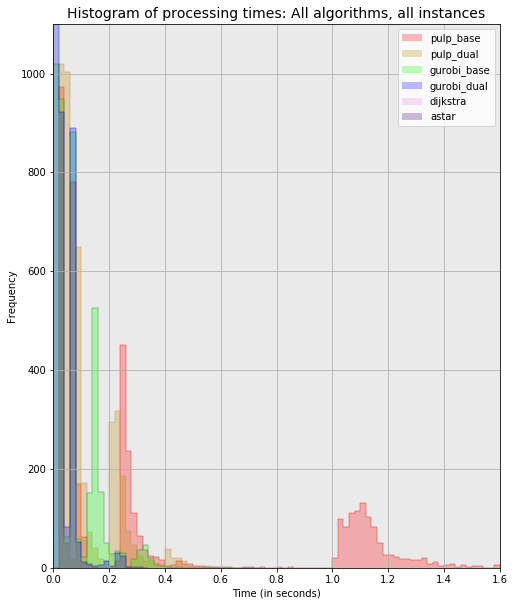

In [164]:
six_way_histogram("pulp_base", "pulp_dual", "gurobi_base", "gurobi_dual", "dijkstra", "astar")

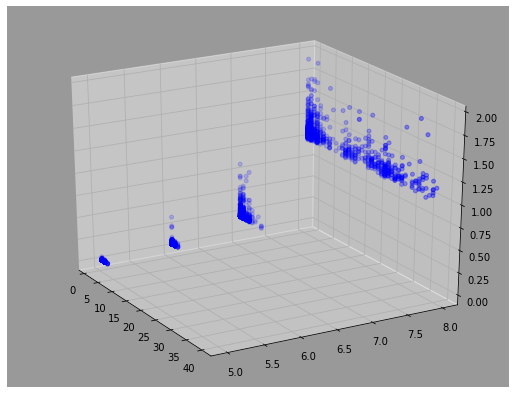

In [165]:
# Much of this could have been accomplished without pandas
# This demonstration shows that such a feat was at once (a) feasible and (b) tedious

fig = plt.figure(figsize = (9, 7))  # figsize = (14, 11)
ax = fig.gca(projection='3d')
# fig, ax = plt.subplots(figsize = (10, 8))
fig.set_facecolor("white")
ax.set_facecolor("#999999")

ax.scatter(np.concatenate((pulp_base_1e1, pulp_base_1e2, pulp_base_1e3, pulp_base_1e4)), pulp_base_y,
           [pulp_base_time_square + pulp_base_1e2_time_square + pulp_base_1e3_time_square + pulp_base_1e4_time_square],
           s = 16, marker = "o", color = "#0000ff66", label = "pulp_base")
ax.view_init(24, 330)
plt.savefig("tentative_3d_plot.png")

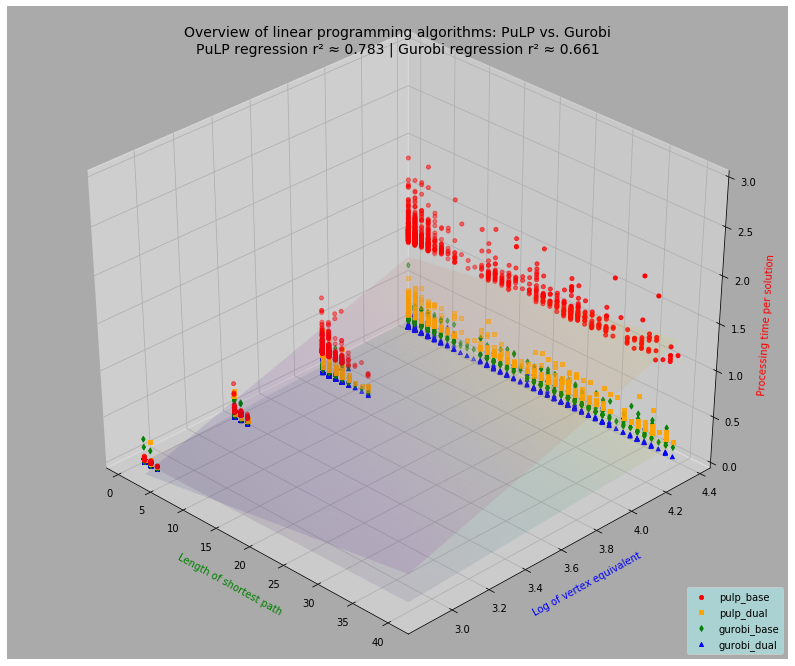

In [166]:
fig = plt.figure(figsize = (14, 12))  # figsize = (14, 11)
ax = fig.gca(projection='3d')
# fig, ax = plt.subplots(figsize = (10, 8))
fig.set_facecolor("white")
ax.set_facecolor("#aaaaaa")

ax.set_xlabel("\nLength of shortest path", color = "green")
ax.set_ylabel("\nLog of vertex equivalent", color = "blue")
ax.set_zlabel("\nProcessing time per solution", color = "red")

# ax.scatter(final_frame.path_length.map(lambda x: int(x)), final_frame.log_vertices.map(lambda x: float(x)),
#            final_frame.time.map(lambda x: float(x)),
#            s = 8, marker = "o", color = "#0000ff66", label = "ttal")


def scatter_algorithm_dots(algorithm, algorithm_color, algorithm_marker):
    ax.scatter(final_frame[final_frame.algorithm == algorithm]["path_length"].map(lambda x: int(x)),
               final_frame[final_frame.algorithm == algorithm]["log_vertices"].map(lambda x: float(x)),
               final_frame[final_frame.algorithm == algorithm]["time"].map(lambda x: float(x)),
               s = 16, marker = algorithm_marker, color = algorithm_color, label = algorithm)

scatter_algorithm_dots("pulp_base", "red", "o")
scatter_algorithm_dots("pulp_dual", "orange", "s")
scatter_algorithm_dots("gurobi_base", "green", "d")
scatter_algorithm_dots("gurobi_dual", "blue", "^")
# scatter_func_dots("tanh", "violet", "v")
# scatter_func_dots("sigmoid", "indigo", "P")

pulp_base_linear_model, pulp_base_score = linear_regression_3d(final_frame[final_frame.algorithm == "pulp_base"],
                                                               "path_length", "log_vertices", "time")
pulp_base_coefficients = pulp_base_linear_model.coef_
pulp_base_intercept = pulp_base_linear_model.intercept_

gurobi_base_linear_model, gurobi_base_score = linear_regression_3d(final_frame[final_frame.algorithm == "gurobi_base"],
                                                                   "path_length", "log_vertices", "time")
gurobi_base_coefficients = gurobi_base_linear_model.coef_
gurobi_base_intercept = gurobi_base_linear_model.intercept_

path_space   = np.linspace(final_frame.path_length.min(),  final_frame.path_length.max(), 120)
vertex_space = np.linspace(final_frame.log_vertices.min(), final_frame.log_vertices.max(), 120)
plot_x, plot_y = np.meshgrid(path_space, vertex_space)

pulp_base_plane = pulp_base_coefficients[0] * plot_x + pulp_base_coefficients[1] * plot_y + pulp_base_intercept
ax.plot_surface(plot_x, plot_y, pulp_base_plane, rstride = 2, cstride = 2, facecolors = cm.plasma(scale_this_graph(pulp_base_plane, final_frame[final_frame.algorithm == "pulp_base"], "time")), alpha = 1/10, linewidth = 0)

gurobi_base_plane = gurobi_base_coefficients[0] * plot_x + gurobi_base_coefficients[1] * plot_y + gurobi_base_intercept
ax.plot_surface(plot_x, plot_y, gurobi_base_plane, rstride = 2, cstride = 2, facecolors = cm.viridis(scale_this_graph(gurobi_base_plane, final_frame[final_frame.algorithm == "gurobi_base"], "time")), alpha = 1/10, linewidth = 0)

plot_title = "Overview of linear programming algorithms: PuLP vs. Gurobi\n"
plot_title += "PuLP regression r² ≈ " + str(round(pulp_base_score, 3))
plot_title += " | Gurobi regression r² ≈ " + str(round(gurobi_base_score, 3))

ax.set_title(plot_title, fontsize = 14)
ax.legend(loc ="lower right", facecolor = "#aadddd22")
ax.set_zlim3d(0, 3)
ax.view_init(36, 315)
plt.savefig("linear_programming_algorithms_3d_plot.png")

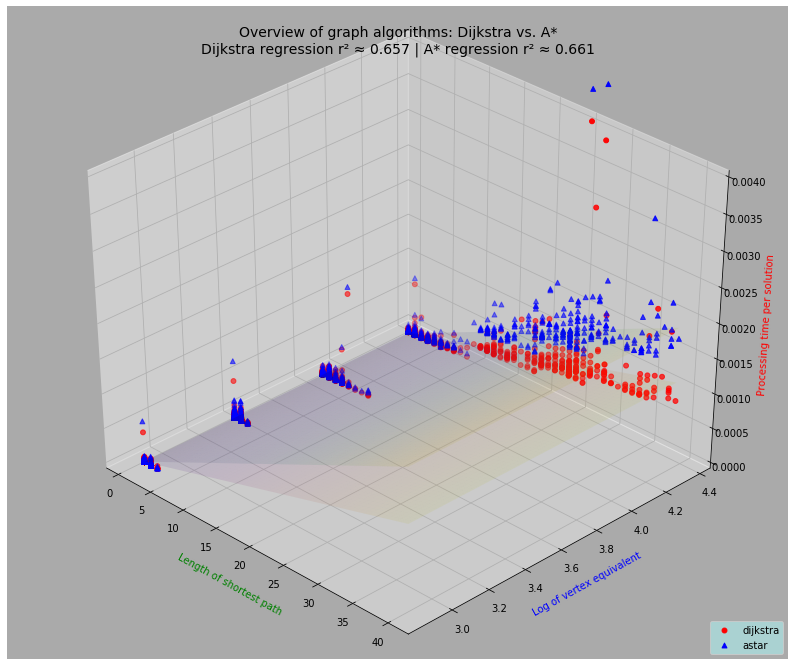

In [167]:
fig = plt.figure(figsize = (14, 12))  # figsize = (14, 11)
ax = fig.gca(projection='3d')
fig.set_facecolor("white")
ax.set_facecolor("#aaaaaa")

ax.set_xlabel("\nLength of shortest path", color = "green")
ax.set_ylabel("\nLog of vertex equivalent", color = "blue")
ax.set_zlabel("\nProcessing time per solution", color = "red")

# Only change in the scattering function is the marker size, from 16 to 24 because there are fewer dots

def scatter_algorithm_dots(algorithm, algorithm_color, algorithm_marker):
    ax.scatter(final_frame[final_frame.algorithm == algorithm]["path_length"].map(lambda x: int(x)),
               final_frame[final_frame.algorithm == algorithm]["log_vertices"].map(lambda x: float(x)),
               final_frame[final_frame.algorithm == algorithm]["time"].map(lambda x: float(x)),
               s = 24, marker = algorithm_marker, color = algorithm_color, label = algorithm)

scatter_algorithm_dots("dijkstra", "red", "o")
# scatter_algorithm_dots("pulp_dual", "orange", "s")
# scatter_algorithm_dots("gurobi_base", "green", "d")
scatter_algorithm_dots("astar", "blue", "^")
# scatter_func_dots("tanh", "violet", "v")
# scatter_func_dots("sigmoid", "indigo", "P")

dijkstra_linear_model, dijkstra_score = linear_regression_3d(final_frame[final_frame.algorithm == "dijkstra"],
                                                               "path_length", "log_vertices", "time")
dijkstra_coefficients = dijkstra_linear_model.coef_
dijkstra_intercept = dijkstra_linear_model.intercept_

astar_linear_model, astar_score = linear_regression_3d(final_frame[final_frame.algorithm == "astar"],
                                                                   "path_length", "log_vertices", "time")
astar_coefficients = astar_linear_model.coef_
astar_intercept = astar_linear_model.intercept_

path_space   = np.linspace(final_frame.path_length.min(),  final_frame.path_length.max(), 120)
vertex_space = np.linspace(final_frame.log_vertices.min(), final_frame.log_vertices.max(), 120)
plot_x, plot_y = np.meshgrid(path_space, vertex_space)

dijkstra_plane = dijkstra_coefficients[0] * plot_x + dijkstra_coefficients[1] * plot_y + dijkstra_intercept
ax.plot_surface(plot_x, plot_y, dijkstra_plane, rstride = 2, cstride = 2, facecolors = cm.plasma(scale_this_graph(dijkstra_plane, final_frame[final_frame.algorithm == "dijkstra"], "time")), alpha = 1/10, linewidth = 0)

astar_plane = astar_coefficients[0] * plot_x + astar_coefficients[1] * plot_y + astar_intercept
ax.plot_surface(plot_x, plot_y, astar_plane, rstride = 2, cstride = 2, facecolors = cm.viridis(scale_this_graph(astar_plane, final_frame[final_frame.algorithm == "astar"], "time")), alpha = 1/10, linewidth = 0)

plot_title = "Overview of graph algorithms: Dijkstra vs. A*\n"
plot_title += "Dijkstra regression r² ≈ " + str(round(dijkstra_score, 3))
plot_title += " | A* regression r² ≈ " + str(round(gurobi_base_score, 3))

ax.set_title(plot_title, fontsize = 14)
ax.legend(loc ="lower right", facecolor = "#aadddd22")
ax.set_zlim3d(0, 0.004) # np.max(final_frame[final_frame.algorithm == "astar"]["time"])
ax.view_init(36, 315)
plt.savefig("graph_algorithms_3d_plot.png")

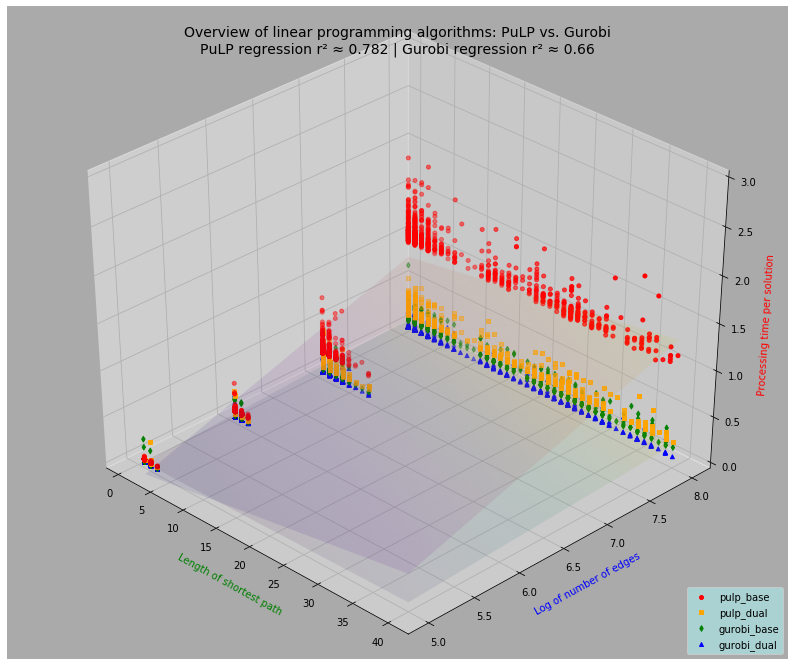

In [168]:
fig = plt.figure(figsize = (14, 12))  # figsize = (14, 11)
ax = fig.gca(projection='3d')
# fig, ax = plt.subplots(figsize = (10, 8))
fig.set_facecolor("white")
ax.set_facecolor("#aaaaaa")

ax.set_xlabel("\nLength of shortest path", color = "green")
ax.set_ylabel("\nLog of number of edges", color = "blue")
ax.set_zlabel("\nProcessing time per solution", color = "red")

def scatter_algorithm_log_edges(algorithm, algorithm_color, algorithm_marker):
    ax.scatter(final_frame[final_frame.algorithm == algorithm]["path_length"].map(lambda x: int(x)),
               final_frame[final_frame.algorithm == algorithm]["log_edges"].map(lambda x: int(x)),
               final_frame[final_frame.algorithm == algorithm]["time"].map(lambda x: float(x)),
               s = 16, marker = algorithm_marker, color = algorithm_color, label = algorithm)

scatter_algorithm_log_edges("pulp_base", "red", "o")
scatter_algorithm_log_edges("pulp_dual", "orange", "s")
scatter_algorithm_log_edges("gurobi_base", "green", "d")
scatter_algorithm_log_edges("gurobi_dual", "blue", "^")

pulp_base_linear_model, pulp_base_score = linear_regression_3d(final_frame[final_frame.algorithm == "pulp_base"],
                                                               "path_length", "log_edges", "time")
pulp_base_coefficients = pulp_base_linear_model.coef_
pulp_base_intercept = pulp_base_linear_model.intercept_

gurobi_base_linear_model, gurobi_base_score = linear_regression_3d(final_frame[final_frame.algorithm == "gurobi_base"],
                                                                   "path_length", "log_edges", "time")
gurobi_base_coefficients = gurobi_base_linear_model.coef_
gurobi_base_intercept = gurobi_base_linear_model.intercept_

path_space   = np.linspace(final_frame.path_length.min(),  final_frame.path_length.max(), 120)
vertex_space = np.linspace(final_frame.log_edges.min(), final_frame.log_edges.max(), 120)
plot_x, plot_y = np.meshgrid(path_space, vertex_space)

pulp_base_plane = pulp_base_coefficients[0] * plot_x + pulp_base_coefficients[1] * plot_y + pulp_base_intercept
ax.plot_surface(plot_x, plot_y, pulp_base_plane, rstride = 2, cstride = 2, facecolors = cm.plasma(scale_this_graph(pulp_base_plane, final_frame[final_frame.algorithm == "pulp_base"], "time")), alpha = 1/10, linewidth = 0)

gurobi_base_plane = gurobi_base_coefficients[0] * plot_x + gurobi_base_coefficients[1] * plot_y + gurobi_base_intercept
ax.plot_surface(plot_x, plot_y, gurobi_base_plane, rstride = 2, cstride = 2, facecolors = cm.viridis(scale_this_graph(gurobi_base_plane, final_frame[final_frame.algorithm == "gurobi_base"], "time")), alpha = 1/10, linewidth = 0)

plot_title = "Overview of linear programming algorithms: PuLP vs. Gurobi\n"
plot_title += "PuLP regression r² ≈ " + str(round(pulp_base_score, 3))
plot_title += " | Gurobi regression r² ≈ " + str(round(gurobi_base_score, 3))

ax.set_title(plot_title, fontsize = 14)
ax.legend(loc ="lower right", facecolor = "#aadddd22")
ax.set_zlim3d(0, 3)
ax.view_init(36, 315)
plt.savefig("linear_programming_log_edges_3d_plot.png")

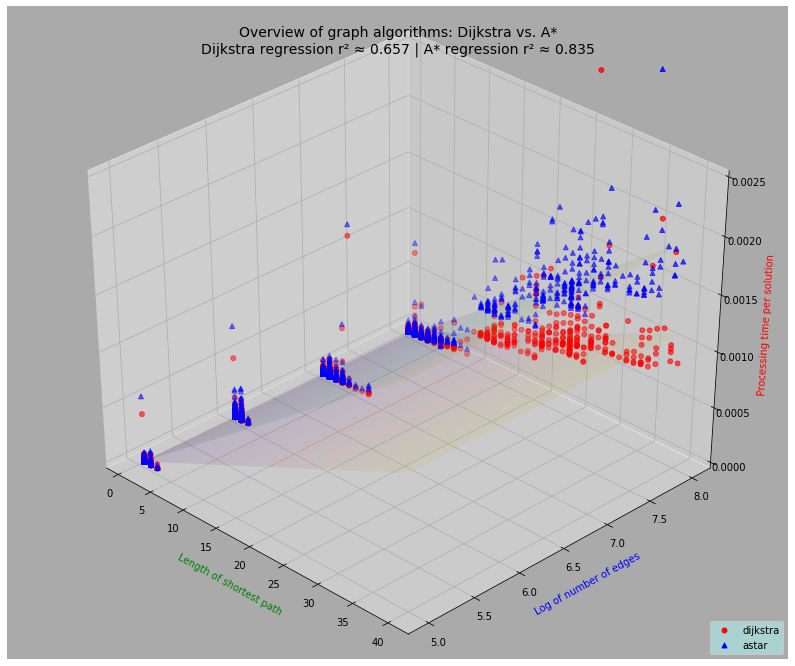

In [209]:
fig = plt.figure(figsize = (14, 12))  # figsize = (14, 11)
ax = fig.gca(projection='3d')
# fig, ax = plt.subplots(figsize = (10, 8))
fig.set_facecolor("white")
ax.set_facecolor("#aaaaaa")

ax.set_xlabel("\nLength of shortest path", color = "green")
ax.set_ylabel("\nLog of number of edges", color = "blue")
ax.set_zlabel("\nProcessing time per solution", color = "red")

def scatter_algorithm_log_edges(algorithm, algorithm_color, algorithm_marker):
    ax.scatter(final_frame[final_frame.algorithm == algorithm]["path_length"].map(lambda x: int(x)),
               final_frame[final_frame.algorithm == algorithm]["log_edges"].map(lambda x: int(x)),
               final_frame[final_frame.algorithm == algorithm]["time"].map(lambda x: float(x)),
               s = 24, marker = algorithm_marker, color = algorithm_color, label = algorithm)

scatter_algorithm_log_edges("dijkstra", "red", "o")
# scatter_algorithm_log_edges("pulp_dual", "orange", "s")
# scatter_algorithm_log_edges("astar", "green", "d")
scatter_algorithm_log_edges("astar", "blue", "^")

dijkstra_linear_model, dijkstra_score = linear_regression_3d(final_frame[final_frame.algorithm == "dijkstra"],
                                                               "path_length", "log_edges", "time")
dijkstra_coefficients = dijkstra_linear_model.coef_
dijkstra_intercept = dijkstra_linear_model.intercept_

astar_linear_model, astar_score = linear_regression_3d(final_frame[final_frame.algorithm == "astar"],
                                                                   "path_length", "log_edges", "time")
astar_coefficients = astar_linear_model.coef_
astar_intercept = astar_linear_model.intercept_

path_space   = np.linspace(final_frame.path_length.min(),  final_frame.path_length.max(), 120)
vertex_space = np.linspace(final_frame.log_edges.min(), final_frame.log_edges.max(), 120)
plot_x, plot_y = np.meshgrid(path_space, vertex_space)

dijkstra_plane = dijkstra_coefficients[0] * plot_x + dijkstra_coefficients[1] * plot_y + dijkstra_intercept
ax.plot_surface(plot_x, plot_y, dijkstra_plane, rstride = 2, cstride = 2, facecolors = cm.plasma(scale_this_graph(dijkstra_plane, final_frame[final_frame.algorithm == "dijkstra"], "time")), alpha = 1/10, linewidth = 0)

astar_plane = astar_coefficients[0] * plot_x + astar_coefficients[1] * plot_y + astar_intercept
ax.plot_surface(plot_x, plot_y, astar_plane, rstride = 2, cstride = 2, facecolors = cm.viridis(scale_this_graph(astar_plane, final_frame[final_frame.algorithm == "astar"], "time")), alpha = 1/10, linewidth = 0)

plot_title = "Overview of graph algorithms: Dijkstra vs. A*\n"
plot_title += "Dijkstra regression r² ≈ " + str(round(dijkstra_score, 3))
plot_title += " | A* regression r² ≈ " + str(round(astar_score, 3))

ax.set_title(plot_title, fontsize = 14)
ax.legend(loc ="lower right", facecolor = "#aadddd22")
ax.set_zlim3d(0, 0.0025)
ax.view_init(36, 315)
plt.savefig("graph_algorithms_log_edges_3d_plot.png")

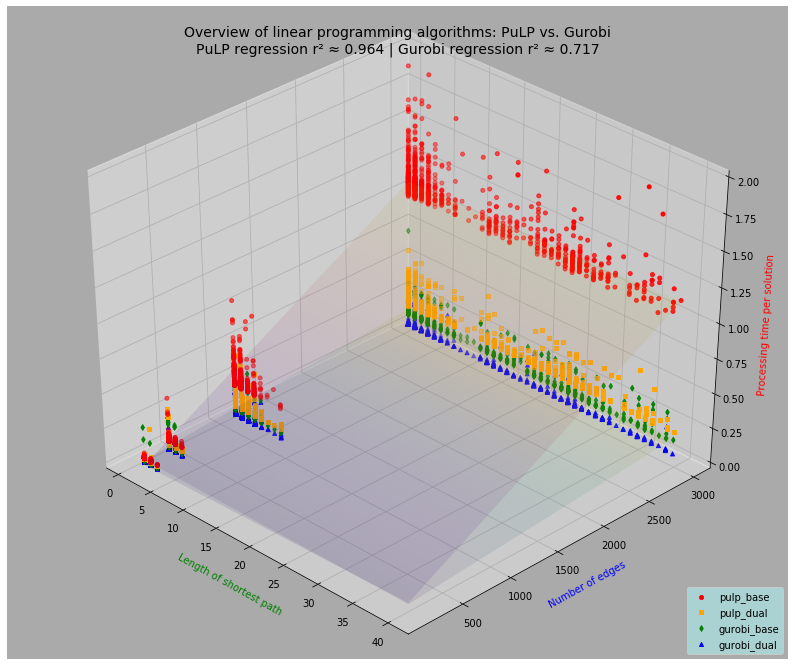

In [217]:
fig = plt.figure(figsize = (14, 12))  # figsize = (14, 11)
ax = fig.gca(projection='3d')
# fig, ax = plt.subplots(figsize = (10, 8))
fig.set_facecolor("white")
ax.set_facecolor("#aaaaaa")

ax.set_xlabel("\nLength of shortest path", color = "green")
ax.set_ylabel("\nNumber of edges", color = "blue")
ax.set_zlabel("\nProcessing time per solution", color = "red")

def scatter_algorithm_n_edges(algorithm, algorithm_color, algorithm_marker):
    ax.scatter(final_frame[final_frame.algorithm == algorithm]["path_length"].map(lambda x: int(x)),
               final_frame[final_frame.algorithm == algorithm]["n_edges"].map(lambda x: int(x)),
               final_frame[final_frame.algorithm == algorithm]["time"].map(lambda x: float(x)),
               s = 16, marker = algorithm_marker, color = algorithm_color, label = algorithm)

scatter_algorithm_n_edges("pulp_base", "red", "o")
scatter_algorithm_n_edges("pulp_dual", "orange", "s")
scatter_algorithm_n_edges("gurobi_base", "green", "d")
scatter_algorithm_n_edges("gurobi_dual", "blue", "^")

pulp_base_linear_model, pulp_base_score = linear_regression_3d(final_frame[final_frame.algorithm == "pulp_base"],
                                                               "path_length", "n_edges", "time")
pulp_base_coefficients = pulp_base_linear_model.coef_
pulp_base_intercept = pulp_base_linear_model.intercept_

gurobi_base_linear_model, gurobi_base_score = linear_regression_3d(final_frame[final_frame.algorithm == "gurobi_base"],
                                                                   "path_length", "n_edges", "time")
gurobi_base_coefficients = gurobi_base_linear_model.coef_
gurobi_base_intercept = gurobi_base_linear_model.intercept_

path_space   = np.linspace(final_frame.path_length.min(),  final_frame.path_length.max(), 120)
vertex_space = np.linspace(final_frame.n_edges.min(), final_frame.n_edges.max(), 120)
plot_x, plot_y = np.meshgrid(path_space, vertex_space)

pulp_base_plane = pulp_base_coefficients[0] * plot_x + pulp_base_coefficients[1] * plot_y + pulp_base_intercept
ax.plot_surface(plot_x, plot_y, pulp_base_plane, rstride = 2, cstride = 2, facecolors = cm.plasma(scale_this_graph(pulp_base_plane, final_frame[final_frame.algorithm == "pulp_base"], "time")), alpha = 1/10, linewidth = 0)

gurobi_base_plane = gurobi_base_coefficients[0] * plot_x + gurobi_base_coefficients[1] * plot_y + gurobi_base_intercept
ax.plot_surface(plot_x, plot_y, gurobi_base_plane, rstride = 2, cstride = 2, facecolors = cm.viridis(scale_this_graph(gurobi_base_plane, final_frame[final_frame.algorithm == "gurobi_base"], "time")), alpha = 1/10, linewidth = 0)

plot_title = "Overview of linear programming algorithms: PuLP vs. Gurobi\n"
plot_title += "PuLP regression r² ≈ " + str(round(pulp_base_score, 3))
plot_title += " | Gurobi regression r² ≈ " + str(round(gurobi_base_score, 3))

ax.set_title(plot_title, fontsize = 14)
ax.legend(loc ="lower right", facecolor = "#aadddd22")
ax.set_zlim3d(0, 2)
ax.view_init(36, 315)
plt.savefig("linear_programming_n_edges_3d_plot.png")

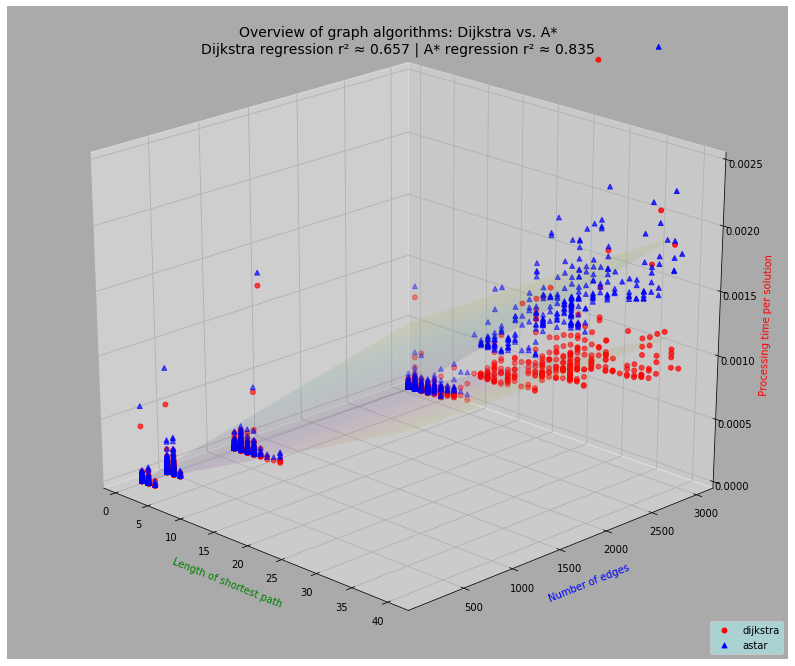

In [218]:
fig = plt.figure(figsize = (14, 12))  # figsize = (14, 11)
ax = fig.gca(projection='3d')
# fig, ax = plt.subplots(figsize = (10, 8))
fig.set_facecolor("white")
ax.set_facecolor("#aaaaaa")

ax.set_xlabel("\nLength of shortest path", color = "green")
ax.set_ylabel("\nNumber of edges", color = "blue")
ax.set_zlabel("\nProcessing time per solution", color = "red")

def scatter_algorithm_n_edges(algorithm, algorithm_color, algorithm_marker):
    ax.scatter(final_frame[final_frame.algorithm == algorithm]["path_length"].map(lambda x: int(x)),
               final_frame[final_frame.algorithm == algorithm]["n_edges"].map(lambda x: int(x)),
               final_frame[final_frame.algorithm == algorithm]["time"].map(lambda x: float(x)),
               s = 24, marker = algorithm_marker, color = algorithm_color, label = algorithm)

scatter_algorithm_n_edges("dijkstra", "red", "o")
# scatter_algorithm_n_edges("pulp_dual", "orange", "s")
# scatter_algorithm_n_edges("astar", "green", "d")
scatter_algorithm_n_edges("astar", "blue", "^")

dijkstra_linear_model, dijkstra_score = linear_regression_3d(final_frame[final_frame.algorithm == "dijkstra"],
                                                               "path_length", "n_edges", "time")
dijkstra_coefficients = dijkstra_linear_model.coef_
dijkstra_intercept = dijkstra_linear_model.intercept_

astar_linear_model, astar_score = linear_regression_3d(final_frame[final_frame.algorithm == "astar"],
                                                                   "path_length", "n_edges", "time")
astar_coefficients = astar_linear_model.coef_
astar_intercept = astar_linear_model.intercept_

path_space   = np.linspace(final_frame.path_length.min(),  final_frame.path_length.max(), 120)
vertex_space = np.linspace(final_frame.n_edges.min(), final_frame.n_edges.max(), 120)
plot_x, plot_y = np.meshgrid(path_space, vertex_space)

dijkstra_plane = dijkstra_coefficients[0] * plot_x + dijkstra_coefficients[1] * plot_y + dijkstra_intercept
ax.plot_surface(plot_x, plot_y, dijkstra_plane, rstride = 2, cstride = 2, facecolors = cm.plasma(scale_this_graph(dijkstra_plane, final_frame[final_frame.algorithm == "dijkstra"], "time")), alpha = 1/10, linewidth = 0)

astar_plane = astar_coefficients[0] * plot_x + astar_coefficients[1] * plot_y + astar_intercept
ax.plot_surface(plot_x, plot_y, astar_plane, rstride = 2, cstride = 2, facecolors = cm.viridis(scale_this_graph(astar_plane, final_frame[final_frame.algorithm == "astar"], "time")), alpha = 1/10, linewidth = 0)

plot_title = "Overview of graph algorithms: Dijkstra vs. A*\n"
plot_title += "Dijkstra regression r² ≈ " + str(round(dijkstra_score, 3))
plot_title += " | A* regression r² ≈ " + str(round(astar_score, 3))

ax.set_title(plot_title, fontsize = 14)
ax.legend(loc ="lower right", facecolor = "#aadddd22")
ax.set_zlim3d(0, 0.0025)
ax.view_init(24, 315)
plt.savefig("graph_algorithms_n_edges_3d_plot.png")

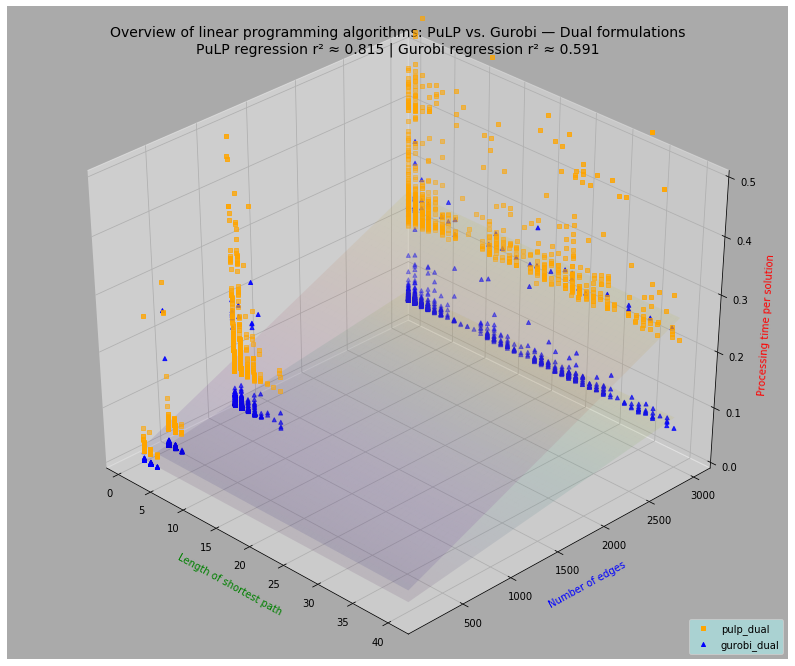

In [219]:
fig = plt.figure(figsize = (14, 12))  # figsize = (14, 11)
ax = fig.gca(projection='3d')
# fig, ax = plt.subplots(figsize = (10, 8))
fig.set_facecolor("white")
ax.set_facecolor("#aaaaaa")

ax.set_xlabel("\nLength of shortest path", color = "green")
ax.set_ylabel("\nNumber of edges", color = "blue")
ax.set_zlabel("\nProcessing time per solution", color = "red")

def scatter_algorithm_n_edges(algorithm, algorithm_color, algorithm_marker):
    ax.scatter(final_frame[final_frame.algorithm == algorithm]["path_length"].map(lambda x: int(x)),
               final_frame[final_frame.algorithm == algorithm]["n_edges"].map(lambda x: int(x)),
               final_frame[final_frame.algorithm == algorithm]["time"].map(lambda x: float(x)),
               s = 16, marker = algorithm_marker, color = algorithm_color, label = algorithm)

# scatter_algorithm_n_edges("pulp_base", "red", "o")
scatter_algorithm_n_edges("pulp_dual", "orange", "s")
# scatter_algorithm_n_edges("gurobi_base", "green", "d")
scatter_algorithm_n_edges("gurobi_dual", "blue", "^")

pulp_dual_linear_model, pulp_dual_score = linear_regression_3d(final_frame[final_frame.algorithm == "pulp_dual"],
                                                               "path_length", "n_edges", "time")
pulp_dual_coefficients = pulp_dual_linear_model.coef_
pulp_dual_intercept = pulp_dual_linear_model.intercept_

gurobi_dual_linear_model, gurobi_dual_score = linear_regression_3d(final_frame[final_frame.algorithm == "gurobi_dual"],
                                                                   "path_length", "n_edges", "time")
gurobi_dual_coefficients = gurobi_dual_linear_model.coef_
gurobi_dual_intercept = gurobi_dual_linear_model.intercept_

path_space   = np.linspace(final_frame.path_length.min(),  final_frame.path_length.max(), 120)
vertex_space = np.linspace(final_frame.n_edges.min(), final_frame.n_edges.max(), 120)
plot_x, plot_y = np.meshgrid(path_space, vertex_space)

pulp_dual_plane = pulp_dual_coefficients[0] * plot_x + pulp_dual_coefficients[1] * plot_y + pulp_dual_intercept
ax.plot_surface(plot_x, plot_y, pulp_dual_plane, rstride = 2, cstride = 2, facecolors = cm.plasma(scale_this_graph(pulp_dual_plane, final_frame[final_frame.algorithm == "pulp_base"], "time")), alpha = 1/10, linewidth = 0)

gurobi_dual_plane = gurobi_dual_coefficients[0] * plot_x + gurobi_dual_coefficients[1] * plot_y + gurobi_dual_intercept
ax.plot_surface(plot_x, plot_y, gurobi_dual_plane, rstride = 2, cstride = 2, facecolors = cm.viridis(scale_this_graph(gurobi_dual_plane, final_frame[final_frame.algorithm == "gurobi_base"], "time")), alpha = 1/10, linewidth = 0)

plot_title = "Overview of linear programming algorithms: PuLP vs. Gurobi — Dual formulations\n"
plot_title += "PuLP regression r² ≈ " + str(round(pulp_dual_score, 3))
plot_title += " | Gurobi regression r² ≈ " + str(round(gurobi_dual_score, 3))

ax.set_title(plot_title, fontsize = 14)
ax.legend(loc ="lower right", facecolor = "#aadddd22")
ax.set_zlim3d(0, 0.5)
ax.view_init(36, 315)
plt.savefig("lp_dual_n_edges_3d_plot.png")

In [232]:
# A final shot at measuring memory?


def pulp_base_final_trial(i):
    start_node_key = start_nodes_keys_list_4[i]
    end_node_key = end_nodes_keys_list_4[i]
    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_4, sampled_edges_4, start_node_key, end_node_key)
    prob = define_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_LP(prob)
    return clicks

def pulp_dual_final_trial(i):
    start_node_key = start_nodes_keys_list_4[i]
    end_node_key = end_nodes_keys_list_4[i]
    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_4, sampled_edges_4, start_node_key, end_node_key)
    prob = define_dual_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_LP(prob)
    return clicks

def gurobi_base_final_trial(i):
    start_node_key = start_nodes_keys_list_4[i]
    end_node_key = end_nodes_keys_list_4[i]
    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_4, sampled_edges_4, start_node_key, end_node_key)
    prob = define_gurobi_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_gurobi_lp(prob)
    return clicks

def gurobi_dual_final_trial(i):
    start_node_key = start_nodes_keys_list_4[i]
    end_node_key = end_nodes_keys_list_4[i]
    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_4, sampled_edges_4, start_node_key, end_node_key)
    prob = define_gurobi_dual_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_gurobi_dual_lp(prob)
    return clicks

def dijkstra_final_trial(i): 
    start_node_key = start_nodes_keys_list_4[i]  # was: "start_nodes_keys_list" — This generated an error
    end_node_key = end_nodes_keys_list_4[i]  # Same issue as the previous line
    try:
        shortest_path = nx.dijkstra_path(H_4, source = start_node_key, target = end_node_key)
        path_length = len(shortest_path) - 1
    except:
        path_length = 0
    return path_length

def astar_final_trial(i): 
    start_node_key = start_nodes_keys_list_4[i]  # was: "start_nodes_keys_list" — This generated an error
    end_node_key = end_nodes_keys_list_4[i]  # Same issue as the previous line
    try:
        shortest_path = nx.astar_path(H_4, source = start_node_key, target = end_node_key)
        path_length = len(shortest_path) - 1
    except:
        path_length = 0
    return path_length

In [249]:
FINAL_MEMORY_INTERVAL = 0.1
PULP_BASE_TRIALS = 9

def pulp_base_final():
    for i in range(PULP_BASE_TRIALS):
        pulp_base_final_trial(i)

def pulp_dual_final():
    for i in range(int(np.ceil(PULP_BASE_TRIALS * 4.428))):
        pulp_dual_final_trial(i)

def gurobi_base_final():
    for i in range(int(np.ceil(PULP_BASE_TRIALS * 6.48))):
        gurobi_base_final_trial(i)
        
def gurobi_dual_final():
    for i in range(int(np.ceil(PULP_BASE_TRIALS * 14.325))):
        gurobi_dual_final_trial(i)

def dijkstra_final():
    for j in range(6 * PULP_BASE_TRIALS):
        for i in range(NUM_RUNS):
            dijkstra_final_trial(i)

def astar_final():
    for j in range(int(3.6 * PULP_BASE_TRIALS)):
        for i in range(NUM_RUNS):
            astar_final_trial(i)

In [250]:
pulp_base_final_memory = memory_usage(pulp_base_final, interval = FINAL_MEMORY_INTERVAL, timeout = 10,
                                     multiprocess = True, include_children = True)
pulp_dual_final_memory = memory_usage(pulp_dual_final, interval = FINAL_MEMORY_INTERVAL, timeout = 10,
                                     multiprocess = True, include_children = True)
gurobi_base_final_memory = memory_usage(gurobi_base_final, interval = FINAL_MEMORY_INTERVAL, timeout = 10,
                                        multiprocess = True, include_children = True)
gurobi_dual_final_memory = memory_usage(gurobi_dual_final, interval = FINAL_MEMORY_INTERVAL, timeout = 10,
                                        multiprocess = True, include_children = True)
dijkstra_final_memory = memory_usage(dijkstra_final, interval = FINAL_MEMORY_INTERVAL, timeout = 10,
                                     multiprocess = True, include_children = True)
astar_final_memory = memory_usage(astar_final, interval = FINAL_MEMORY_INTERVAL, timeout = 10,
                                  multiprocess = True, include_children = True)

Peak usage for pulp_base   	   0.605469
Peak usage for pulp_dual   	   0.253906
Peak usage for gurobi_base 	   2.679688
Peak usage for gurobi_dual 	   1.843750
Peak usage for dijkstra    	   0.000000
Peak usage for astar       	   0.023438



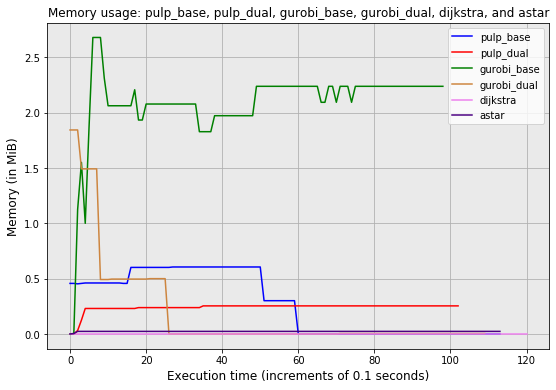

In [251]:
six_way_memory_report(pulp_base_final_memory, pulp_dual_final_memory, gurobi_base_final_memory,
                      gurobi_dual_final_memory, dijkstra_final_memory, astar_final_memory,
                      "pulp_base", "pulp_dual", "gurobi_base", "gurobi_dual", "dijkstra", "astar")

Peak usage for pulp_base   	   0.605469
Peak usage for pulp_dual   	   0.253906
Peak usage for gurobi_base 	   2.679688
Peak usage for gurobi_dual 	   1.843750
Peak usage for dijkstra    	   0.000000
Peak usage for astar       	   0.023438



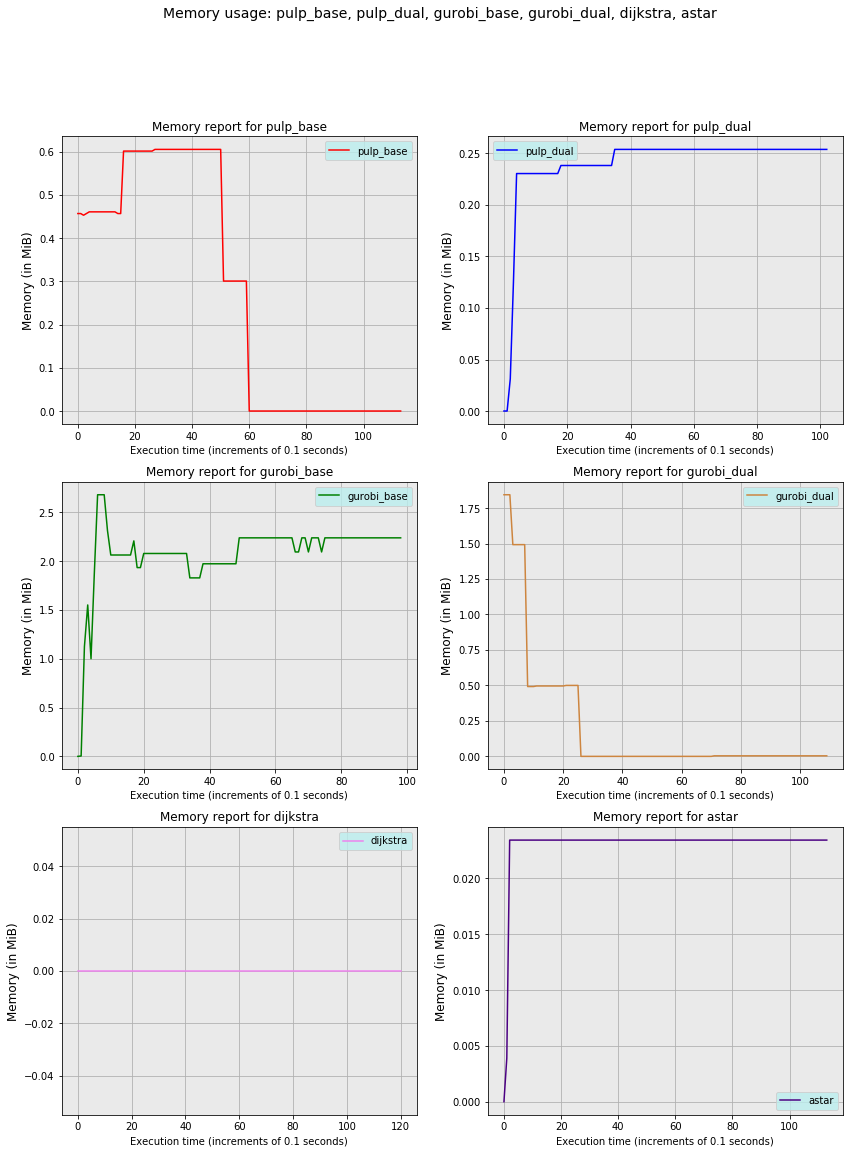

In [252]:
six_subplot_memory_report(pulp_base_final_memory, pulp_dual_final_memory, gurobi_base_final_memory,
                      gurobi_dual_final_memory, dijkstra_final_memory, astar_final_memory,
                      "pulp_base", "pulp_dual", "gurobi_base", "gurobi_dual", "dijkstra", "astar")

In [234]:
%memit pulp_base_final_trial(0)
%memit pulp_dual_final_trial(0)
%memit gurobi_base_final_trial(0)
%memit gurobi_dual_final_trial(0)
%memit dijkstra_final_trial(0)
%memit astar_final_trial(0)

peak memory: 294.51 MiB, increment: 0.11 MiB
peak memory: 294.76 MiB, increment: 0.25 MiB
peak memory: 300.22 MiB, increment: 5.45 MiB
peak memory: 300.83 MiB, increment: 0.90 MiB
peak memory: 300.39 MiB, increment: 0.02 MiB
peak memory: 300.41 MiB, increment: 0.03 MiB


In [236]:
%memit pulp_base_final_trial(1)
%memit pulp_dual_final_trial(1)
%memit gurobi_base_final_trial(1)
%memit gurobi_dual_final_trial(1)
%memit dijkstra_final_trial(1)
%memit astar_final_trial(1)

peak memory: 301.24 MiB, increment: 0.14 MiB
peak memory: 301.24 MiB, increment: 0.00 MiB
peak memory: 302.70 MiB, increment: 1.45 MiB
peak memory: 301.62 MiB, increment: -0.68 MiB
peak memory: 301.46 MiB, increment: 0.01 MiB
peak memory: 301.46 MiB, increment: 0.00 MiB


## A final look at our timekeeping profiler and its secrets

Though we have extracted much of the value from our timekeeping profiler/decorator function, we might as well look at its overall contents. Among other things, the time registered in tracked functions is roughly equivalent to the amount of time consumed by this program.

In [170]:
profile_frame, result = organize_result(PROF_DATA, DATA_CATEGORIES)
result

	*** Timekeeping summary of profiled functions ***

24 profiled functions took 33792 calls for 2476.907125 total seconds, an average of 103.204464.


category calls        total   average   std_dev  \
pulp_base_trial_1e4      pulp_base  1024  1173.809193  1.146298  0.124981   
pulp_base_trial_1e3      pulp_base  1024   292.124966  0.285278  0.068006   
pulp_dual_trial_1e4      pulp_dual  1024   265.082721  0.258870  0.068023   
gurobi_base_trial_1e4  gurobi_base  1024   181.143398  0.176898  0.063034   
pulp_dual_trial_1e3      pulp_dual  1024   117.314502  0.114565  0.050151   
gurobi_dual_trial_1e4  gurobi_dual  1024    81.942460  0.080022  0.043278   
gurobi_base_trial_1e3  gurobi_base  1024    80.280306  0.078399  0.041037   
pulp_base_trial_1e2      pulp_base  1024    80.144064  0.078266  0.018124   
pulp_dual_trial_1e2      pulp_dual  1024    49.046745  0.047897  0.013138   
gurobi_base_trial_1e2  gurobi_base  1024    34.287186  0.033484  0.021847   
pulp_base_trial          pulp_base  1024    33.888337  0.033094  0.003937   
gurobi_dual_trial_1e3  gurobi_dual  1024    32.215738  0.031461  0.021775   
pulp_dual_trial          pulp_dual  1024    27.245884  0.026607  0.008093   
gurobi_base_trial      gurobi_base  1024    12.007986  0.011727  0.010361   
gurobi_dual_trial_1e2  gurobi_dual  1024    11.378065  0.011111  0.009167   
gurobi_dual_trial      gurobi_dual  1024     4.128344  0.004032  0.000739   
astar_trial_1e4              astar  1024     0.368958  0.000360  0.000580   
dijkstra_trial_1e4        dijkstra  1024     0.226367  0.000221  0.000400   
astar_trial_1e3              astar  2048     0.063703  0.000031  0.000056   
dijkstra_trial_1e2        dijkstra  3072     0.050854  0.000017  0.000029   
dijkstra_trial_1e3        dijkstra  2048     0.047615  0.000023  0.000053   
astar_trial_1e2              astar  2048     0.043679  0.000021  0.000037   
astar_trial                  astar  3072     0.037693  0.000012  0.000023   
dijkstra_trial            dijkstra  3072     0.028362  0.000009  0.000017   

                        maximum   minimum  
pulp_base_trial_1e4    1.920472  1.002972  
pulp_base_trial_1e3    0.853628  0.233549  
pulp_dual_trial_1e4    0.612977  0.198680  
gurobi_base_trial_1e4  0.755752  0.131719  
pulp_dual_trial_1e3    0.496578  0.085273  
gurobi_dual_trial_1e4  0.354383  0.060571  
gurobi_base_trial_1e3  0.386316  0.058983  
pulp_base_trial_1e2    0.382355  0.066429  
pulp_dual_trial_1e2    0.302262  0.039382  
gurobi_base_trial_1e2  0.268536  0.026013  
pulp_base_trial        0.070059  0.027503  
gurobi_dual_trial_1e3  0.263084  0.023313  
pulp_dual_trial        0.269233  0.021546  
gurobi_base_trial      0.257246  0.010368  
gurobi_dual_trial_1e2  0.252205  0.009332  
gurobi_dual_trial      0.019730  0.003676  
astar_trial_1e4        0.005878  0.000006  
dijkstra_trial_1e4     0.005591  0.000005  
astar_trial_1e3        0.001587  0.000007  
dijkstra_trial_1e2     0.000764  0.000005  
dijkstra_trial_1e3     0.001544  0.000004  
astar_trial_1e2        0.000840  0.000007  
astar_trial            0.000679  0.000007  
dijkstra_trial         0.000444  0.000004

In [171]:
profile_frame[profile_frame.category == "pulp_base"].loc[:, ["calls", "total", "average", "std_dev", "maximum", "minimum"]].sort_values(by = "total", ascending = False)

calls        total   average   std_dev   maximum   minimum
pulp_base_trial_1e4  1024  1173.809193  1.146298  0.124981  1.920472  1.002972
pulp_base_trial_1e3  1024   292.124966  0.285278  0.068006  0.853628  0.233549
pulp_base_trial_1e2  1024    80.144064  0.078266  0.018124  0.382355  0.066429
pulp_base_trial      1024    33.888337  0.033094  0.003937  0.070059  0.027503

In [172]:
profile_frame[profile_frame.category == "pulp_dual"].loc[:, ["calls", "total", "average", "std_dev", "maximum", "minimum"]].sort_values(by = "total", ascending = False)

calls       total   average   std_dev   maximum   minimum
pulp_dual_trial_1e4  1024  265.082721  0.258870  0.068023  0.612977  0.198680
pulp_dual_trial_1e3  1024  117.314502  0.114565  0.050151  0.496578  0.085273
pulp_dual_trial_1e2  1024   49.046745  0.047897  0.013138  0.302262  0.039382
pulp_dual_trial      1024   27.245884  0.026607  0.008093  0.269233  0.021546

In [173]:
profile_frame[profile_frame.category == "gurobi_base"].loc[:, ["calls", "total", "average", "std_dev", "maximum", "minimum"]].sort_values(by = "total", ascending = False)

calls       total   average   std_dev   maximum  \
gurobi_base_trial_1e4  1024  181.143398  0.176898  0.063034  0.755752   
gurobi_base_trial_1e3  1024   80.280306  0.078399  0.041037  0.386316   
gurobi_base_trial_1e2  1024   34.287186  0.033484  0.021847  0.268536   
gurobi_base_trial      1024   12.007986  0.011727  0.010361  0.257246   

                        minimum  
gurobi_base_trial_1e4  0.131719  
gurobi_base_trial_1e3  0.058983  
gurobi_base_trial_1e2  0.026013  
gurobi_base_trial      0.010368

In [174]:
profile_frame[profile_frame.category == "gurobi_dual"].loc[:, ["calls", "total", "average", "std_dev", "maximum", "minimum"]].sort_values(by = "total", ascending = False)

calls      total   average   std_dev   maximum   minimum
gurobi_dual_trial_1e4  1024  81.942460  0.080022  0.043278  0.354383  0.060571
gurobi_dual_trial_1e3  1024  32.215738  0.031461  0.021775  0.263084  0.023313
gurobi_dual_trial_1e2  1024  11.378065  0.011111  0.009167  0.252205  0.009332
gurobi_dual_trial      1024   4.128344  0.004032  0.000739  0.019730  0.003676

In [175]:
profile_frame.groupby("category")["total"].sum().sort_values(ascending = False)

category
pulp_base      1579.966560
pulp_dual       458.689851
gurobi_base     307.718876
gurobi_dual     129.664608
astar             0.514033
dijkstra          0.353198
Name: total, dtype: float64

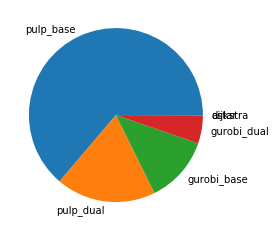

In [176]:
plt.pie(profile_frame.groupby("category")["total"].sum().sort_values(ascending = False), labels = profile_frame.groupby("category")["total"].sum().sort_values(ascending = False).index)
plt.savefig("time_pie.png")

There are (more) things we can and should do with the time and the actual results of the objective function. But this will certainly suffice as a Thursday night checkpoint, heading into the final weekend before the presentation.